# Imports

In [ ]:
import pickle
import torch
import random
import math
import h5py
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import models, transforms
from torchvision.utils import make_grid
from torchsummary import summary
from torchvision.transforms import v2
from google.colab import drive
from google.colab import runtime
from PIL import Image
!pip install torchinfo
!pip install tensorboard
from torchinfo import summary
drive.mount('/content/drive')

Mounted at /content/drive


# Data

File Loading

In [ ]:
# Load training data from HDF5 file
with h5py.File('/content/drive/My Drive/AV Research/train_data.h5', 'r') as train_file:
    train_data = np.array(train_file['data'])
    train_labels = np.array(train_file['labels'])

# Load validation data from HDF5 file
with h5py.File('/content/drive/My Drive/AV Research/val_data.h5', 'r') as val_file:
    val_data = np.array(val_file['data'])
    val_labels = np.array(val_file['labels'])

In [ ]:
# From: https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch
def dataset_mean_std(data_loader):
  nimages = 0
  mean = 0.
  std = 0.
  for batch, _ in data_loader:
      # Rearrange batch to be the shape of [B, C, W * H]
      batch = batch.view(batch.size(0), batch.size(1), -1)
      # Update total number of images
      nimages += batch.size(0)
      # Compute mean and std here
      mean += batch.float().mean(2).sum(0)
      std += batch.float().std(2).sum(0)

  # Final step
  mean /= nimages
  std /= nimages

  print("Training set mean", mean)
  print("Training set std", std)

  return mean, std

def get_mean_std(data):
  mean = np.mean(data, axis=(0, 1, 2))
  std = np.std(data, axis=(0, 1, 2))
  return mean, std

Data Transformations

In [ ]:
class RandomHorizontalFlipWithSteeringAngle(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, input, output):
        if random.random() < self.p:
            v2.functional.hflip(input)
            output[0] = -output[0]
        return input, output

class TrainDataAugmentation(nn.Module):
    def __init__(self):
        super(TrainDataAugmentation, self).__init__()
        self.transforms = v2.Compose([
            v2.Resize((119//2, 256//2)),
            v2.ToPILImage(),
            v2.RandomAffine(degrees=0, translate=(0.2, 0.2)),
            v2.RandomRotation(degrees=45),
            v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
            v2.Normalize(mean=(0.4872, 0.4669, 0.4469,), std=(0.1138, 0.1115, 0.1074,)),
        ])

    def forward(self, image):
        augmented_image = self.transforms(image)
        return augmented_image

class ValDataAugmentation(nn.Module):
    def __init__(self):
        super(ValDataAugmentation, self).__init__()
        self.transforms = v2.Compose([
            v2.Resize((119//2, 256//2)),
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
            v2.Normalize(mean=(0.4872, 0.4669, 0.4469,), std=(0.1138, 0.1115, 0.1074,)),
        ])

    def forward(self, image):
        augmented_image = self.transforms(image)
        return augmented_image

Data Preprocessing

In [ ]:
class AVDataset(Dataset):
    def __init__(self, input_images, output_values, transform):
        self.input_images = input_images
        self.output_values = output_values
        self.transform = transform

    def __len__(self):
        return len(self.output_values)

    def __getitem__(self, idx):
        input_image = self.input_images[idx]
        output_value = self.output_values[idx]

        if self.transform:
            input_image = self.transform(input_image)
            input_image, output_value = RandomHorizontalFlipWithSteeringAngle(0.5)(input_image, output_value)

        return input_image, output_value

train_data_augmentation = TrainDataAugmentation()
val_data_augmentation = ValDataAugmentation()

train_dataset = AVDataset(input_images=train_data, output_values=train_labels, transform=train_data_augmentation)
val_dataset = AVDataset(input_images=val_data, output_values=val_labels, transform=val_data_augmentation)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=1, pin_memory=True)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


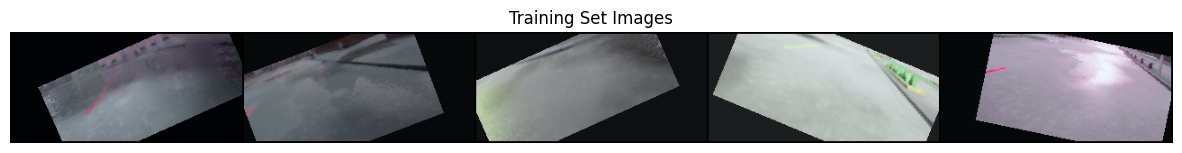

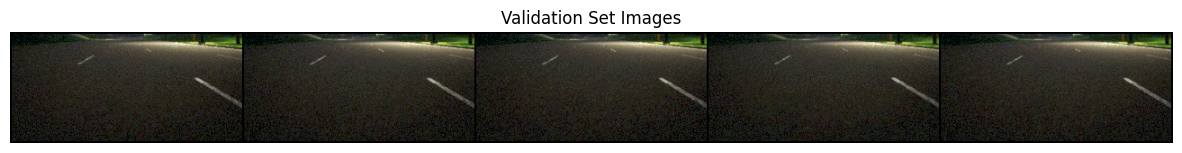

In [ ]:
def show_images(images, nrow=5, title=None):
    grid = make_grid(images, nrow=nrow, normalize=True)
    npimg = grid.numpy()
    plt.figure(figsize=(15, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def plot_images_from_loader(loader, title):
    # Get a batch of images
    dataiter = iter(loader)
    images, _ = next(dataiter)
    batch_size = images.shape[0]

    # Select 5 random indices
    random_indices = random.sample(range(batch_size), 5)
    random_images = images[random_indices]

    # Call the helper function to show images
    show_images(random_images, title=title)


# Assuming train_loader and val_loader are defined
plot_images_from_loader(train_loader, title="Training Set Images")
plot_images_from_loader(val_loader, title="Validation Set Images")

# Model

Neural Network

In [ ]:
# From: https://github.com/wzlxjtu/PositionalEncoding2D
class PositionalEncoding2d(nn.Module):
    def __init__(self, d_model, height, width):
        super(PositionalEncoding2d, self).__init__()
        if d_model % 4 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                            "odd dimension (got dim={:d})".format(d_model))
        pe = torch.zeros(d_model, height, width)
        # Each dimension use half of d_model
        d_model = int(d_model / 2)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                            -(math.log(10000.0) / d_model))
        pos_w = torch.arange(0., width).unsqueeze(1)
        pos_h = torch.arange(0., height).unsqueeze(1)
        pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe

In [ ]:
# Inspired by: https://github.com/reshalfahsi/separableconv-torch
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, bias):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, num_layers: int, pool: bool, short: bool):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.pooling = pool
        self.short = short

        self.inconv = nn.Sequential(
            SeparableConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=1, bias=False),
            nn.SELU()
        )

        layers = []
        for _ in range(num_layers - 1):
            layers.append(SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=1, bias=False))
            layers.append(nn.SELU())
        self.convlayers = nn.Sequential(*layers)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=kernel_size, stride=2, padding=1)
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False)
        else:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)

        self.sact = nn.SELU()

    def forward(self, x):
        out = self.inconv(x)
        out = self.convlayers(out)

        if self.pooling:
            out = self.pool(out)

        if self.short:
            shortcut = self.shortcut(x)
            out = out + shortcut
            out = self.sact(out)

        return out

In [ ]:
class AVModel(nn.Module):
    def __init__(self):
        super(AVModel, self).__init__()
        self.conv1 = SeparableConv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm = nn.LayerNorm(64)
        self.attention = nn.MultiheadAttention(embed_dim=64, num_heads=1, dropout=0.5, batch_first=True)
        self.scale = nn.Parameter(torch.zeros(1))
        self.act = nn.SELU()

        self.conv_layers = nn.Sequential(
            ResidualBlock(in_channels=64, out_channels=64, kernel_size=3, num_layers=4, pool=True, short=True),
            ResidualBlock(in_channels=64, out_channels=128, kernel_size=3, num_layers=4, pool=True, short=True),
            ResidualBlock(in_channels=128, out_channels=256, kernel_size=3, num_layers=4, pool=True, short=True),
            nn.Dropout2d(0.5),
        )

        self.dense_layers = nn.Sequential(
            nn.Linear(256, 100, bias=False),
            nn.SELU(),
            nn.Linear(100, 50, bias=False),
            nn.SELU(),
            nn.Linear(50, 10, bias=False),
            nn.SELU(),
            nn.Dropout(0.5),
        )

        self.output_layer = nn.Linear(10, 3)

    def forward(self, x):
        x = self.conv1(x)
        # batch_size, channels, height, width = x.size()
        # x_att = x.reshape(batch_size, channels, height * width).transpose(1, 2)
        # x_att = self.norm(x_att)
        # attention_output, _ = self.attention(x_att, x_att, x_att)
        # attention_output = attention_output.transpose(1, 2).reshape(batch_size, channels, height, width)
        # x = self.scale * attention_output + x
        x = self.act(x)

        x = self.conv_layers(x)
        x = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2) # GlobalAveragePooling2D
        x = self.dense_layers(x)
        out = self.output_layer(x)

        # steering_output = F.hardtanh(x[:, 0:1])
        # throttle_brake_output = F.hardtanh(x[:, 1:], min_val=0)
        # out = torch.cat((steering_output, throttle_brake_output), dim=1)
        return out

# Util

MFPE Loss

In [ ]:
class MFPELoss(nn.Module):
    def __init__(self):
        super(MFPELoss, self).__init__()

    def forward(self, input, target):
        error = input - target
        fourth_power_error = error ** 4
        mean_fourth_power_error = torch.mean(fourth_power_error)
        return mean_fourth_power_error

Early Stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

Autoclip

In [ ]:
# From: https://github.com/pseeth/autoclip/blob/master/autoclip.py
class AutoClip:
    def __init__(self, percentile):
        self.grad_history = []
        self.percentile = percentile

    def compute_grad_norm(self, model):
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)

        return total_norm

    def __call__(self, model):
        grad_norm = self.compute_grad_norm(model)
        self.grad_history.append(grad_norm)
        clip_value = np.percentile(self.grad_history, self.percentile)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

Model Checkpoint

In [ ]:
def save_checkpoint(model, optimizer, scheduler, num_epochs, train_losses, val_losses):
  checkpoint = {
          'epoch': num_epochs + 1,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'scheduler_state_dict': scheduler.state_dict(),
          'train_losses': train_losses,
          'val_losses': val_losses,
      }
  torch.save(checkpoint, '/content/drive/My Drive/AV Research/new_model_checkpoint.pt')

# Training Loop

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = AVModel().to(device)
num_epochs = 50
learning_rate = 5e-5
criterion = MFPELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1)
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=(num_epochs // 5))
early_stopping = EarlyStopping(patience=7)

torch.autograd.set_detect_anomaly(False)
torch.backends.cudnn.benchmark = True
scaler = torch.cuda.amp.GradScaler()
autoclipper = AutoClip(percentile=10)

writer = SummaryWriter()

train_losses = []
val_losses = []

print(summary(model, input_size=(batch_size, 3, 119 // 2, 256 // 2)))

def train_loop(train_loader, model, criterion, optimizer, device):
    size = len(train_loader.dataset)
    model.train()
    train_loss = 0.0
    num_batches = len(train_loader)

    # Training loop
    for batch, (inputs, targets) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
          outputs = model(inputs)
          loss = criterion(outputs, targets)

        train_loss += loss.item()
        scaler.scale(loss).backward()
        autoclipper(model)

        scaler.step(optimizer)
        scale = scaler.get_scale()
        scaler.update()
        skip_lr_sched = (scale != scaler.get_scale())

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(inputs)
            print(f"Training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss = train_loss / num_batches
    return train_loss, skip_lr_sched

def val_loop(val_loader, model, criterion, device):
    model.eval()
    val_loss = 0.0
    num_batches = len(val_loader)

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

    val_loss = val_loss / num_batches
    return val_loss

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss, skip_lr_sched = train_loop(train_loader, model, criterion, optimizer, device)
    val_loss = val_loop(val_loader, model, criterion, device)
    print(f"Train loss: {train_loss:>8f} - Val loss: {val_loss:>8f} \n")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)

    save_checkpoint(model, optimizer, scheduler, epoch, train_losses, val_losses)

    # if early_stopping.early_stop(val_loss):
    #     print(f"Early stopping after {epoch+1} epochs \n")
    #     print(f"Best val loss: {early_stopping.min_validation_loss} \n")
    #     break

    print("Last learning rate:", scheduler.get_last_lr())
    if not skip_lr_sched:
        scheduler.step()

writer.close()

Layer (type:depth-idx)                        Output Shape              Param #
AVModel                                       [32, 3]                   16,769
├─SeparableConv2d: 1-1                        [32, 64, 59, 128]         --
│    └─Conv2d: 2-1                            [32, 3, 59, 128]          27
│    └─Conv2d: 2-2                            [32, 64, 59, 128]         192
├─SELU: 1-2                                   [32, 64, 59, 128]         --
├─Sequential: 1-3                             [32, 256, 8, 16]          --
│    └─ResidualBlock: 2-3                     [32, 64, 30, 64]          --
│    │    └─Sequential: 3-1                   [32, 64, 59, 128]         4,672
│    │    └─Sequential: 3-2                   [32, 64, 59, 128]         14,016
│    │    └─MaxPool2d: 3-3                    [32, 64, 30, 64]          --
│    │    └─Conv2d: 3-4                       [32, 64, 30, 64]          4,096
│    │    └─SELU: 3-5                         [32, 64, 30, 64]          --
│    

  0%|          | 2/4350 [00:00<18:57,  3.82it/s]

Training loss: 0.088237  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:23,  6.82it/s]

Training loss: 0.031125  [ 3232/139199]


  5%|▍         | 202/4350 [00:29<10:14,  6.75it/s]

Training loss: 0.054121  [ 6432/139199]


  7%|▋         | 302/4350 [00:44<09:43,  6.94it/s]

Training loss: 0.052281  [ 9632/139199]


  9%|▉         | 402/4350 [00:59<09:46,  6.73it/s]

Training loss: 0.032371  [12832/139199]


 12%|█▏        | 502/4350 [01:13<09:04,  7.07it/s]

Training loss: 0.033159  [16032/139199]


 14%|█▍        | 602/4350 [01:28<08:57,  6.98it/s]

Training loss: 0.040630  [19232/139199]


 16%|█▌        | 702/4350 [01:42<08:51,  6.86it/s]

Training loss: 0.038785  [22432/139199]


 18%|█▊        | 802/4350 [01:57<08:35,  6.88it/s]

Training loss: 0.032396  [25632/139199]


 21%|██        | 902/4350 [02:11<08:10,  7.02it/s]

Training loss: 0.039355  [28832/139199]


 23%|██▎       | 1002/4350 [02:26<08:00,  6.96it/s]

Training loss: 0.035843  [32032/139199]


 25%|██▌       | 1102/4350 [02:40<08:03,  6.72it/s]

Training loss: 0.035133  [35232/139199]


 28%|██▊       | 1202/4350 [02:55<07:49,  6.70it/s]

Training loss: 0.034690  [38432/139199]


 30%|██▉       | 1302/4350 [03:10<07:48,  6.51it/s]

Training loss: 0.038933  [41632/139199]


 32%|███▏      | 1402/4350 [03:24<07:11,  6.84it/s]

Training loss: 0.041203  [44832/139199]


 35%|███▍      | 1502/4350 [03:40<08:58,  5.29it/s]

Training loss: 0.031945  [48032/139199]


 37%|███▋      | 1602/4350 [03:55<06:58,  6.57it/s]

Training loss: 0.034854  [51232/139199]


 39%|███▉      | 1702/4350 [04:11<07:20,  6.01it/s]

Training loss: 0.030825  [54432/139199]


 41%|████▏     | 1802/4350 [04:27<06:51,  6.19it/s]

Training loss: 0.029304  [57632/139199]


 44%|████▎     | 1902/4350 [04:43<06:07,  6.65it/s]

Training loss: 0.040728  [60832/139199]


 46%|████▌     | 2002/4350 [04:59<05:57,  6.57it/s]

Training loss: 0.025789  [64032/139199]


 48%|████▊     | 2102/4350 [05:15<06:19,  5.93it/s]

Training loss: 0.032720  [67232/139199]


 51%|█████     | 2202/4350 [05:31<05:14,  6.83it/s]

Training loss: 0.033274  [70432/139199]


 53%|█████▎    | 2302/4350 [05:47<05:13,  6.52it/s]

Training loss: 0.036831  [73632/139199]


 55%|█████▌    | 2402/4350 [06:02<04:53,  6.64it/s]

Training loss: 0.033154  [76832/139199]


 58%|█████▊    | 2502/4350 [06:17<04:48,  6.40it/s]

Training loss: 0.033807  [80032/139199]


 60%|█████▉    | 2602/4350 [06:32<04:23,  6.64it/s]

Training loss: 0.028296  [83232/139199]


 62%|██████▏   | 2702/4350 [06:48<04:18,  6.37it/s]

Training loss: 0.028892  [86432/139199]


 64%|██████▍   | 2802/4350 [07:03<03:50,  6.73it/s]

Training loss: 0.033969  [89632/139199]


 67%|██████▋   | 2902/4350 [07:18<03:35,  6.72it/s]

Training loss: 0.026438  [92832/139199]


 69%|██████▉   | 3002/4350 [07:33<03:18,  6.77it/s]

Training loss: 0.036486  [96032/139199]


 71%|███████▏  | 3102/4350 [07:48<03:08,  6.62it/s]

Training loss: 0.029382  [99232/139199]


 74%|███████▎  | 3202/4350 [08:03<02:51,  6.71it/s]

Training loss: 0.025407  [102432/139199]


 76%|███████▌  | 3302/4350 [08:18<02:36,  6.68it/s]

Training loss: 0.026536  [105632/139199]


 78%|███████▊  | 3402/4350 [08:33<02:23,  6.59it/s]

Training loss: 0.030120  [108832/139199]


 81%|████████  | 3502/4350 [08:48<02:19,  6.09it/s]

Training loss: 0.026792  [112032/139199]


 83%|████████▎ | 3602/4350 [09:03<01:48,  6.88it/s]

Training loss: 0.034533  [115232/139199]


 85%|████████▌ | 3702/4350 [09:18<01:37,  6.65it/s]

Training loss: 0.028091  [118432/139199]


 87%|████████▋ | 3802/4350 [09:33<01:19,  6.89it/s]

Training loss: 0.025892  [121632/139199]


 90%|████████▉ | 3902/4350 [09:47<01:04,  6.99it/s]

Training loss: 0.031534  [124832/139199]


 92%|█████████▏| 4002/4350 [10:02<00:51,  6.82it/s]

Training loss: 0.031068  [128032/139199]


 94%|█████████▍| 4102/4350 [10:16<00:35,  6.91it/s]

Training loss: 0.023756  [131232/139199]


 97%|█████████▋| 4202/4350 [10:31<00:22,  6.65it/s]

Training loss: 0.032113  [134432/139199]


 99%|█████████▉| 4302/4350 [10:46<00:07,  6.81it/s]

Training loss: 0.027303  [137632/139199]


100%|██████████| 4350/4350 [10:53<00:00,  6.66it/s]


Train loss: 0.034411 - Val loss: 0.022689 

Last learning rate: [5e-05]
Epoch 2
-------------------------------


  0%|          | 2/4350 [00:00<17:41,  4.10it/s]

Training loss: 0.028882  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:45,  6.58it/s]

Training loss: 0.027430  [ 3232/139199]


  5%|▍         | 202/4350 [00:29<09:51,  7.01it/s]

Training loss: 0.032878  [ 6432/139199]


  7%|▋         | 302/4350 [00:44<09:54,  6.81it/s]

Training loss: 0.024011  [ 9632/139199]


  9%|▉         | 402/4350 [00:58<09:34,  6.88it/s]

Training loss: 0.028113  [12832/139199]


 12%|█▏        | 502/4350 [01:13<09:27,  6.78it/s]

Training loss: 0.029083  [16032/139199]


 14%|█▍        | 602/4350 [01:28<09:19,  6.70it/s]

Training loss: 0.029287  [19232/139199]


 16%|█▌        | 702/4350 [01:42<08:54,  6.82it/s]

Training loss: 0.037556  [22432/139199]


 18%|█▊        | 802/4350 [01:57<08:40,  6.81it/s]

Training loss: 0.023180  [25632/139199]


 21%|██        | 902/4350 [02:12<08:10,  7.03it/s]

Training loss: 0.028403  [28832/139199]


 23%|██▎       | 1002/4350 [02:26<08:22,  6.66it/s]

Training loss: 0.026407  [32032/139199]


 25%|██▌       | 1102/4350 [02:41<07:48,  6.93it/s]

Training loss: 0.030400  [35232/139199]


 28%|██▊       | 1202/4350 [02:56<07:29,  7.00it/s]

Training loss: 0.026330  [38432/139199]


 30%|██▉       | 1302/4350 [03:10<07:15,  7.01it/s]

Training loss: 0.025140  [41632/139199]


 32%|███▏      | 1402/4350 [03:25<07:18,  6.73it/s]

Training loss: 0.025901  [44832/139199]


 35%|███▍      | 1502/4350 [03:40<06:54,  6.88it/s]

Training loss: 0.029389  [48032/139199]


 37%|███▋      | 1602/4350 [03:54<06:31,  7.01it/s]

Training loss: 0.035714  [51232/139199]


 39%|███▉      | 1702/4350 [04:09<06:18,  6.99it/s]

Training loss: 0.031358  [54432/139199]


 41%|████▏     | 1802/4350 [04:24<06:07,  6.94it/s]

Training loss: 0.027543  [57632/139199]


 44%|████▎     | 1902/4350 [04:38<06:02,  6.75it/s]

Training loss: 0.026766  [60832/139199]


 46%|████▌     | 2002/4350 [04:53<06:00,  6.51it/s]

Training loss: 0.032537  [64032/139199]


 48%|████▊     | 2102/4350 [05:08<05:19,  7.03it/s]

Training loss: 0.023349  [67232/139199]


 51%|█████     | 2202/4350 [05:23<05:11,  6.89it/s]

Training loss: 0.027085  [70432/139199]


 53%|█████▎    | 2302/4350 [05:37<04:53,  6.99it/s]

Training loss: 0.031759  [73632/139199]


 55%|█████▌    | 2402/4350 [05:52<04:51,  6.68it/s]

Training loss: 0.027383  [76832/139199]


 58%|█████▊    | 2502/4350 [06:07<04:25,  6.97it/s]

Training loss: 0.026048  [80032/139199]


 60%|█████▉    | 2602/4350 [06:21<04:10,  6.97it/s]

Training loss: 0.026072  [83232/139199]


 62%|██████▏   | 2702/4350 [06:36<04:00,  6.85it/s]

Training loss: 0.026469  [86432/139199]


 64%|██████▍   | 2802/4350 [06:51<03:45,  6.86it/s]

Training loss: 0.025056  [89632/139199]


 67%|██████▋   | 2902/4350 [07:05<03:33,  6.78it/s]

Training loss: 0.025789  [92832/139199]


 69%|██████▉   | 3002/4350 [07:20<03:18,  6.78it/s]

Training loss: 0.025317  [96032/139199]


 71%|███████▏  | 3102/4350 [07:35<03:01,  6.86it/s]

Training loss: 0.024735  [99232/139199]


 74%|███████▎  | 3202/4350 [07:49<02:51,  6.70it/s]

Training loss: 0.020325  [102432/139199]


 76%|███████▌  | 3302/4350 [08:04<02:32,  6.86it/s]

Training loss: 0.024866  [105632/139199]


 78%|███████▊  | 3402/4350 [08:19<02:18,  6.83it/s]

Training loss: 0.028534  [108832/139199]


 81%|████████  | 3502/4350 [08:34<02:06,  6.73it/s]

Training loss: 0.022468  [112032/139199]


 83%|████████▎ | 3602/4350 [08:49<01:47,  6.99it/s]

Training loss: 0.031041  [115232/139199]


 85%|████████▌ | 3702/4350 [09:03<01:34,  6.84it/s]

Training loss: 0.028412  [118432/139199]


 87%|████████▋ | 3802/4350 [09:18<01:20,  6.77it/s]

Training loss: 0.026150  [121632/139199]


 90%|████████▉ | 3902/4350 [09:33<01:05,  6.83it/s]

Training loss: 0.032219  [124832/139199]


 92%|█████████▏| 4002/4350 [09:47<00:50,  6.87it/s]

Training loss: 0.023100  [128032/139199]


 94%|█████████▍| 4102/4350 [10:02<00:35,  6.96it/s]

Training loss: 0.029765  [131232/139199]


 97%|█████████▋| 4202/4350 [10:17<00:22,  6.61it/s]

Training loss: 0.030099  [134432/139199]


 99%|█████████▉| 4302/4350 [10:31<00:07,  6.83it/s]

Training loss: 0.025720  [137632/139199]


100%|██████████| 4350/4350 [10:38<00:00,  6.81it/s]


Train loss: 0.027772 - Val loss: 0.022757 

Last learning rate: [4.877641290737884e-05]
Epoch 3
-------------------------------


  0%|          | 2/4350 [00:00<18:16,  3.96it/s]

Training loss: 0.024688  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:41,  6.62it/s]

Training loss: 0.027217  [ 3232/139199]


  5%|▍         | 202/4350 [00:30<10:00,  6.90it/s]

Training loss: 0.027500  [ 6432/139199]


  7%|▋         | 302/4350 [00:44<09:36,  7.02it/s]

Training loss: 0.031059  [ 9632/139199]


  9%|▉         | 402/4350 [00:59<09:39,  6.82it/s]

Training loss: 0.027124  [12832/139199]


 12%|█▏        | 502/4350 [01:13<09:07,  7.03it/s]

Training loss: 0.027950  [16032/139199]


 14%|█▍        | 602/4350 [01:28<09:17,  6.73it/s]

Training loss: 0.026986  [19232/139199]


 16%|█▌        | 702/4350 [01:43<08:37,  7.05it/s]

Training loss: 0.028072  [22432/139199]


 18%|█▊        | 802/4350 [01:58<09:06,  6.49it/s]

Training loss: 0.030494  [25632/139199]


 21%|██        | 902/4350 [02:12<08:09,  7.04it/s]

Training loss: 0.029169  [28832/139199]


 23%|██▎       | 1002/4350 [02:27<08:03,  6.93it/s]

Training loss: 0.027456  [32032/139199]


 25%|██▌       | 1102/4350 [02:42<08:01,  6.74it/s]

Training loss: 0.024398  [35232/139199]


 28%|██▊       | 1202/4350 [02:56<07:29,  7.00it/s]

Training loss: 0.023825  [38432/139199]


 30%|██▉       | 1302/4350 [03:11<07:13,  7.04it/s]

Training loss: 0.033067  [41632/139199]


 32%|███▏      | 1402/4350 [03:25<07:03,  6.96it/s]

Training loss: 0.025189  [44832/139199]


 35%|███▍      | 1502/4350 [03:40<07:00,  6.77it/s]

Training loss: 0.024563  [48032/139199]


 37%|███▋      | 1602/4350 [03:54<06:43,  6.82it/s]

Training loss: 0.025335  [51232/139199]


 39%|███▉      | 1702/4350 [04:09<06:24,  6.90it/s]

Training loss: 0.029954  [54432/139199]


 41%|████▏     | 1802/4350 [04:23<06:03,  7.01it/s]

Training loss: 0.026339  [57632/139199]


 44%|████▎     | 1902/4350 [04:38<05:51,  6.96it/s]

Training loss: 0.024986  [60832/139199]


 46%|████▌     | 2002/4350 [04:53<05:57,  6.57it/s]

Training loss: 0.032677  [64032/139199]


 48%|████▊     | 2102/4350 [05:08<05:31,  6.77it/s]

Training loss: 0.022139  [67232/139199]


 51%|█████     | 2202/4350 [05:22<05:17,  6.76it/s]

Training loss: 0.035057  [70432/139199]


 53%|█████▎    | 2302/4350 [05:37<04:54,  6.95it/s]

Training loss: 0.031420  [73632/139199]


 55%|█████▌    | 2402/4350 [05:52<04:47,  6.78it/s]

Training loss: 0.025350  [76832/139199]


 58%|█████▊    | 2502/4350 [06:06<04:39,  6.62it/s]

Training loss: 0.027885  [80032/139199]


 60%|█████▉    | 2602/4350 [06:21<04:13,  6.91it/s]

Training loss: 0.032204  [83232/139199]


 62%|██████▏   | 2702/4350 [06:36<03:58,  6.92it/s]

Training loss: 0.021879  [86432/139199]


 64%|██████▍   | 2802/4350 [06:51<03:40,  7.02it/s]

Training loss: 0.027724  [89632/139199]


 67%|██████▋   | 2902/4350 [07:06<03:34,  6.75it/s]

Training loss: 0.024241  [92832/139199]


 69%|██████▉   | 3002/4350 [07:20<03:29,  6.45it/s]

Training loss: 0.029163  [96032/139199]


 71%|███████▏  | 3102/4350 [07:35<03:07,  6.67it/s]

Training loss: 0.032052  [99232/139199]


 74%|███████▎  | 3202/4350 [07:49<02:45,  6.92it/s]

Training loss: 0.025191  [102432/139199]


 76%|███████▌  | 3302/4350 [08:04<02:31,  6.91it/s]

Training loss: 0.026292  [105632/139199]


 78%|███████▊  | 3402/4350 [08:19<02:17,  6.89it/s]

Training loss: 0.033650  [108832/139199]


 81%|████████  | 3502/4350 [08:33<02:09,  6.53it/s]

Training loss: 0.025161  [112032/139199]


 83%|████████▎ | 3602/4350 [08:48<01:46,  7.04it/s]

Training loss: 0.026369  [115232/139199]


 85%|████████▌ | 3702/4350 [09:03<01:34,  6.83it/s]

Training loss: 0.020879  [118432/139199]


 87%|████████▋ | 3802/4350 [09:18<01:21,  6.72it/s]

Training loss: 0.022031  [121632/139199]


 90%|████████▉ | 3902/4350 [09:32<01:06,  6.77it/s]

Training loss: 0.028625  [124832/139199]


 92%|█████████▏| 4002/4350 [09:47<00:51,  6.71it/s]

Training loss: 0.029086  [128032/139199]


 94%|█████████▍| 4102/4350 [10:02<00:37,  6.59it/s]

Training loss: 0.029216  [131232/139199]


 97%|█████████▋| 4202/4350 [10:17<00:21,  6.92it/s]

Training loss: 0.026136  [134432/139199]


 99%|█████████▉| 4302/4350 [10:31<00:07,  6.67it/s]

Training loss: 0.023140  [137632/139199]


100%|██████████| 4350/4350 [10:39<00:00,  6.81it/s]


Train loss: 0.026038 - Val loss: 0.022080 

Last learning rate: [4.522542485937369e-05]
Epoch 4
-------------------------------


  0%|          | 2/4350 [00:00<17:33,  4.13it/s]

Training loss: 0.025112  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:27,  6.77it/s]

Training loss: 0.026255  [ 3232/139199]


  5%|▍         | 202/4350 [00:30<10:27,  6.61it/s]

Training loss: 0.024214  [ 6432/139199]


  7%|▋         | 302/4350 [00:45<09:44,  6.93it/s]

Training loss: 0.026410  [ 9632/139199]


  9%|▉         | 402/4350 [00:59<09:48,  6.70it/s]

Training loss: 0.024552  [12832/139199]


 12%|█▏        | 502/4350 [01:14<09:12,  6.97it/s]

Training loss: 0.023843  [16032/139199]


 14%|█▍        | 602/4350 [01:28<09:04,  6.88it/s]

Training loss: 0.024103  [19232/139199]


 16%|█▌        | 702/4350 [01:43<08:50,  6.88it/s]

Training loss: 0.025186  [22432/139199]


 18%|█▊        | 802/4350 [01:58<08:32,  6.92it/s]

Training loss: 0.025147  [25632/139199]


 21%|██        | 902/4350 [02:12<08:23,  6.84it/s]

Training loss: 0.027649  [28832/139199]


 23%|██▎       | 1002/4350 [02:27<08:17,  6.73it/s]

Training loss: 0.021459  [32032/139199]


 25%|██▌       | 1102/4350 [02:42<08:05,  6.69it/s]

Training loss: 0.025229  [35232/139199]


 28%|██▊       | 1202/4350 [02:56<07:41,  6.83it/s]

Training loss: 0.023869  [38432/139199]


 30%|██▉       | 1302/4350 [03:11<07:31,  6.75it/s]

Training loss: 0.026515  [41632/139199]


 32%|███▏      | 1402/4350 [03:26<07:06,  6.90it/s]

Training loss: 0.026588  [44832/139199]


 35%|███▍      | 1502/4350 [03:41<06:55,  6.86it/s]

Training loss: 0.027014  [48032/139199]


 37%|███▋      | 1602/4350 [03:55<06:44,  6.79it/s]

Training loss: 0.025269  [51232/139199]


 39%|███▉      | 1702/4350 [04:10<06:26,  6.85it/s]

Training loss: 0.027188  [54432/139199]


 41%|████▏     | 1802/4350 [04:25<06:22,  6.67it/s]

Training loss: 0.029911  [57632/139199]


 44%|████▎     | 1902/4350 [04:40<05:56,  6.87it/s]

Training loss: 0.035465  [60832/139199]


 46%|████▌     | 2002/4350 [04:54<05:50,  6.69it/s]

Training loss: 0.024106  [64032/139199]


 48%|████▊     | 2102/4350 [05:09<05:34,  6.71it/s]

Training loss: 0.021191  [67232/139199]


 51%|█████     | 2202/4350 [05:24<05:15,  6.80it/s]

Training loss: 0.024071  [70432/139199]


 53%|█████▎    | 2302/4350 [05:39<05:05,  6.70it/s]

Training loss: 0.022887  [73632/139199]


 55%|█████▌    | 2402/4350 [05:53<04:54,  6.60it/s]

Training loss: 0.022963  [76832/139199]


 58%|█████▊    | 2502/4350 [06:08<04:42,  6.55it/s]

Training loss: 0.029038  [80032/139199]


 60%|█████▉    | 2602/4350 [06:23<04:18,  6.77it/s]

Training loss: 0.024750  [83232/139199]


 62%|██████▏   | 2702/4350 [06:38<03:55,  6.99it/s]

Training loss: 0.024203  [86432/139199]


 64%|██████▍   | 2802/4350 [06:52<03:44,  6.91it/s]

Training loss: 0.020808  [89632/139199]


 67%|██████▋   | 2902/4350 [07:07<03:32,  6.80it/s]

Training loss: 0.026566  [92832/139199]


 69%|██████▉   | 3002/4350 [07:22<03:23,  6.61it/s]

Training loss: 0.029074  [96032/139199]


 71%|███████▏  | 3102/4350 [07:37<03:06,  6.68it/s]

Training loss: 0.026555  [99232/139199]


 74%|███████▎  | 3202/4350 [07:51<02:50,  6.74it/s]

Training loss: 0.028573  [102432/139199]


 76%|███████▌  | 3302/4350 [08:06<02:36,  6.69it/s]

Training loss: 0.024875  [105632/139199]


 78%|███████▊  | 3402/4350 [08:21<02:16,  6.93it/s]

Training loss: 0.023153  [108832/139199]


 81%|████████  | 3502/4350 [08:36<02:06,  6.70it/s]

Training loss: 0.026823  [112032/139199]


 83%|████████▎ | 3602/4350 [08:50<01:50,  6.79it/s]

Training loss: 0.029620  [115232/139199]


 85%|████████▌ | 3702/4350 [09:05<01:32,  7.03it/s]

Training loss: 0.026449  [118432/139199]


 87%|████████▋ | 3802/4350 [09:20<01:18,  7.00it/s]

Training loss: 0.024464  [121632/139199]


 90%|████████▉ | 3902/4350 [09:34<01:04,  6.97it/s]

Training loss: 0.025705  [124832/139199]


 92%|█████████▏| 4002/4350 [09:49<00:51,  6.72it/s]

Training loss: 0.025568  [128032/139199]


 94%|█████████▍| 4102/4350 [10:04<00:36,  6.81it/s]

Training loss: 0.025692  [131232/139199]


 97%|█████████▋| 4202/4350 [10:19<00:22,  6.70it/s]

Training loss: 0.027104  [134432/139199]


 99%|█████████▉| 4302/4350 [10:34<00:07,  6.83it/s]

Training loss: 0.024035  [137632/139199]


100%|██████████| 4350/4350 [10:41<00:00,  6.78it/s]


Train loss: 0.025124 - Val loss: 0.020102 

Last learning rate: [3.969463130731183e-05]
Epoch 5
-------------------------------


  0%|          | 2/4350 [00:00<17:25,  4.16it/s]

Training loss: 0.028499  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:11,  6.95it/s]

Training loss: 0.026155  [ 3232/139199]


  5%|▍         | 202/4350 [00:29<10:12,  6.78it/s]

Training loss: 0.024062  [ 6432/139199]


  7%|▋         | 302/4350 [00:44<09:56,  6.79it/s]

Training loss: 0.020575  [ 9632/139199]


  9%|▉         | 402/4350 [00:59<09:25,  6.98it/s]

Training loss: 0.025518  [12832/139199]


 12%|█▏        | 502/4350 [01:14<09:17,  6.91it/s]

Training loss: 0.025341  [16032/139199]


 14%|█▍        | 602/4350 [01:29<09:29,  6.59it/s]

Training loss: 0.019843  [19232/139199]


 16%|█▌        | 702/4350 [01:43<09:02,  6.73it/s]

Training loss: 0.022841  [22432/139199]


 18%|█▊        | 802/4350 [01:58<08:27,  6.99it/s]

Training loss: 0.023696  [25632/139199]


 21%|██        | 902/4350 [02:13<08:50,  6.50it/s]

Training loss: 0.025601  [28832/139199]


 23%|██▎       | 1002/4350 [02:27<08:18,  6.72it/s]

Training loss: 0.024206  [32032/139199]


 25%|██▌       | 1102/4350 [02:42<08:00,  6.76it/s]

Training loss: 0.028666  [35232/139199]


 28%|██▊       | 1202/4350 [02:57<07:49,  6.70it/s]

Training loss: 0.031371  [38432/139199]


 30%|██▉       | 1302/4350 [03:11<07:18,  6.95it/s]

Training loss: 0.023943  [41632/139199]


 32%|███▏      | 1402/4350 [03:26<07:20,  6.69it/s]

Training loss: 0.022772  [44832/139199]


 35%|███▍      | 1502/4350 [03:41<07:04,  6.71it/s]

Training loss: 0.028905  [48032/139199]


 37%|███▋      | 1602/4350 [03:56<06:57,  6.59it/s]

Training loss: 0.023175  [51232/139199]


 39%|███▉      | 1702/4350 [04:11<06:29,  6.80it/s]

Training loss: 0.024551  [54432/139199]


 41%|████▏     | 1802/4350 [04:26<06:11,  6.85it/s]

Training loss: 0.021187  [57632/139199]


 44%|████▎     | 1902/4350 [04:40<05:56,  6.87it/s]

Training loss: 0.024912  [60832/139199]


 46%|████▌     | 2002/4350 [04:55<05:40,  6.90it/s]

Training loss: 0.019610  [64032/139199]


 48%|████▊     | 2102/4350 [05:10<05:24,  6.93it/s]

Training loss: 0.026252  [67232/139199]


 51%|█████     | 2202/4350 [05:25<05:17,  6.76it/s]

Training loss: 0.020121  [70432/139199]


 53%|█████▎    | 2302/4350 [05:39<04:57,  6.90it/s]

Training loss: 0.026090  [73632/139199]


 55%|█████▌    | 2402/4350 [05:54<04:49,  6.74it/s]

Training loss: 0.024447  [76832/139199]


 58%|█████▊    | 2502/4350 [06:09<04:39,  6.60it/s]

Training loss: 0.026591  [80032/139199]


 60%|█████▉    | 2602/4350 [06:23<04:17,  6.79it/s]

Training loss: 0.026724  [83232/139199]


 62%|██████▏   | 2702/4350 [06:38<04:09,  6.61it/s]

Training loss: 0.022177  [86432/139199]


 64%|██████▍   | 2802/4350 [06:53<03:44,  6.90it/s]

Training loss: 0.021716  [89632/139199]


 67%|██████▋   | 2902/4350 [07:08<03:30,  6.89it/s]

Training loss: 0.019270  [92832/139199]


 69%|██████▉   | 3002/4350 [07:22<03:23,  6.63it/s]

Training loss: 0.028691  [96032/139199]


 71%|███████▏  | 3102/4350 [07:37<02:59,  6.97it/s]

Training loss: 0.026933  [99232/139199]


 74%|███████▎  | 3202/4350 [07:52<02:49,  6.76it/s]

Training loss: 0.026815  [102432/139199]


 76%|███████▌  | 3302/4350 [08:07<02:31,  6.91it/s]

Training loss: 0.028035  [105632/139199]


 78%|███████▊  | 3402/4350 [08:22<02:19,  6.81it/s]

Training loss: 0.026624  [108832/139199]


 81%|████████  | 3502/4350 [08:37<02:06,  6.71it/s]

Training loss: 0.022003  [112032/139199]


 83%|████████▎ | 3602/4350 [08:51<01:48,  6.88it/s]

Training loss: 0.021391  [115232/139199]


 85%|████████▌ | 3702/4350 [09:06<01:37,  6.67it/s]

Training loss: 0.022759  [118432/139199]


 87%|████████▋ | 3802/4350 [09:21<01:19,  6.89it/s]

Training loss: 0.029103  [121632/139199]


 90%|████████▉ | 3902/4350 [09:36<01:07,  6.66it/s]

Training loss: 0.023264  [124832/139199]


 92%|█████████▏| 4002/4350 [09:51<00:51,  6.75it/s]

Training loss: 0.025417  [128032/139199]


 94%|█████████▍| 4102/4350 [10:05<00:36,  6.77it/s]

Training loss: 0.019636  [131232/139199]


 97%|█████████▋| 4202/4350 [10:20<00:22,  6.63it/s]

Training loss: 0.023909  [134432/139199]


 99%|█████████▉| 4302/4350 [10:35<00:07,  6.70it/s]

Training loss: 0.028600  [137632/139199]


100%|██████████| 4350/4350 [10:42<00:00,  6.77it/s]


Train loss: 0.024198 - Val loss: 0.020629 

Last learning rate: [3.272542485937369e-05]
Epoch 6
-------------------------------


  0%|          | 2/4350 [00:00<17:42,  4.09it/s]

Training loss: 0.022677  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:49,  6.54it/s]

Training loss: 0.026733  [ 3232/139199]


  5%|▍         | 202/4350 [00:30<10:14,  6.75it/s]

Training loss: 0.024766  [ 6432/139199]


  7%|▋         | 302/4350 [00:44<09:46,  6.91it/s]

Training loss: 0.030074  [ 9632/139199]


  9%|▉         | 402/4350 [00:59<09:39,  6.81it/s]

Training loss: 0.023865  [12832/139199]


 12%|█▏        | 502/4350 [01:14<09:14,  6.93it/s]

Training loss: 0.026609  [16032/139199]


 14%|█▍        | 602/4350 [01:29<09:12,  6.79it/s]

Training loss: 0.021038  [19232/139199]


 16%|█▌        | 702/4350 [01:43<08:56,  6.80it/s]

Training loss: 0.021545  [22432/139199]


 18%|█▊        | 802/4350 [01:58<08:32,  6.92it/s]

Training loss: 0.022581  [25632/139199]


 21%|██        | 902/4350 [02:13<08:16,  6.95it/s]

Training loss: 0.021416  [28832/139199]


 23%|██▎       | 1002/4350 [02:28<08:18,  6.72it/s]

Training loss: 0.022544  [32032/139199]


 25%|██▌       | 1102/4350 [02:43<08:23,  6.45it/s]

Training loss: 0.021651  [35232/139199]


 28%|██▊       | 1202/4350 [02:57<07:43,  6.79it/s]

Training loss: 0.025272  [38432/139199]


 30%|██▉       | 1302/4350 [03:12<07:28,  6.80it/s]

Training loss: 0.021524  [41632/139199]


 32%|███▏      | 1402/4350 [03:27<07:10,  6.85it/s]

Training loss: 0.019259  [44832/139199]


 35%|███▍      | 1502/4350 [03:42<07:16,  6.52it/s]

Training loss: 0.027464  [48032/139199]


 37%|███▋      | 1602/4350 [03:57<06:46,  6.76it/s]

Training loss: 0.022962  [51232/139199]


 39%|███▉      | 1702/4350 [04:11<06:24,  6.88it/s]

Training loss: 0.024686  [54432/139199]


 41%|████▏     | 1802/4350 [04:26<06:08,  6.92it/s]

Training loss: 0.019819  [57632/139199]


 44%|████▎     | 1902/4350 [04:40<05:50,  6.99it/s]

Training loss: 0.027205  [60832/139199]


 46%|████▌     | 2002/4350 [04:55<05:41,  6.88it/s]

Training loss: 0.024693  [64032/139199]


 48%|████▊     | 2102/4350 [05:10<05:26,  6.89it/s]

Training loss: 0.023078  [67232/139199]


 51%|█████     | 2202/4350 [05:24<05:11,  6.89it/s]

Training loss: 0.018727  [70432/139199]


 53%|█████▎    | 2302/4350 [05:39<04:57,  6.87it/s]

Training loss: 0.027655  [73632/139199]


 55%|█████▌    | 2402/4350 [05:53<04:40,  6.96it/s]

Training loss: 0.020785  [76832/139199]


 58%|█████▊    | 2502/4350 [06:08<04:33,  6.76it/s]

Training loss: 0.022611  [80032/139199]


 60%|█████▉    | 2602/4350 [06:23<04:17,  6.79it/s]

Training loss: 0.019934  [83232/139199]


 62%|██████▏   | 2702/4350 [06:37<04:03,  6.76it/s]

Training loss: 0.022232  [86432/139199]


 64%|██████▍   | 2802/4350 [06:52<03:42,  6.97it/s]

Training loss: 0.024432  [89632/139199]


 67%|██████▋   | 2902/4350 [07:06<03:29,  6.91it/s]

Training loss: 0.031452  [92832/139199]


 69%|██████▉   | 3002/4350 [07:21<03:16,  6.85it/s]

Training loss: 0.020779  [96032/139199]


 71%|███████▏  | 3102/4350 [07:36<02:59,  6.96it/s]

Training loss: 0.019595  [99232/139199]


 74%|███████▎  | 3202/4350 [07:50<02:49,  6.78it/s]

Training loss: 0.020491  [102432/139199]


 76%|███████▌  | 3302/4350 [08:05<02:31,  6.91it/s]

Training loss: 0.024805  [105632/139199]


 78%|███████▊  | 3402/4350 [08:20<02:19,  6.82it/s]

Training loss: 0.021899  [108832/139199]


 81%|████████  | 3502/4350 [08:34<02:08,  6.58it/s]

Training loss: 0.024898  [112032/139199]


 83%|████████▎ | 3602/4350 [08:49<01:51,  6.73it/s]

Training loss: 0.023345  [115232/139199]


 85%|████████▌ | 3702/4350 [09:03<01:32,  7.02it/s]

Training loss: 0.023877  [118432/139199]


 87%|████████▋ | 3802/4350 [09:18<01:19,  6.92it/s]

Training loss: 0.026233  [121632/139199]


 90%|████████▉ | 3902/4350 [09:32<01:04,  6.92it/s]

Training loss: 0.017338  [124832/139199]


 92%|█████████▏| 4002/4350 [09:47<00:52,  6.66it/s]

Training loss: 0.026824  [128032/139199]


 94%|█████████▍| 4102/4350 [10:02<00:36,  6.80it/s]

Training loss: 0.022158  [131232/139199]


 97%|█████████▋| 4202/4350 [10:16<00:21,  6.86it/s]

Training loss: 0.021158  [134432/139199]


 99%|█████████▉| 4302/4350 [10:31<00:06,  6.90it/s]

Training loss: 0.026017  [137632/139199]


100%|██████████| 4350/4350 [10:38<00:00,  6.82it/s]


Train loss: 0.022957 - Val loss: 0.019944 

Last learning rate: [2.5e-05]
Epoch 7
-------------------------------


  0%|          | 2/4350 [00:00<17:21,  4.17it/s]

Training loss: 0.024460  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:26,  6.79it/s]

Training loss: 0.026791  [ 3232/139199]


  5%|▍         | 202/4350 [00:30<09:56,  6.95it/s]

Training loss: 0.020334  [ 6432/139199]


  7%|▋         | 302/4350 [00:44<09:56,  6.79it/s]

Training loss: 0.021283  [ 9632/139199]


  9%|▉         | 402/4350 [00:59<09:40,  6.80it/s]

Training loss: 0.022085  [12832/139199]


 12%|█▏        | 502/4350 [01:14<09:28,  6.77it/s]

Training loss: 0.016931  [16032/139199]


 14%|█▍        | 602/4350 [01:29<09:32,  6.55it/s]

Training loss: 0.021934  [19232/139199]


 16%|█▌        | 702/4350 [01:44<09:05,  6.69it/s]

Training loss: 0.021736  [22432/139199]


 18%|█▊        | 802/4350 [01:58<08:48,  6.71it/s]

Training loss: 0.022258  [25632/139199]


 21%|██        | 902/4350 [02:13<08:21,  6.88it/s]

Training loss: 0.019659  [28832/139199]


 23%|██▎       | 1002/4350 [02:28<08:19,  6.71it/s]

Training loss: 0.025125  [32032/139199]


 25%|██▌       | 1102/4350 [02:43<07:51,  6.89it/s]

Training loss: 0.020531  [35232/139199]


 28%|██▊       | 1202/4350 [02:57<07:52,  6.66it/s]

Training loss: 0.023385  [38432/139199]


 30%|██▉       | 1302/4350 [03:12<07:24,  6.86it/s]

Training loss: 0.023554  [41632/139199]


 32%|███▏      | 1402/4350 [03:26<07:02,  6.98it/s]

Training loss: 0.020018  [44832/139199]


 35%|███▍      | 1502/4350 [03:41<06:56,  6.84it/s]

Training loss: 0.026454  [48032/139199]


 37%|███▋      | 1602/4350 [03:56<06:31,  7.02it/s]

Training loss: 0.018131  [51232/139199]


 39%|███▉      | 1702/4350 [04:10<06:33,  6.74it/s]

Training loss: 0.021418  [54432/139199]


 41%|████▏     | 1802/4350 [04:25<06:07,  6.93it/s]

Training loss: 0.020602  [57632/139199]


 44%|████▎     | 1902/4350 [04:40<05:47,  7.04it/s]

Training loss: 0.018303  [60832/139199]


 46%|████▌     | 2002/4350 [04:54<05:40,  6.90it/s]

Training loss: 0.021525  [64032/139199]


 48%|████▊     | 2102/4350 [05:09<05:25,  6.90it/s]

Training loss: 0.023323  [67232/139199]


 51%|█████     | 2202/4350 [05:24<05:41,  6.30it/s]

Training loss: 0.018842  [70432/139199]


 53%|█████▎    | 2302/4350 [05:38<05:03,  6.75it/s]

Training loss: 0.024852  [73632/139199]


 55%|█████▌    | 2402/4350 [05:53<04:41,  6.92it/s]

Training loss: 0.021669  [76832/139199]


 58%|█████▊    | 2502/4350 [06:07<04:23,  7.01it/s]

Training loss: 0.017639  [80032/139199]


 60%|█████▉    | 2602/4350 [06:22<04:14,  6.86it/s]

Training loss: 0.020540  [83232/139199]


 62%|██████▏   | 2702/4350 [06:37<04:02,  6.80it/s]

Training loss: 0.025934  [86432/139199]


 64%|██████▍   | 2802/4350 [06:51<03:41,  6.98it/s]

Training loss: 0.021949  [89632/139199]


 67%|██████▋   | 2902/4350 [07:06<03:31,  6.86it/s]

Training loss: 0.021452  [92832/139199]


 69%|██████▉   | 3002/4350 [07:20<03:12,  7.01it/s]

Training loss: 0.023478  [96032/139199]


 71%|███████▏  | 3102/4350 [07:35<03:07,  6.66it/s]

Training loss: 0.018272  [99232/139199]


 74%|███████▎  | 3202/4350 [07:50<02:48,  6.81it/s]

Training loss: 0.020171  [102432/139199]


 76%|███████▌  | 3302/4350 [08:05<02:36,  6.70it/s]

Training loss: 0.021566  [105632/139199]


 78%|███████▊  | 3402/4350 [08:19<02:16,  6.96it/s]

Training loss: 0.022659  [108832/139199]


 81%|████████  | 3502/4350 [08:34<02:00,  7.01it/s]

Training loss: 0.022275  [112032/139199]


 83%|████████▎ | 3602/4350 [08:48<01:50,  6.75it/s]

Training loss: 0.024679  [115232/139199]


 85%|████████▌ | 3702/4350 [09:03<01:36,  6.74it/s]

Training loss: 0.020025  [118432/139199]


 87%|████████▋ | 3802/4350 [09:18<01:21,  6.76it/s]

Training loss: 0.026093  [121632/139199]


 90%|████████▉ | 3902/4350 [09:32<01:04,  6.91it/s]

Training loss: 0.020685  [124832/139199]


 92%|█████████▏| 4002/4350 [09:47<00:50,  6.90it/s]

Training loss: 0.015476  [128032/139199]


 94%|█████████▍| 4102/4350 [10:02<00:37,  6.67it/s]

Training loss: 0.017070  [131232/139199]


 97%|█████████▋| 4202/4350 [10:16<00:21,  6.89it/s]

Training loss: 0.020811  [134432/139199]


 99%|█████████▉| 4302/4350 [10:31<00:06,  6.89it/s]

Training loss: 0.018532  [137632/139199]


100%|██████████| 4350/4350 [10:38<00:00,  6.81it/s]


Train loss: 0.022085 - Val loss: 0.020487 

Last learning rate: [1.7274575140626318e-05]
Epoch 8
-------------------------------


  0%|          | 2/4350 [00:00<17:25,  4.16it/s]

Training loss: 0.025077  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:14,  6.91it/s]

Training loss: 0.017118  [ 3232/139199]


  5%|▍         | 202/4350 [00:29<09:54,  6.98it/s]

Training loss: 0.021043  [ 6432/139199]


  7%|▋         | 302/4350 [00:44<10:22,  6.50it/s]

Training loss: 0.024759  [ 9632/139199]


  9%|▉         | 402/4350 [00:59<10:03,  6.55it/s]

Training loss: 0.017301  [12832/139199]


 12%|█▏        | 502/4350 [01:13<09:32,  6.73it/s]

Training loss: 0.025378  [16032/139199]


 14%|█▍        | 602/4350 [01:28<09:03,  6.89it/s]

Training loss: 0.020775  [19232/139199]


 16%|█▌        | 702/4350 [01:43<08:41,  6.99it/s]

Training loss: 0.024414  [22432/139199]


 18%|█▊        | 802/4350 [01:57<08:49,  6.69it/s]

Training loss: 0.023917  [25632/139199]


 21%|██        | 902/4350 [02:12<08:28,  6.77it/s]

Training loss: 0.023577  [28832/139199]


 23%|██▎       | 1002/4350 [02:26<07:57,  7.01it/s]

Training loss: 0.022334  [32032/139199]


 25%|██▌       | 1102/4350 [02:41<07:43,  7.01it/s]

Training loss: 0.019512  [35232/139199]


 28%|██▊       | 1202/4350 [02:55<07:48,  6.72it/s]

Training loss: 0.016089  [38432/139199]


 30%|██▉       | 1302/4350 [03:10<07:28,  6.80it/s]

Training loss: 0.023088  [41632/139199]


 32%|███▏      | 1402/4350 [03:25<07:12,  6.81it/s]

Training loss: 0.015925  [44832/139199]


 35%|███▍      | 1502/4350 [03:39<07:02,  6.73it/s]

Training loss: 0.022272  [48032/139199]


 37%|███▋      | 1602/4350 [03:54<06:32,  7.00it/s]

Training loss: 0.024344  [51232/139199]


 39%|███▉      | 1702/4350 [04:09<06:19,  6.98it/s]

Training loss: 0.023568  [54432/139199]


 41%|████▏     | 1802/4350 [04:23<06:25,  6.61it/s]

Training loss: 0.028528  [57632/139199]


 44%|████▎     | 1902/4350 [04:38<05:53,  6.93it/s]

Training loss: 0.025182  [60832/139199]


 46%|████▌     | 2002/4350 [04:53<05:42,  6.87it/s]

Training loss: 0.019354  [64032/139199]


 48%|████▊     | 2102/4350 [05:07<05:29,  6.82it/s]

Training loss: 0.022370  [67232/139199]


 51%|█████     | 2202/4350 [05:22<05:14,  6.83it/s]

Training loss: 0.022436  [70432/139199]


 53%|█████▎    | 2302/4350 [05:37<04:53,  6.98it/s]

Training loss: 0.020297  [73632/139199]


 55%|█████▌    | 2402/4350 [05:51<04:42,  6.89it/s]

Training loss: 0.018508  [76832/139199]


 58%|█████▊    | 2502/4350 [06:06<04:25,  6.95it/s]

Training loss: 0.020406  [80032/139199]


 60%|█████▉    | 2602/4350 [06:21<04:13,  6.89it/s]

Training loss: 0.023075  [83232/139199]


 62%|██████▏   | 2702/4350 [06:35<04:02,  6.81it/s]

Training loss: 0.022377  [86432/139199]


 64%|██████▍   | 2802/4350 [06:50<03:49,  6.74it/s]

Training loss: 0.022181  [89632/139199]


 67%|██████▋   | 2902/4350 [07:05<03:33,  6.77it/s]

Training loss: 0.022876  [92832/139199]


 69%|██████▉   | 3002/4350 [07:19<03:15,  6.90it/s]

Training loss: 0.026054  [96032/139199]


 71%|███████▏  | 3102/4350 [07:34<02:59,  6.94it/s]

Training loss: 0.020091  [99232/139199]


 74%|███████▎  | 3202/4350 [07:49<02:50,  6.74it/s]

Training loss: 0.017778  [102432/139199]


 76%|███████▌  | 3302/4350 [08:03<02:37,  6.65it/s]

Training loss: 0.025019  [105632/139199]


 78%|███████▊  | 3402/4350 [08:18<02:20,  6.77it/s]

Training loss: 0.028910  [108832/139199]


 81%|████████  | 3502/4350 [08:33<02:03,  6.87it/s]

Training loss: 0.026781  [112032/139199]


 83%|████████▎ | 3602/4350 [08:47<01:49,  6.81it/s]

Training loss: 0.018031  [115232/139199]


 85%|████████▌ | 3702/4350 [09:02<01:34,  6.84it/s]

Training loss: 0.022645  [118432/139199]


 87%|████████▋ | 3802/4350 [09:17<01:24,  6.47it/s]

Training loss: 0.017595  [121632/139199]


 90%|████████▉ | 3902/4350 [09:31<01:07,  6.62it/s]

Training loss: 0.018447  [124832/139199]


 92%|█████████▏| 4002/4350 [09:46<00:51,  6.78it/s]

Training loss: 0.021879  [128032/139199]


 94%|█████████▍| 4102/4350 [10:01<00:36,  6.85it/s]

Training loss: 0.018568  [131232/139199]


 97%|█████████▋| 4202/4350 [10:15<00:22,  6.65it/s]

Training loss: 0.024554  [134432/139199]


 99%|█████████▉| 4302/4350 [10:30<00:06,  6.91it/s]

Training loss: 0.019362  [137632/139199]


100%|██████████| 4350/4350 [10:37<00:00,  6.82it/s]


Train loss: 0.021519 - Val loss: 0.023114 

Last learning rate: [1.0305368692688174e-05]
Epoch 9
-------------------------------


  0%|          | 2/4350 [00:00<17:51,  4.06it/s]

Training loss: 0.020843  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:18,  6.87it/s]

Training loss: 0.016986  [ 3232/139199]


  5%|▍         | 202/4350 [00:29<09:55,  6.97it/s]

Training loss: 0.020228  [ 6432/139199]


  7%|▋         | 302/4350 [00:44<10:00,  6.75it/s]

Training loss: 0.021337  [ 9632/139199]


  9%|▉         | 402/4350 [00:59<09:48,  6.71it/s]

Training loss: 0.020586  [12832/139199]


 12%|█▏        | 502/4350 [01:14<09:37,  6.66it/s]

Training loss: 0.030224  [16032/139199]


 14%|█▍        | 602/4350 [01:28<09:10,  6.80it/s]

Training loss: 0.021235  [19232/139199]


 16%|█▌        | 702/4350 [01:43<08:54,  6.83it/s]

Training loss: 0.017886  [22432/139199]


 18%|█▊        | 802/4350 [01:58<08:36,  6.87it/s]

Training loss: 0.012053  [25632/139199]


 21%|██        | 902/4350 [02:12<08:22,  6.86it/s]

Training loss: 0.019658  [28832/139199]


 23%|██▎       | 1002/4350 [02:27<08:15,  6.75it/s]

Training loss: 0.017141  [32032/139199]


 25%|██▌       | 1102/4350 [02:42<08:19,  6.51it/s]

Training loss: 0.019790  [35232/139199]


 28%|██▊       | 1202/4350 [02:57<08:05,  6.49it/s]

Training loss: 0.018123  [38432/139199]


 30%|██▉       | 1302/4350 [03:12<07:20,  6.92it/s]

Training loss: 0.022230  [41632/139199]


 32%|███▏      | 1402/4350 [03:26<07:09,  6.87it/s]

Training loss: 0.024652  [44832/139199]


 35%|███▍      | 1502/4350 [03:41<06:54,  6.86it/s]

Training loss: 0.024354  [48032/139199]


 37%|███▋      | 1602/4350 [03:56<06:46,  6.76it/s]

Training loss: 0.018675  [51232/139199]


 39%|███▉      | 1702/4350 [04:10<06:25,  6.87it/s]

Training loss: 0.025871  [54432/139199]


 41%|████▏     | 1802/4350 [04:25<06:05,  6.98it/s]

Training loss: 0.029849  [57632/139199]


 44%|████▎     | 1902/4350 [04:39<06:14,  6.54it/s]

Training loss: 0.021945  [60832/139199]


 46%|████▌     | 2002/4350 [04:54<05:40,  6.89it/s]

Training loss: 0.020290  [64032/139199]


 48%|████▊     | 2102/4350 [05:09<05:22,  6.98it/s]

Training loss: 0.019139  [67232/139199]


 51%|█████     | 2202/4350 [05:23<05:10,  6.91it/s]

Training loss: 0.019678  [70432/139199]


 53%|█████▎    | 2302/4350 [05:38<05:03,  6.76it/s]

Training loss: 0.019647  [73632/139199]


 55%|█████▌    | 2402/4350 [05:53<04:46,  6.80it/s]

Training loss: 0.017088  [76832/139199]


 58%|█████▊    | 2502/4350 [06:08<04:30,  6.84it/s]

Training loss: 0.018218  [80032/139199]


 60%|█████▉    | 2602/4350 [06:22<04:20,  6.72it/s]

Training loss: 0.023688  [83232/139199]


 62%|██████▏   | 2702/4350 [06:37<03:57,  6.93it/s]

Training loss: 0.017623  [86432/139199]


 64%|██████▍   | 2802/4350 [06:52<03:42,  6.96it/s]

Training loss: 0.019656  [89632/139199]


 67%|██████▋   | 2902/4350 [07:06<03:36,  6.69it/s]

Training loss: 0.023258  [92832/139199]


 69%|██████▉   | 3002/4350 [07:21<03:18,  6.80it/s]

Training loss: 0.023135  [96032/139199]


 71%|███████▏  | 3102/4350 [07:36<03:00,  6.92it/s]

Training loss: 0.026160  [99232/139199]


 74%|███████▎  | 3202/4350 [07:51<02:46,  6.91it/s]

Training loss: 0.028944  [102432/139199]


 76%|███████▌  | 3302/4350 [08:06<02:39,  6.58it/s]

Training loss: 0.018039  [105632/139199]


 78%|███████▊  | 3402/4350 [08:20<02:22,  6.67it/s]

Training loss: 0.015465  [108832/139199]


 81%|████████  | 3502/4350 [08:35<02:03,  6.88it/s]

Training loss: 0.020409  [112032/139199]


 83%|████████▎ | 3602/4350 [08:50<01:49,  6.82it/s]

Training loss: 0.028059  [115232/139199]


 85%|████████▌ | 3702/4350 [09:04<01:33,  6.90it/s]

Training loss: 0.016586  [118432/139199]


 87%|████████▋ | 3802/4350 [09:19<01:22,  6.66it/s]

Training loss: 0.023437  [121632/139199]


 90%|████████▉ | 3902/4350 [09:34<01:06,  6.70it/s]

Training loss: 0.019508  [124832/139199]


 92%|█████████▏| 4002/4350 [09:49<00:50,  6.87it/s]

Training loss: 0.018787  [128032/139199]


 94%|█████████▍| 4102/4350 [10:03<00:35,  6.94it/s]

Training loss: 0.020465  [131232/139199]


 97%|█████████▋| 4202/4350 [10:18<00:21,  6.87it/s]

Training loss: 0.020252  [134432/139199]


 99%|█████████▉| 4302/4350 [10:32<00:07,  6.56it/s]

Training loss: 0.023970  [137632/139199]


100%|██████████| 4350/4350 [10:40<00:00,  6.80it/s]


Train loss: 0.021171 - Val loss: 0.021396 

Last learning rate: [4.7745751406263165e-06]
Epoch 10
-------------------------------


  0%|          | 2/4350 [00:00<17:45,  4.08it/s]

Training loss: 0.019438  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:40,  6.63it/s]

Training loss: 0.019002  [ 3232/139199]


  5%|▍         | 202/4350 [00:29<10:12,  6.78it/s]

Training loss: 0.019271  [ 6432/139199]


  7%|▋         | 302/4350 [00:44<09:47,  6.89it/s]

Training loss: 0.021826  [ 9632/139199]


  9%|▉         | 402/4350 [00:59<09:34,  6.87it/s]

Training loss: 0.023325  [12832/139199]


 12%|█▏        | 502/4350 [01:13<09:34,  6.70it/s]

Training loss: 0.016638  [16032/139199]


 14%|█▍        | 602/4350 [01:28<09:13,  6.77it/s]

Training loss: 0.021622  [19232/139199]


 16%|█▌        | 702/4350 [01:43<08:48,  6.90it/s]

Training loss: 0.023560  [22432/139199]


 18%|█▊        | 802/4350 [01:58<08:28,  6.98it/s]

Training loss: 0.021886  [25632/139199]


 21%|██        | 902/4350 [02:12<08:21,  6.87it/s]

Training loss: 0.022305  [28832/139199]


 23%|██▎       | 1002/4350 [02:27<08:13,  6.78it/s]

Training loss: 0.020441  [32032/139199]


 25%|██▌       | 1102/4350 [02:42<07:58,  6.79it/s]

Training loss: 0.014947  [35232/139199]


 28%|██▊       | 1202/4350 [02:56<07:39,  6.85it/s]

Training loss: 0.026931  [38432/139199]


 30%|██▉       | 1302/4350 [03:11<07:30,  6.77it/s]

Training loss: 0.020284  [41632/139199]


 32%|███▏      | 1402/4350 [03:26<07:02,  6.97it/s]

Training loss: 0.021304  [44832/139199]


 35%|███▍      | 1502/4350 [03:41<07:15,  6.54it/s]

Training loss: 0.019122  [48032/139199]


 37%|███▋      | 1602/4350 [03:55<06:41,  6.84it/s]

Training loss: 0.022414  [51232/139199]


 39%|███▉      | 1702/4350 [04:10<06:34,  6.71it/s]

Training loss: 0.026239  [54432/139199]


 41%|████▏     | 1802/4350 [04:25<06:21,  6.68it/s]

Training loss: 0.024299  [57632/139199]


 44%|████▎     | 1902/4350 [04:40<05:58,  6.83it/s]

Training loss: 0.019541  [60832/139199]


 46%|████▌     | 2002/4350 [04:54<05:46,  6.78it/s]

Training loss: 0.023886  [64032/139199]


 48%|████▊     | 2102/4350 [05:09<05:30,  6.81it/s]

Training loss: 0.021782  [67232/139199]


 51%|█████     | 2202/4350 [05:24<05:13,  6.85it/s]

Training loss: 0.019700  [70432/139199]


 53%|█████▎    | 2302/4350 [05:38<04:53,  6.97it/s]

Training loss: 0.019356  [73632/139199]


 55%|█████▌    | 2402/4350 [05:53<04:44,  6.86it/s]

Training loss: 0.019843  [76832/139199]


 58%|█████▊    | 2502/4350 [06:08<04:32,  6.78it/s]

Training loss: 0.019540  [80032/139199]


 60%|█████▉    | 2602/4350 [06:22<04:18,  6.76it/s]

Training loss: 0.018712  [83232/139199]


 62%|██████▏   | 2702/4350 [06:37<03:59,  6.89it/s]

Training loss: 0.020206  [86432/139199]


 64%|██████▍   | 2802/4350 [06:52<03:42,  6.96it/s]

Training loss: 0.026956  [89632/139199]


 67%|██████▋   | 2902/4350 [07:06<03:35,  6.72it/s]

Training loss: 0.018033  [92832/139199]


 69%|██████▉   | 3002/4350 [07:21<03:20,  6.73it/s]

Training loss: 0.019909  [96032/139199]


 71%|███████▏  | 3102/4350 [07:36<02:59,  6.95it/s]

Training loss: 0.022953  [99232/139199]


 74%|███████▎  | 3202/4350 [07:50<02:44,  7.00it/s]

Training loss: 0.018726  [102432/139199]


 76%|███████▌  | 3302/4350 [08:05<02:33,  6.84it/s]

Training loss: 0.023351  [105632/139199]


 78%|███████▊  | 3402/4350 [08:20<02:21,  6.70it/s]

Training loss: 0.019052  [108832/139199]


 81%|████████  | 3502/4350 [08:34<02:03,  6.87it/s]

Training loss: 0.021271  [112032/139199]


 83%|████████▎ | 3602/4350 [08:49<01:50,  6.77it/s]

Training loss: 0.026864  [115232/139199]


 85%|████████▌ | 3702/4350 [09:04<01:35,  6.75it/s]

Training loss: 0.016959  [118432/139199]


 87%|████████▋ | 3802/4350 [09:18<01:18,  6.94it/s]

Training loss: 0.029516  [121632/139199]


 90%|████████▉ | 3902/4350 [09:33<01:09,  6.41it/s]

Training loss: 0.023656  [124832/139199]


 92%|█████████▏| 4002/4350 [09:48<00:49,  6.99it/s]

Training loss: 0.016639  [128032/139199]


 94%|█████████▍| 4102/4350 [10:02<00:35,  6.89it/s]

Training loss: 0.022542  [131232/139199]


 97%|█████████▋| 4202/4350 [10:17<00:21,  6.92it/s]

Training loss: 0.021336  [134432/139199]


 99%|█████████▉| 4302/4350 [10:32<00:06,  6.94it/s]

Training loss: 0.023343  [137632/139199]


100%|██████████| 4350/4350 [10:39<00:00,  6.80it/s]


Train loss: 0.021047 - Val loss: 0.022007 

Last learning rate: [1.2235870926211619e-06]
Epoch 11
-------------------------------


  0%|          | 2/4350 [00:00<17:33,  4.13it/s]

Training loss: 0.020485  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:30,  6.73it/s]

Training loss: 0.017829  [ 3232/139199]


  5%|▍         | 202/4350 [00:29<10:01,  6.90it/s]

Training loss: 0.018935  [ 6432/139199]


  7%|▋         | 302/4350 [00:44<09:50,  6.86it/s]

Training loss: 0.020116  [ 9632/139199]


  9%|▉         | 402/4350 [00:59<09:41,  6.79it/s]

Training loss: 0.022620  [12832/139199]


 12%|█▏        | 502/4350 [01:13<09:11,  6.98it/s]

Training loss: 0.023269  [16032/139199]


 14%|█▍        | 602/4350 [01:28<09:15,  6.75it/s]

Training loss: 0.025739  [19232/139199]


 16%|█▌        | 702/4350 [01:43<08:50,  6.88it/s]

Training loss: 0.020519  [22432/139199]


 18%|█▊        | 802/4350 [01:57<08:41,  6.80it/s]

Training loss: 0.024859  [25632/139199]


 21%|██        | 902/4350 [02:12<08:19,  6.90it/s]

Training loss: 0.023181  [28832/139199]


 23%|██▎       | 1002/4350 [02:27<08:01,  6.95it/s]

Training loss: 0.028184  [32032/139199]


 25%|██▌       | 1102/4350 [02:41<07:47,  6.95it/s]

Training loss: 0.024563  [35232/139199]


 28%|██▊       | 1202/4350 [02:56<07:47,  6.73it/s]

Training loss: 0.016751  [38432/139199]


 30%|██▉       | 1302/4350 [03:11<07:19,  6.94it/s]

Training loss: 0.017061  [41632/139199]


 32%|███▏      | 1402/4350 [03:25<07:06,  6.91it/s]

Training loss: 0.015888  [44832/139199]


 35%|███▍      | 1502/4350 [03:40<06:48,  6.97it/s]

Training loss: 0.017640  [48032/139199]


 37%|███▋      | 1602/4350 [03:54<06:47,  6.75it/s]

Training loss: 0.020434  [51232/139199]


 39%|███▉      | 1702/4350 [04:09<06:39,  6.63it/s]

Training loss: 0.025346  [54432/139199]


 41%|████▏     | 1802/4350 [04:25<06:29,  6.54it/s]

Training loss: 0.019641  [57632/139199]


 44%|████▎     | 1902/4350 [04:41<06:08,  6.64it/s]

Training loss: 0.022914  [60832/139199]


 46%|████▌     | 2002/4350 [04:57<06:36,  5.93it/s]

Training loss: 0.016213  [64032/139199]


 48%|████▊     | 2102/4350 [05:12<05:52,  6.38it/s]

Training loss: 0.018701  [67232/139199]


 51%|█████     | 2202/4350 [05:28<05:28,  6.53it/s]

Training loss: 0.021191  [70432/139199]


 53%|█████▎    | 2302/4350 [05:43<05:25,  6.29it/s]

Training loss: 0.020414  [73632/139199]


 55%|█████▌    | 2402/4350 [05:59<05:06,  6.36it/s]

Training loss: 0.023882  [76832/139199]


 58%|█████▊    | 2502/4350 [06:16<04:56,  6.23it/s]

Training loss: 0.017448  [80032/139199]


 60%|█████▉    | 2602/4350 [06:31<04:23,  6.63it/s]

Training loss: 0.026256  [83232/139199]


 62%|██████▏   | 2702/4350 [06:46<04:16,  6.43it/s]

Training loss: 0.020429  [86432/139199]


 64%|██████▍   | 2802/4350 [07:02<03:46,  6.84it/s]

Training loss: 0.023753  [89632/139199]


 67%|██████▋   | 2902/4350 [07:17<03:49,  6.31it/s]

Training loss: 0.017451  [92832/139199]


 69%|██████▉   | 3002/4350 [07:33<03:32,  6.36it/s]

Training loss: 0.018948  [96032/139199]


 71%|███████▏  | 3102/4350 [07:48<03:08,  6.63it/s]

Training loss: 0.022256  [99232/139199]


 74%|███████▎  | 3202/4350 [08:04<02:56,  6.50it/s]

Training loss: 0.022760  [102432/139199]


 76%|███████▌  | 3302/4350 [08:19<02:38,  6.60it/s]

Training loss: 0.021705  [105632/139199]


 78%|███████▊  | 3402/4350 [08:34<02:22,  6.64it/s]

Training loss: 0.019964  [108832/139199]


 81%|████████  | 3502/4350 [08:49<02:10,  6.51it/s]

Training loss: 0.023652  [112032/139199]


 83%|████████▎ | 3602/4350 [09:04<01:51,  6.73it/s]

Training loss: 0.019723  [115232/139199]


 85%|████████▌ | 3702/4350 [09:19<01:36,  6.69it/s]

Training loss: 0.019081  [118432/139199]


 87%|████████▋ | 3802/4350 [09:34<01:23,  6.58it/s]

Training loss: 0.021747  [121632/139199]


 90%|████████▉ | 3902/4350 [09:49<01:06,  6.74it/s]

Training loss: 0.023889  [124832/139199]


 92%|█████████▏| 4002/4350 [10:04<00:55,  6.24it/s]

Training loss: 0.021550  [128032/139199]


 94%|█████████▍| 4102/4350 [10:19<00:36,  6.72it/s]

Training loss: 0.022723  [131232/139199]


 97%|█████████▋| 4202/4350 [10:34<00:21,  6.80it/s]

Training loss: 0.015948  [134432/139199]


 99%|█████████▉| 4302/4350 [10:48<00:06,  6.95it/s]

Training loss: 0.021230  [137632/139199]


100%|██████████| 4350/4350 [10:55<00:00,  6.63it/s]


Train loss: 0.021362 - Val loss: 0.021962 

Last learning rate: [5e-05]
Epoch 12
-------------------------------


  0%|          | 2/4350 [00:00<17:23,  4.17it/s]

Training loss: 0.024073  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:21,  6.84it/s]

Training loss: 0.018821  [ 3232/139199]


  5%|▍         | 202/4350 [00:29<10:09,  6.81it/s]

Training loss: 0.016709  [ 6432/139199]


  7%|▋         | 302/4350 [00:44<10:22,  6.50it/s]

Training loss: 0.019809  [ 9632/139199]


  9%|▉         | 402/4350 [00:59<09:40,  6.80it/s]

Training loss: 0.023996  [12832/139199]


 12%|█▏        | 502/4350 [01:13<09:23,  6.83it/s]

Training loss: 0.019055  [16032/139199]


 14%|█▍        | 602/4350 [01:28<08:59,  6.95it/s]

Training loss: 0.015247  [19232/139199]


 16%|█▌        | 702/4350 [01:43<09:10,  6.63it/s]

Training loss: 0.026547  [22432/139199]


 18%|█▊        | 802/4350 [01:57<08:42,  6.79it/s]

Training loss: 0.015836  [25632/139199]


 21%|██        | 902/4350 [02:12<08:22,  6.87it/s]

Training loss: 0.017493  [28832/139199]


 23%|██▎       | 1002/4350 [02:27<08:19,  6.71it/s]

Training loss: 0.022325  [32032/139199]


 25%|██▌       | 1102/4350 [02:41<07:52,  6.87it/s]

Training loss: 0.014808  [35232/139199]


 28%|██▊       | 1202/4350 [02:56<07:42,  6.81it/s]

Training loss: 0.018215  [38432/139199]


 30%|██▉       | 1302/4350 [03:11<07:36,  6.67it/s]

Training loss: 0.024469  [41632/139199]


 32%|███▏      | 1402/4350 [03:25<07:24,  6.63it/s]

Training loss: 0.023962  [44832/139199]


 35%|███▍      | 1502/4350 [03:40<06:57,  6.82it/s]

Training loss: 0.027599  [48032/139199]


 37%|███▋      | 1602/4350 [03:55<06:50,  6.69it/s]

Training loss: 0.018284  [51232/139199]


 39%|███▉      | 1702/4350 [04:10<06:24,  6.89it/s]

Training loss: 0.021828  [54432/139199]


 41%|████▏     | 1802/4350 [04:25<06:07,  6.94it/s]

Training loss: 0.013681  [57632/139199]


 44%|████▎     | 1902/4350 [04:39<05:54,  6.91it/s]

Training loss: 0.023023  [60832/139199]


 46%|████▌     | 2002/4350 [04:54<05:47,  6.76it/s]

Training loss: 0.017204  [64032/139199]


 48%|████▊     | 2102/4350 [05:09<05:32,  6.75it/s]

Training loss: 0.020442  [67232/139199]


 51%|█████     | 2202/4350 [05:24<05:10,  6.91it/s]

Training loss: 0.018669  [70432/139199]


 53%|█████▎    | 2302/4350 [05:38<05:00,  6.82it/s]

Training loss: 0.017035  [73632/139199]


 55%|█████▌    | 2402/4350 [05:53<04:49,  6.73it/s]

Training loss: 0.016697  [76832/139199]


 58%|█████▊    | 2502/4350 [06:08<04:41,  6.57it/s]

Training loss: 0.016862  [80032/139199]


 60%|█████▉    | 2602/4350 [06:23<04:14,  6.86it/s]

Training loss: 0.013993  [83232/139199]


 62%|██████▏   | 2702/4350 [06:37<03:59,  6.88it/s]

Training loss: 0.019418  [86432/139199]


 64%|██████▍   | 2802/4350 [06:52<03:48,  6.77it/s]

Training loss: 0.019225  [89632/139199]


 67%|██████▋   | 2902/4350 [07:07<03:33,  6.77it/s]

Training loss: 0.018226  [92832/139199]


 69%|██████▉   | 3002/4350 [07:21<03:21,  6.69it/s]

Training loss: 0.015439  [96032/139199]


 71%|███████▏  | 3102/4350 [07:36<03:01,  6.88it/s]

Training loss: 0.017593  [99232/139199]


 74%|███████▎  | 3202/4350 [07:51<02:47,  6.86it/s]

Training loss: 0.022450  [102432/139199]


 76%|███████▌  | 3302/4350 [08:05<02:33,  6.82it/s]

Training loss: 0.021998  [105632/139199]


 78%|███████▊  | 3402/4350 [08:20<02:16,  6.96it/s]

Training loss: 0.023619  [108832/139199]


 81%|████████  | 3502/4350 [08:35<02:08,  6.58it/s]

Training loss: 0.026041  [112032/139199]


 83%|████████▎ | 3602/4350 [08:50<01:56,  6.40it/s]

Training loss: 0.019837  [115232/139199]


 85%|████████▌ | 3702/4350 [09:04<01:33,  6.91it/s]

Training loss: 0.017921  [118432/139199]


 87%|████████▋ | 3802/4350 [09:19<01:19,  6.89it/s]

Training loss: 0.020447  [121632/139199]


 90%|████████▉ | 3902/4350 [09:34<01:04,  6.94it/s]

Training loss: 0.019503  [124832/139199]


 92%|█████████▏| 4002/4350 [09:48<00:51,  6.82it/s]

Training loss: 0.021973  [128032/139199]


 94%|█████████▍| 4102/4350 [10:03<00:37,  6.69it/s]

Training loss: 0.021965  [131232/139199]


 97%|█████████▋| 4202/4350 [10:18<00:21,  6.87it/s]

Training loss: 0.017749  [134432/139199]


 99%|█████████▉| 4302/4350 [10:32<00:06,  6.96it/s]

Training loss: 0.016752  [137632/139199]


100%|██████████| 4350/4350 [10:39<00:00,  6.80it/s]


Train loss: 0.020367 - Val loss: 0.021672 

Last learning rate: [4.877641290737884e-05]
Epoch 13
-------------------------------


  0%|          | 2/4350 [00:00<17:48,  4.07it/s]

Training loss: 0.019813  [   32/139199]


  2%|▏         | 102/4350 [00:16<10:29,  6.75it/s]

Training loss: 0.020561  [ 3232/139199]


  5%|▍         | 202/4350 [00:31<11:49,  5.85it/s]

Training loss: 0.020178  [ 6432/139199]


  7%|▋         | 302/4350 [00:47<10:55,  6.17it/s]

Training loss: 0.017231  [ 9632/139199]


  9%|▉         | 402/4350 [01:03<10:41,  6.15it/s]

Training loss: 0.016354  [12832/139199]


 12%|█▏        | 502/4350 [01:19<10:31,  6.09it/s]

Training loss: 0.018588  [16032/139199]


 14%|█▍        | 602/4350 [01:35<10:31,  5.94it/s]

Training loss: 0.014506  [19232/139199]


 16%|█▌        | 702/4350 [01:51<10:16,  5.92it/s]

Training loss: 0.021639  [22432/139199]


 18%|█▊        | 802/4350 [02:06<08:52,  6.67it/s]

Training loss: 0.019118  [25632/139199]


 21%|██        | 902/4350 [02:21<08:52,  6.47it/s]

Training loss: 0.019389  [28832/139199]


 23%|██▎       | 1002/4350 [02:37<08:12,  6.80it/s]

Training loss: 0.022242  [32032/139199]


 25%|██▌       | 1102/4350 [02:52<08:07,  6.67it/s]

Training loss: 0.019585  [35232/139199]


 28%|██▊       | 1202/4350 [03:07<08:01,  6.54it/s]

Training loss: 0.021349  [38432/139199]


 30%|██▉       | 1302/4350 [03:22<08:07,  6.25it/s]

Training loss: 0.015631  [41632/139199]


 32%|███▏      | 1402/4350 [03:37<07:15,  6.77it/s]

Training loss: 0.025889  [44832/139199]


 35%|███▍      | 1502/4350 [03:52<06:57,  6.82it/s]

Training loss: 0.016652  [48032/139199]


 37%|███▋      | 1602/4350 [04:06<06:39,  6.88it/s]

Training loss: 0.032562  [51232/139199]


 39%|███▉      | 1702/4350 [04:21<06:24,  6.88it/s]

Training loss: 0.021215  [54432/139199]


 41%|████▏     | 1802/4350 [04:35<06:13,  6.83it/s]

Training loss: 0.015014  [57632/139199]


 44%|████▎     | 1902/4350 [04:50<05:55,  6.89it/s]

Training loss: 0.018765  [60832/139199]


 46%|████▌     | 2002/4350 [05:05<05:37,  6.96it/s]

Training loss: 0.016073  [64032/139199]


 48%|████▊     | 2102/4350 [05:19<05:24,  6.93it/s]

Training loss: 0.012510  [67232/139199]


 51%|█████     | 2202/4350 [05:34<05:13,  6.85it/s]

Training loss: 0.016135  [70432/139199]


 53%|█████▎    | 2302/4350 [05:48<05:06,  6.68it/s]

Training loss: 0.020519  [73632/139199]


 55%|█████▌    | 2402/4350 [06:03<04:59,  6.49it/s]

Training loss: 0.017963  [76832/139199]


 58%|█████▊    | 2502/4350 [06:18<04:27,  6.91it/s]

Training loss: 0.018720  [80032/139199]


 60%|█████▉    | 2602/4350 [06:33<04:18,  6.76it/s]

Training loss: 0.014042  [83232/139199]


 62%|██████▏   | 2702/4350 [06:47<03:59,  6.89it/s]

Training loss: 0.015328  [86432/139199]


 64%|██████▍   | 2802/4350 [07:02<03:56,  6.55it/s]

Training loss: 0.024306  [89632/139199]


 67%|██████▋   | 2902/4350 [07:17<03:28,  6.94it/s]

Training loss: 0.013529  [92832/139199]


 69%|██████▉   | 3002/4350 [07:31<03:16,  6.88it/s]

Training loss: 0.017129  [96032/139199]


 71%|███████▏  | 3102/4350 [07:46<03:00,  6.92it/s]

Training loss: 0.018374  [99232/139199]


 74%|███████▎  | 3202/4350 [08:00<02:47,  6.86it/s]

Training loss: 0.020225  [102432/139199]


 76%|███████▌  | 3302/4350 [08:15<02:33,  6.84it/s]

Training loss: 0.024328  [105632/139199]


 78%|███████▊  | 3402/4350 [08:30<02:19,  6.81it/s]

Training loss: 0.016250  [108832/139199]


 81%|████████  | 3502/4350 [08:44<02:03,  6.88it/s]

Training loss: 0.026128  [112032/139199]


 83%|████████▎ | 3602/4350 [08:59<01:48,  6.89it/s]

Training loss: 0.030386  [115232/139199]


 85%|████████▌ | 3702/4350 [09:13<01:37,  6.64it/s]

Training loss: 0.019436  [118432/139199]


 87%|████████▋ | 3802/4350 [09:28<01:21,  6.69it/s]

Training loss: 0.016560  [121632/139199]


 90%|████████▉ | 3902/4350 [09:43<01:04,  6.93it/s]

Training loss: 0.019551  [124832/139199]


 92%|█████████▏| 4002/4350 [09:57<00:50,  6.87it/s]

Training loss: 0.025931  [128032/139199]


 94%|█████████▍| 4102/4350 [10:12<00:35,  6.90it/s]

Training loss: 0.012634  [131232/139199]


 97%|█████████▋| 4202/4350 [10:26<00:22,  6.71it/s]

Training loss: 0.016866  [134432/139199]


 99%|█████████▉| 4302/4350 [10:41<00:07,  6.80it/s]

Training loss: 0.016797  [137632/139199]


100%|██████████| 4350/4350 [10:48<00:00,  6.71it/s]


Train loss: 0.019808 - Val loss: 0.017697 

Last learning rate: [4.522542485937369e-05]
Epoch 14
-------------------------------


  0%|          | 2/4350 [00:00<17:48,  4.07it/s]

Training loss: 0.026905  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:16,  6.89it/s]

Training loss: 0.017920  [ 3232/139199]


  5%|▍         | 202/4350 [00:30<10:05,  6.85it/s]

Training loss: 0.018839  [ 6432/139199]


  7%|▋         | 302/4350 [00:44<09:45,  6.92it/s]

Training loss: 0.020248  [ 9632/139199]


  9%|▉         | 402/4350 [00:59<09:39,  6.81it/s]

Training loss: 0.015730  [12832/139199]


 12%|█▏        | 502/4350 [01:14<09:34,  6.70it/s]

Training loss: 0.013157  [16032/139199]


 14%|█▍        | 602/4350 [01:28<09:14,  6.76it/s]

Training loss: 0.021715  [19232/139199]


 16%|█▌        | 702/4350 [01:43<08:47,  6.91it/s]

Training loss: 0.015862  [22432/139199]


 18%|█▊        | 802/4350 [01:58<08:29,  6.96it/s]

Training loss: 0.024142  [25632/139199]


 21%|██        | 902/4350 [02:12<08:20,  6.89it/s]

Training loss: 0.020664  [28832/139199]


 23%|██▎       | 1002/4350 [02:27<08:11,  6.82it/s]

Training loss: 0.017840  [32032/139199]


 25%|██▌       | 1102/4350 [02:42<07:57,  6.81it/s]

Training loss: 0.020852  [35232/139199]


 28%|██▊       | 1202/4350 [02:56<07:34,  6.93it/s]

Training loss: 0.024413  [38432/139199]


 30%|██▉       | 1302/4350 [03:11<07:21,  6.90it/s]

Training loss: 0.024566  [41632/139199]


 32%|███▏      | 1402/4350 [03:25<07:10,  6.85it/s]

Training loss: 0.017518  [44832/139199]


 35%|███▍      | 1502/4350 [03:40<07:03,  6.72it/s]

Training loss: 0.014547  [48032/139199]


 37%|███▋      | 1602/4350 [03:55<06:40,  6.86it/s]

Training loss: 0.016157  [51232/139199]


 39%|███▉      | 1702/4350 [04:09<06:24,  6.88it/s]

Training loss: 0.013925  [54432/139199]


 41%|████▏     | 1802/4350 [04:24<06:08,  6.92it/s]

Training loss: 0.017299  [57632/139199]


 44%|████▎     | 1902/4350 [04:38<06:07,  6.66it/s]

Training loss: 0.017284  [60832/139199]


 46%|████▌     | 2002/4350 [04:53<05:42,  6.85it/s]

Training loss: 0.027146  [64032/139199]


 48%|████▊     | 2102/4350 [05:08<05:27,  6.86it/s]

Training loss: 0.018094  [67232/139199]


 51%|█████     | 2202/4350 [05:23<05:10,  6.91it/s]

Training loss: 0.023441  [70432/139199]


 53%|█████▎    | 2302/4350 [05:37<05:00,  6.82it/s]

Training loss: 0.020640  [73632/139199]


 55%|█████▌    | 2402/4350 [05:52<04:44,  6.84it/s]

Training loss: 0.020383  [76832/139199]


 58%|█████▊    | 2502/4350 [06:07<04:41,  6.58it/s]

Training loss: 0.020079  [80032/139199]


 60%|█████▉    | 2602/4350 [06:22<04:15,  6.83it/s]

Training loss: 0.022415  [83232/139199]


 62%|██████▏   | 2702/4350 [06:36<04:05,  6.71it/s]

Training loss: 0.016566  [86432/139199]


 64%|██████▍   | 2802/4350 [06:51<03:46,  6.82it/s]

Training loss: 0.018636  [89632/139199]


 67%|██████▋   | 2902/4350 [07:06<03:39,  6.58it/s]

Training loss: 0.014899  [92832/139199]


 69%|██████▉   | 3002/4350 [07:21<03:19,  6.77it/s]

Training loss: 0.014763  [96032/139199]


 71%|███████▏  | 3102/4350 [07:35<03:01,  6.87it/s]

Training loss: 0.019318  [99232/139199]


 74%|███████▎  | 3202/4350 [07:50<02:48,  6.80it/s]

Training loss: 0.027667  [102432/139199]


 76%|███████▌  | 3302/4350 [08:05<02:31,  6.92it/s]

Training loss: 0.027646  [105632/139199]


 78%|███████▊  | 3402/4350 [08:20<02:25,  6.53it/s]

Training loss: 0.021098  [108832/139199]


 81%|████████  | 3502/4350 [08:34<02:03,  6.88it/s]

Training loss: 0.024640  [112032/139199]


 83%|████████▎ | 3602/4350 [08:49<01:49,  6.85it/s]

Training loss: 0.020865  [115232/139199]


 85%|████████▌ | 3702/4350 [09:04<01:34,  6.87it/s]

Training loss: 0.020421  [118432/139199]


 87%|████████▋ | 3802/4350 [09:19<01:19,  6.87it/s]

Training loss: 0.015724  [121632/139199]


 90%|████████▉ | 3902/4350 [09:33<01:07,  6.60it/s]

Training loss: 0.019124  [124832/139199]


 92%|█████████▏| 4002/4350 [09:48<00:50,  6.85it/s]

Training loss: 0.016171  [128032/139199]


 94%|█████████▍| 4102/4350 [10:03<00:35,  6.92it/s]

Training loss: 0.016404  [131232/139199]


 97%|█████████▋| 4202/4350 [10:18<00:21,  6.73it/s]

Training loss: 0.017590  [134432/139199]


 99%|█████████▉| 4302/4350 [10:32<00:07,  6.52it/s]

Training loss: 0.015086  [137632/139199]


100%|██████████| 4350/4350 [10:40<00:00,  6.80it/s]


Train loss: 0.019225 - Val loss: 0.020181 

Last learning rate: [3.969463130731183e-05]
Epoch 15
-------------------------------


  0%|          | 2/4350 [00:00<17:19,  4.18it/s]

Training loss: 0.016792  [   32/139199]


  2%|▏         | 102/4350 [00:15<11:22,  6.23it/s]

Training loss: 0.023522  [ 3232/139199]


  5%|▍         | 202/4350 [00:29<10:03,  6.87it/s]

Training loss: 0.018261  [ 6432/139199]


  7%|▋         | 302/4350 [00:44<09:50,  6.86it/s]

Training loss: 0.014657  [ 9632/139199]


  9%|▉         | 402/4350 [00:59<09:35,  6.86it/s]

Training loss: 0.019734  [12832/139199]


 12%|█▏        | 502/4350 [01:13<09:27,  6.78it/s]

Training loss: 0.021935  [16032/139199]


 14%|█▍        | 602/4350 [01:28<09:26,  6.62it/s]

Training loss: 0.019812  [19232/139199]


 16%|█▌        | 702/4350 [01:42<08:52,  6.85it/s]

Training loss: 0.015873  [22432/139199]


 18%|█▊        | 802/4350 [01:57<08:35,  6.88it/s]

Training loss: 0.019306  [25632/139199]


 21%|██        | 902/4350 [02:12<08:23,  6.85it/s]

Training loss: 0.018356  [28832/139199]


 23%|██▎       | 1002/4350 [02:26<08:07,  6.86it/s]

Training loss: 0.018373  [32032/139199]


 25%|██▌       | 1102/4350 [02:41<08:15,  6.55it/s]

Training loss: 0.018111  [35232/139199]


 28%|██▊       | 1202/4350 [02:56<07:38,  6.86it/s]

Training loss: 0.018542  [38432/139199]


 30%|██▉       | 1302/4350 [03:11<07:25,  6.84it/s]

Training loss: 0.015588  [41632/139199]


 32%|███▏      | 1402/4350 [03:26<07:23,  6.65it/s]

Training loss: 0.027575  [44832/139199]


 35%|███▍      | 1502/4350 [03:40<07:03,  6.72it/s]

Training loss: 0.016628  [48032/139199]


 37%|███▋      | 1602/4350 [03:55<06:46,  6.77it/s]

Training loss: 0.022410  [51232/139199]


 39%|███▉      | 1702/4350 [04:10<06:31,  6.77it/s]

Training loss: 0.014058  [54432/139199]


 41%|████▏     | 1802/4350 [04:25<06:10,  6.88it/s]

Training loss: 0.023405  [57632/139199]


 44%|████▎     | 1902/4350 [04:39<06:03,  6.74it/s]

Training loss: 0.015724  [60832/139199]


 46%|████▌     | 2002/4350 [04:54<05:44,  6.81it/s]

Training loss: 0.021834  [64032/139199]


 48%|████▊     | 2102/4350 [05:09<05:27,  6.85it/s]

Training loss: 0.021269  [67232/139199]


 51%|█████     | 2202/4350 [05:23<05:11,  6.89it/s]

Training loss: 0.015991  [70432/139199]


 53%|█████▎    | 2302/4350 [05:38<04:57,  6.89it/s]

Training loss: 0.022831  [73632/139199]


 55%|█████▌    | 2402/4350 [05:53<04:43,  6.86it/s]

Training loss: 0.020788  [76832/139199]


 58%|█████▊    | 2502/4350 [06:08<04:29,  6.86it/s]

Training loss: 0.016905  [80032/139199]


 60%|█████▉    | 2602/4350 [06:22<04:13,  6.91it/s]

Training loss: 0.020182  [83232/139199]


 62%|██████▏   | 2702/4350 [06:37<03:58,  6.90it/s]

Training loss: 0.018335  [86432/139199]


 64%|██████▍   | 2802/4350 [06:51<03:46,  6.83it/s]

Training loss: 0.024534  [89632/139199]


 67%|██████▋   | 2902/4350 [07:06<03:41,  6.55it/s]

Training loss: 0.023634  [92832/139199]


 69%|██████▉   | 3002/4350 [07:21<03:18,  6.80it/s]

Training loss: 0.017666  [96032/139199]


 71%|███████▏  | 3102/4350 [07:36<03:05,  6.72it/s]

Training loss: 0.015479  [99232/139199]


 74%|███████▎  | 3202/4350 [07:51<02:46,  6.90it/s]

Training loss: 0.011351  [102432/139199]


 76%|███████▌  | 3302/4350 [08:06<02:35,  6.73it/s]

Training loss: 0.014803  [105632/139199]


 78%|███████▊  | 3402/4350 [08:20<02:17,  6.88it/s]

Training loss: 0.029030  [108832/139199]


 81%|████████  | 3502/4350 [08:35<02:04,  6.80it/s]

Training loss: 0.013297  [112032/139199]


 83%|████████▎ | 3602/4350 [08:50<01:47,  6.94it/s]

Training loss: 0.018351  [115232/139199]


 85%|████████▌ | 3702/4350 [09:04<01:34,  6.88it/s]

Training loss: 0.019135  [118432/139199]


 87%|████████▋ | 3802/4350 [09:19<01:19,  6.89it/s]

Training loss: 0.019150  [121632/139199]


 90%|████████▉ | 3902/4350 [09:34<01:12,  6.19it/s]

Training loss: 0.013319  [124832/139199]


 92%|█████████▏| 4002/4350 [09:48<00:50,  6.86it/s]

Training loss: 0.015041  [128032/139199]


 94%|█████████▍| 4102/4350 [10:03<00:36,  6.79it/s]

Training loss: 0.023285  [131232/139199]


 97%|█████████▋| 4202/4350 [10:18<00:21,  6.86it/s]

Training loss: 0.014143  [134432/139199]


 99%|█████████▉| 4302/4350 [10:32<00:07,  6.72it/s]

Training loss: 0.017847  [137632/139199]


100%|██████████| 4350/4350 [10:39<00:00,  6.80it/s]


Train loss: 0.018739 - Val loss: 0.023870 

Last learning rate: [3.272542485937369e-05]
Epoch 16
-------------------------------


  0%|          | 2/4350 [00:00<18:21,  3.95it/s]

Training loss: 0.020009  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:32,  6.72it/s]

Training loss: 0.016029  [ 3232/139199]


  5%|▍         | 202/4350 [00:30<10:03,  6.88it/s]

Training loss: 0.020187  [ 6432/139199]


  7%|▋         | 302/4350 [00:44<09:48,  6.88it/s]

Training loss: 0.016910  [ 9632/139199]


  9%|▉         | 402/4350 [00:59<09:43,  6.77it/s]

Training loss: 0.020493  [12832/139199]


 12%|█▏        | 502/4350 [01:13<09:19,  6.88it/s]

Training loss: 0.015475  [16032/139199]


 14%|█▍        | 602/4350 [01:28<09:06,  6.85it/s]

Training loss: 0.013212  [19232/139199]


 16%|█▌        | 702/4350 [01:43<08:59,  6.76it/s]

Training loss: 0.014218  [22432/139199]


 18%|█▊        | 802/4350 [01:57<08:34,  6.89it/s]

Training loss: 0.017929  [25632/139199]


 21%|██        | 902/4350 [02:12<08:19,  6.90it/s]

Training loss: 0.019078  [28832/139199]


 23%|██▎       | 1002/4350 [02:27<08:12,  6.79it/s]

Training loss: 0.019441  [32032/139199]


 25%|██▌       | 1102/4350 [02:41<07:55,  6.83it/s]

Training loss: 0.024548  [35232/139199]


 28%|██▊       | 1202/4350 [02:56<07:37,  6.88it/s]

Training loss: 0.022377  [38432/139199]


 30%|██▉       | 1302/4350 [03:10<07:30,  6.77it/s]

Training loss: 0.018713  [41632/139199]


 32%|███▏      | 1402/4350 [03:25<07:08,  6.89it/s]

Training loss: 0.016038  [44832/139199]


 35%|███▍      | 1502/4350 [03:40<06:53,  6.89it/s]

Training loss: 0.011323  [48032/139199]


 37%|███▋      | 1602/4350 [03:54<06:44,  6.79it/s]

Training loss: 0.020778  [51232/139199]


 39%|███▉      | 1702/4350 [04:09<06:21,  6.94it/s]

Training loss: 0.015475  [54432/139199]


 41%|████▏     | 1802/4350 [04:24<06:09,  6.89it/s]

Training loss: 0.023958  [57632/139199]


 44%|████▎     | 1902/4350 [04:38<05:57,  6.85it/s]

Training loss: 0.020420  [60832/139199]


 46%|████▌     | 2002/4350 [04:53<05:41,  6.87it/s]

Training loss: 0.016350  [64032/139199]


 48%|████▊     | 2102/4350 [05:08<05:29,  6.82it/s]

Training loss: 0.024722  [67232/139199]


 51%|█████     | 2202/4350 [05:22<05:11,  6.88it/s]

Training loss: 0.016583  [70432/139199]


 53%|█████▎    | 2302/4350 [05:37<04:58,  6.85it/s]

Training loss: 0.015649  [73632/139199]


 55%|█████▌    | 2402/4350 [05:51<04:43,  6.86it/s]

Training loss: 0.014965  [76832/139199]


 58%|█████▊    | 2502/4350 [06:06<04:36,  6.69it/s]

Training loss: 0.017539  [80032/139199]


 60%|█████▉    | 2602/4350 [06:21<04:13,  6.89it/s]

Training loss: 0.015525  [83232/139199]


 62%|██████▏   | 2702/4350 [06:36<04:07,  6.65it/s]

Training loss: 0.027378  [86432/139199]


 64%|██████▍   | 2802/4350 [06:50<03:45,  6.88it/s]

Training loss: 0.019026  [89632/139199]


 67%|██████▋   | 2902/4350 [07:05<03:28,  6.94it/s]

Training loss: 0.020700  [92832/139199]


 69%|██████▉   | 3002/4350 [07:20<03:26,  6.52it/s]

Training loss: 0.018248  [96032/139199]


 71%|███████▏  | 3102/4350 [07:34<03:01,  6.89it/s]

Training loss: 0.013441  [99232/139199]


 74%|███████▎  | 3202/4350 [07:49<02:46,  6.88it/s]

Training loss: 0.017791  [102432/139199]


 76%|███████▌  | 3302/4350 [08:04<02:32,  6.86it/s]

Training loss: 0.011877  [105632/139199]


 78%|███████▊  | 3402/4350 [08:18<02:19,  6.81it/s]

Training loss: 0.013431  [108832/139199]


 81%|████████  | 3502/4350 [08:33<02:10,  6.52it/s]

Training loss: 0.020968  [112032/139199]


 83%|████████▎ | 3602/4350 [08:48<01:55,  6.50it/s]

Training loss: 0.022747  [115232/139199]


 85%|████████▌ | 3702/4350 [09:02<01:33,  6.90it/s]

Training loss: 0.015518  [118432/139199]


 87%|████████▋ | 3802/4350 [09:17<01:19,  6.88it/s]

Training loss: 0.016336  [121632/139199]


 90%|████████▉ | 3902/4350 [09:31<01:05,  6.85it/s]

Training loss: 0.018758  [124832/139199]


 92%|█████████▏| 4002/4350 [09:46<00:51,  6.82it/s]

Training loss: 0.015124  [128032/139199]


 94%|█████████▍| 4102/4350 [10:01<00:36,  6.87it/s]

Training loss: 0.017000  [131232/139199]


 97%|█████████▋| 4202/4350 [10:16<00:21,  6.74it/s]

Training loss: 0.016726  [134432/139199]


 99%|█████████▉| 4302/4350 [10:30<00:07,  6.81it/s]

Training loss: 0.016872  [137632/139199]


100%|██████████| 4350/4350 [10:37<00:00,  6.82it/s]


Train loss: 0.018090 - Val loss: 0.023429 

Last learning rate: [2.5e-05]
Epoch 17
-------------------------------


  0%|          | 2/4350 [00:00<17:51,  4.06it/s]

Training loss: 0.024926  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:50,  6.53it/s]

Training loss: 0.021708  [ 3232/139199]


  5%|▍         | 202/4350 [00:30<10:04,  6.86it/s]

Training loss: 0.018522  [ 6432/139199]


  7%|▋         | 302/4350 [00:44<10:15,  6.57it/s]

Training loss: 0.019863  [ 9632/139199]


  9%|▉         | 402/4350 [00:59<09:35,  6.86it/s]

Training loss: 0.015660  [12832/139199]


 12%|█▏        | 502/4350 [01:14<09:20,  6.86it/s]

Training loss: 0.018657  [16032/139199]


 14%|█▍        | 602/4350 [01:28<09:10,  6.80it/s]

Training loss: 0.017184  [19232/139199]


 16%|█▌        | 702/4350 [01:43<08:53,  6.84it/s]

Training loss: 0.017944  [22432/139199]


 18%|█▊        | 802/4350 [01:58<08:54,  6.63it/s]

Training loss: 0.019150  [25632/139199]


 21%|██        | 902/4350 [02:12<08:26,  6.81it/s]

Training loss: 0.024083  [28832/139199]


 23%|██▎       | 1001/4350 [02:27<09:39,  5.78it/s]

Training loss: 0.016586  [32032/139199]


 25%|██▌       | 1102/4350 [02:44<08:50,  6.13it/s]

Training loss: 0.017667  [35232/139199]


 28%|██▊       | 1202/4350 [02:59<08:18,  6.31it/s]

Training loss: 0.018035  [38432/139199]


 30%|██▉       | 1302/4350 [03:16<08:05,  6.27it/s]

Training loss: 0.012763  [41632/139199]


 32%|███▏      | 1402/4350 [03:31<07:47,  6.30it/s]

Training loss: 0.017856  [44832/139199]


 35%|███▍      | 1502/4350 [03:48<07:29,  6.34it/s]

Training loss: 0.018466  [48032/139199]


 37%|███▋      | 1602/4350 [04:03<06:49,  6.72it/s]

Training loss: 0.019108  [51232/139199]


 39%|███▉      | 1702/4350 [04:19<07:07,  6.19it/s]

Training loss: 0.012691  [54432/139199]


 41%|████▏     | 1802/4350 [04:35<06:46,  6.27it/s]

Training loss: 0.023546  [57632/139199]


 44%|████▎     | 1902/4350 [04:50<06:16,  6.51it/s]

Training loss: 0.011526  [60832/139199]


 46%|████▌     | 2002/4350 [05:05<05:51,  6.68it/s]

Training loss: 0.017497  [64032/139199]


 48%|████▊     | 2102/4350 [05:20<05:36,  6.68it/s]

Training loss: 0.020600  [67232/139199]


 51%|█████     | 2202/4350 [05:36<05:32,  6.45it/s]

Training loss: 0.028448  [70432/139199]


 53%|█████▎    | 2302/4350 [05:52<05:13,  6.53it/s]

Training loss: 0.016927  [73632/139199]


 55%|█████▌    | 2402/4350 [06:07<04:59,  6.51it/s]

Training loss: 0.036043  [76832/139199]


 58%|█████▊    | 2502/4350 [06:22<04:35,  6.71it/s]

Training loss: 0.020428  [80032/139199]


 60%|█████▉    | 2602/4350 [06:37<04:19,  6.74it/s]

Training loss: 0.015108  [83232/139199]


 62%|██████▏   | 2702/4350 [06:52<04:21,  6.30it/s]

Training loss: 0.014141  [86432/139199]


 64%|██████▍   | 2802/4350 [07:07<03:51,  6.69it/s]

Training loss: 0.011007  [89632/139199]


 67%|██████▋   | 2902/4350 [07:22<03:36,  6.69it/s]

Training loss: 0.015435  [92832/139199]


 69%|██████▉   | 3002/4350 [07:37<03:27,  6.49it/s]

Training loss: 0.016425  [96032/139199]


 71%|███████▏  | 3102/4350 [07:52<03:06,  6.69it/s]

Training loss: 0.019774  [99232/139199]


 74%|███████▎  | 3202/4350 [08:06<02:52,  6.66it/s]

Training loss: 0.018708  [102432/139199]


 76%|███████▌  | 3302/4350 [08:21<02:32,  6.87it/s]

Training loss: 0.012553  [105632/139199]


 78%|███████▊  | 3402/4350 [08:35<02:17,  6.88it/s]

Training loss: 0.013720  [108832/139199]


 81%|████████  | 3502/4350 [08:50<02:04,  6.82it/s]

Training loss: 0.023011  [112032/139199]


 83%|████████▎ | 3602/4350 [09:05<01:53,  6.58it/s]

Training loss: 0.023426  [115232/139199]


 85%|████████▌ | 3702/4350 [09:20<01:34,  6.85it/s]

Training loss: 0.015635  [118432/139199]


 87%|████████▋ | 3802/4350 [09:34<01:20,  6.84it/s]

Training loss: 0.013885  [121632/139199]


 90%|████████▉ | 3902/4350 [09:49<01:05,  6.83it/s]

Training loss: 0.017153  [124832/139199]


 92%|█████████▏| 4002/4350 [10:03<00:50,  6.86it/s]

Training loss: 0.011019  [128032/139199]


 94%|█████████▍| 4102/4350 [10:18<00:36,  6.74it/s]

Training loss: 0.025300  [131232/139199]


 97%|█████████▋| 4202/4350 [10:33<00:21,  6.88it/s]

Training loss: 0.012904  [134432/139199]


 99%|█████████▉| 4302/4350 [10:48<00:07,  6.77it/s]

Training loss: 0.023397  [137632/139199]


100%|██████████| 4350/4350 [10:55<00:00,  6.64it/s]


Train loss: 0.017776 - Val loss: 0.026738 

Last learning rate: [1.7274575140626318e-05]
Epoch 18
-------------------------------


  0%|          | 2/4350 [00:00<19:00,  3.81it/s]

Training loss: 0.023274  [   32/139199]


  2%|▏         | 102/4350 [00:16<10:30,  6.74it/s]

Training loss: 0.015343  [ 3232/139199]


  5%|▍         | 202/4350 [00:32<11:15,  6.14it/s]

Training loss: 0.019978  [ 6432/139199]


  7%|▋         | 302/4350 [00:48<10:57,  6.15it/s]

Training loss: 0.014312  [ 9632/139199]


  9%|▉         | 402/4350 [01:04<10:27,  6.29it/s]

Training loss: 0.016134  [12832/139199]


 12%|█▏        | 502/4350 [01:19<09:54,  6.47it/s]

Training loss: 0.010811  [16032/139199]


 14%|█▍        | 602/4350 [01:35<09:52,  6.33it/s]

Training loss: 0.014589  [19232/139199]


 16%|█▌        | 702/4350 [01:51<09:09,  6.63it/s]

Training loss: 0.017991  [22432/139199]


 18%|█▊        | 802/4350 [02:07<09:29,  6.23it/s]

Training loss: 0.014746  [25632/139199]


 21%|██        | 902/4350 [02:22<08:34,  6.70it/s]

Training loss: 0.019966  [28832/139199]


 23%|██▎       | 1002/4350 [02:37<08:38,  6.46it/s]

Training loss: 0.014258  [32032/139199]


 25%|██▌       | 1102/4350 [02:53<07:58,  6.79it/s]

Training loss: 0.013941  [35232/139199]


 28%|██▊       | 1202/4350 [03:08<08:20,  6.29it/s]

Training loss: 0.014289  [38432/139199]


 30%|██▉       | 1302/4350 [03:23<08:36,  5.90it/s]

Training loss: 0.015242  [41632/139199]


 32%|███▏      | 1402/4350 [03:40<07:46,  6.32it/s]

Training loss: 0.014004  [44832/139199]


 35%|███▍      | 1502/4350 [03:55<07:05,  6.69it/s]

Training loss: 0.025050  [48032/139199]


 37%|███▋      | 1602/4350 [04:10<06:54,  6.63it/s]

Training loss: 0.012857  [51232/139199]


 39%|███▉      | 1702/4350 [04:25<06:27,  6.83it/s]

Training loss: 0.013992  [54432/139199]


 41%|████▏     | 1802/4350 [04:40<06:17,  6.75it/s]

Training loss: 0.016886  [57632/139199]


 44%|████▎     | 1902/4350 [04:55<06:04,  6.72it/s]

Training loss: 0.018785  [60832/139199]


 46%|████▌     | 2002/4350 [05:10<05:43,  6.84it/s]

Training loss: 0.016581  [64032/139199]


 48%|████▊     | 2102/4350 [05:24<05:39,  6.63it/s]

Training loss: 0.015294  [67232/139199]


 51%|█████     | 2202/4350 [05:39<05:14,  6.82it/s]

Training loss: 0.021847  [70432/139199]


 53%|█████▎    | 2302/4350 [05:54<04:59,  6.84it/s]

Training loss: 0.010950  [73632/139199]


 55%|█████▌    | 2402/4350 [06:08<04:45,  6.83it/s]

Training loss: 0.023875  [76832/139199]


 58%|█████▊    | 2502/4350 [06:23<04:29,  6.87it/s]

Training loss: 0.042283  [80032/139199]


 60%|█████▉    | 2602/4350 [06:38<04:15,  6.83it/s]

Training loss: 0.014386  [83232/139199]


 62%|██████▏   | 2702/4350 [06:52<04:05,  6.71it/s]

Training loss: 0.013870  [86432/139199]


 64%|██████▍   | 2802/4350 [07:07<03:45,  6.87it/s]

Training loss: 0.015116  [89632/139199]


 67%|██████▋   | 2902/4350 [07:22<03:31,  6.83it/s]

Training loss: 0.026177  [92832/139199]


 69%|██████▉   | 3002/4350 [07:36<03:17,  6.83it/s]

Training loss: 0.017050  [96032/139199]


 71%|███████▏  | 3102/4350 [07:51<03:02,  6.84it/s]

Training loss: 0.013510  [99232/139199]


 74%|███████▎  | 3202/4350 [08:05<02:49,  6.76it/s]

Training loss: 0.018185  [102432/139199]


 76%|███████▌  | 3302/4350 [08:20<02:33,  6.82it/s]

Training loss: 0.018442  [105632/139199]


 78%|███████▊  | 3402/4350 [08:35<02:17,  6.89it/s]

Training loss: 0.014033  [108832/139199]


 81%|████████  | 3502/4350 [08:49<02:03,  6.85it/s]

Training loss: 0.013702  [112032/139199]


 83%|████████▎ | 3602/4350 [09:04<01:48,  6.87it/s]

Training loss: 0.015874  [115232/139199]


 85%|████████▌ | 3702/4350 [09:19<01:36,  6.74it/s]

Training loss: 0.015826  [118432/139199]


 87%|████████▋ | 3802/4350 [09:33<01:19,  6.87it/s]

Training loss: 0.026490  [121632/139199]


 90%|████████▉ | 3902/4350 [09:48<01:05,  6.86it/s]

Training loss: 0.016944  [124832/139199]


 92%|█████████▏| 4002/4350 [10:03<00:51,  6.80it/s]

Training loss: 0.015995  [128032/139199]


 94%|█████████▍| 4102/4350 [10:17<00:36,  6.80it/s]

Training loss: 0.021874  [131232/139199]


 97%|█████████▋| 4202/4350 [10:32<00:21,  6.84it/s]

Training loss: 0.018771  [134432/139199]


 99%|█████████▉| 4302/4350 [10:47<00:07,  6.82it/s]

Training loss: 0.014153  [137632/139199]


100%|██████████| 4350/4350 [10:54<00:00,  6.65it/s]


Train loss: 0.017549 - Val loss: 0.021682 

Last learning rate: [1.0305368692688174e-05]
Epoch 19
-------------------------------


  0%|          | 2/4350 [00:00<18:19,  3.96it/s]

Training loss: 0.015205  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:19,  6.86it/s]

Training loss: 0.016054  [ 3232/139199]


  5%|▍         | 202/4350 [00:29<10:05,  6.85it/s]

Training loss: 0.014437  [ 6432/139199]


  7%|▋         | 302/4350 [00:44<09:51,  6.84it/s]

Training loss: 0.023230  [ 9632/139199]


  9%|▉         | 402/4350 [00:59<09:38,  6.82it/s]

Training loss: 0.015348  [12832/139199]


 12%|█▏        | 502/4350 [01:13<09:21,  6.86it/s]

Training loss: 0.015568  [16032/139199]


 14%|█▍        | 602/4350 [01:28<09:08,  6.83it/s]

Training loss: 0.012943  [19232/139199]


 16%|█▌        | 702/4350 [01:43<08:53,  6.83it/s]

Training loss: 0.018496  [22432/139199]


 18%|█▊        | 802/4350 [01:58<08:41,  6.80it/s]

Training loss: 0.016881  [25632/139199]


 21%|██        | 902/4350 [02:12<08:25,  6.81it/s]

Training loss: 0.011319  [28832/139199]


 23%|██▎       | 1002/4350 [02:27<08:14,  6.77it/s]

Training loss: 0.015398  [32032/139199]


 25%|██▌       | 1102/4350 [02:41<07:54,  6.84it/s]

Training loss: 0.016526  [35232/139199]


 28%|██▊       | 1202/4350 [02:56<07:38,  6.87it/s]

Training loss: 0.017638  [38432/139199]


 30%|██▉       | 1302/4350 [03:11<07:24,  6.85it/s]

Training loss: 0.020621  [41632/139199]


 32%|███▏      | 1402/4350 [03:25<07:11,  6.83it/s]

Training loss: 0.015994  [44832/139199]


 35%|███▍      | 1502/4350 [03:40<06:57,  6.82it/s]

Training loss: 0.025264  [48032/139199]


 37%|███▋      | 1602/4350 [03:55<06:42,  6.83it/s]

Training loss: 0.012770  [51232/139199]


 39%|███▉      | 1702/4350 [04:09<06:28,  6.82it/s]

Training loss: 0.018956  [54432/139199]


 41%|████▏     | 1802/4350 [04:24<06:13,  6.82it/s]

Training loss: 0.012383  [57632/139199]


 44%|████▎     | 1902/4350 [04:39<06:01,  6.77it/s]

Training loss: 0.019942  [60832/139199]


 46%|████▌     | 2002/4350 [04:54<05:42,  6.85it/s]

Training loss: 0.018673  [64032/139199]


 48%|████▊     | 2102/4350 [05:09<05:29,  6.82it/s]

Training loss: 0.017434  [67232/139199]


 51%|█████     | 2202/4350 [05:23<05:14,  6.84it/s]

Training loss: 0.013770  [70432/139199]


 53%|█████▎    | 2302/4350 [05:38<05:01,  6.80it/s]

Training loss: 0.013563  [73632/139199]


 55%|█████▌    | 2402/4350 [05:53<04:45,  6.82it/s]

Training loss: 0.019161  [76832/139199]


 58%|█████▊    | 2502/4350 [06:07<04:32,  6.78it/s]

Training loss: 0.012145  [80032/139199]


 60%|█████▉    | 2602/4350 [06:22<04:18,  6.76it/s]

Training loss: 0.013926  [83232/139199]


 62%|██████▏   | 2702/4350 [06:37<03:59,  6.88it/s]

Training loss: 0.015816  [86432/139199]


 64%|██████▍   | 2802/4350 [06:51<03:48,  6.77it/s]

Training loss: 0.016108  [89632/139199]


 67%|██████▋   | 2902/4350 [07:06<03:32,  6.81it/s]

Training loss: 0.011758  [92832/139199]


 69%|██████▉   | 3002/4350 [07:21<03:17,  6.82it/s]

Training loss: 0.016853  [96032/139199]


 71%|███████▏  | 3102/4350 [07:35<03:03,  6.80it/s]

Training loss: 0.021821  [99232/139199]


 74%|███████▎  | 3202/4350 [07:50<02:47,  6.85it/s]

Training loss: 0.020256  [102432/139199]


 76%|███████▌  | 3302/4350 [08:05<02:35,  6.74it/s]

Training loss: 0.020808  [105632/139199]


 78%|███████▊  | 3402/4350 [08:19<02:18,  6.84it/s]

Training loss: 0.021923  [108832/139199]


 81%|████████  | 3502/4350 [08:34<02:04,  6.80it/s]

Training loss: 0.026346  [112032/139199]


 83%|████████▎ | 3602/4350 [08:49<01:49,  6.85it/s]

Training loss: 0.023599  [115232/139199]


 85%|████████▌ | 3702/4350 [09:03<01:34,  6.88it/s]

Training loss: 0.017618  [118432/139199]


 87%|████████▋ | 3802/4350 [09:18<01:23,  6.59it/s]

Training loss: 0.015899  [121632/139199]


 90%|████████▉ | 3902/4350 [09:33<01:05,  6.86it/s]

Training loss: 0.014339  [124832/139199]


 92%|█████████▏| 4002/4350 [09:47<00:50,  6.86it/s]

Training loss: 0.018525  [128032/139199]


 94%|█████████▍| 4102/4350 [10:02<00:36,  6.86it/s]

Training loss: 0.013365  [131232/139199]


 97%|█████████▋| 4202/4350 [10:17<00:21,  6.87it/s]

Training loss: 0.018221  [134432/139199]


 99%|█████████▉| 4302/4350 [10:31<00:06,  6.87it/s]

Training loss: 0.016892  [137632/139199]


100%|██████████| 4350/4350 [10:38<00:00,  6.81it/s]


Train loss: 0.017253 - Val loss: 0.023934 

Last learning rate: [4.7745751406263165e-06]
Epoch 20
-------------------------------


  0%|          | 2/4350 [00:00<18:17,  3.96it/s]

Training loss: 0.018164  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:19,  6.86it/s]

Training loss: 0.020822  [ 3232/139199]


  5%|▍         | 202/4350 [00:30<10:08,  6.81it/s]

Training loss: 0.019889  [ 6432/139199]


  7%|▋         | 302/4350 [00:44<09:52,  6.83it/s]

Training loss: 0.025241  [ 9632/139199]


  9%|▉         | 402/4350 [00:59<09:41,  6.79it/s]

Training loss: 0.016435  [12832/139199]


 12%|█▏        | 502/4350 [01:14<09:27,  6.78it/s]

Training loss: 0.020069  [16032/139199]


 14%|█▍        | 602/4350 [01:29<09:09,  6.82it/s]

Training loss: 0.013497  [19232/139199]


 16%|█▌        | 702/4350 [01:43<09:01,  6.74it/s]

Training loss: 0.020123  [22432/139199]


 18%|█▊        | 802/4350 [01:58<08:40,  6.82it/s]

Training loss: 0.019006  [25632/139199]


 21%|██        | 902/4350 [02:13<08:27,  6.80it/s]

Training loss: 0.018141  [28832/139199]


 23%|██▎       | 1002/4350 [02:27<08:11,  6.81it/s]

Training loss: 0.021768  [32032/139199]


 25%|██▌       | 1102/4350 [02:42<07:55,  6.83it/s]

Training loss: 0.016012  [35232/139199]


 28%|██▊       | 1202/4350 [02:56<07:42,  6.81it/s]

Training loss: 0.014562  [38432/139199]


 30%|██▉       | 1302/4350 [03:11<07:25,  6.84it/s]

Training loss: 0.015115  [41632/139199]


 32%|███▏      | 1402/4350 [03:26<07:13,  6.80it/s]

Training loss: 0.012957  [44832/139199]


 35%|███▍      | 1502/4350 [03:41<06:57,  6.81it/s]

Training loss: 0.014456  [48032/139199]


 37%|███▋      | 1602/4350 [03:55<06:42,  6.83it/s]

Training loss: 0.016918  [51232/139199]


 39%|███▉      | 1702/4350 [04:10<06:29,  6.79it/s]

Training loss: 0.015219  [54432/139199]


 41%|████▏     | 1802/4350 [04:25<06:14,  6.80it/s]

Training loss: 0.013583  [57632/139199]


 44%|████▎     | 1902/4350 [04:39<05:58,  6.84it/s]

Training loss: 0.021388  [60832/139199]


 46%|████▌     | 2002/4350 [04:54<05:43,  6.83it/s]

Training loss: 0.013845  [64032/139199]


 48%|████▊     | 2102/4350 [05:09<05:29,  6.83it/s]

Training loss: 0.020104  [67232/139199]


 51%|█████     | 2202/4350 [05:23<05:16,  6.78it/s]

Training loss: 0.013428  [70432/139199]


 53%|█████▎    | 2302/4350 [05:38<04:59,  6.85it/s]

Training loss: 0.020811  [73632/139199]


 55%|█████▌    | 2402/4350 [05:53<04:45,  6.81it/s]

Training loss: 0.016245  [76832/139199]


 58%|█████▊    | 2502/4350 [06:08<04:31,  6.80it/s]

Training loss: 0.015136  [80032/139199]


 60%|█████▉    | 2602/4350 [06:22<04:18,  6.76it/s]

Training loss: 0.015619  [83232/139199]


 62%|██████▏   | 2702/4350 [06:37<04:01,  6.82it/s]

Training loss: 0.016006  [86432/139199]


 64%|██████▍   | 2802/4350 [06:52<03:47,  6.79it/s]

Training loss: 0.017727  [89632/139199]


 67%|██████▋   | 2902/4350 [07:06<03:34,  6.76it/s]

Training loss: 0.018472  [92832/139199]


 69%|██████▉   | 3002/4350 [07:21<03:23,  6.62it/s]

Training loss: 0.014287  [96032/139199]


 71%|███████▏  | 3102/4350 [07:36<03:02,  6.84it/s]

Training loss: 0.014103  [99232/139199]


 74%|███████▎  | 3202/4350 [07:51<02:48,  6.80it/s]

Training loss: 0.017268  [102432/139199]


 76%|███████▌  | 3302/4350 [08:05<02:34,  6.80it/s]

Training loss: 0.016507  [105632/139199]


 78%|███████▊  | 3402/4350 [08:20<02:19,  6.79it/s]

Training loss: 0.013839  [108832/139199]


 81%|████████  | 3502/4350 [08:35<02:04,  6.81it/s]

Training loss: 0.037142  [112032/139199]


 83%|████████▎ | 3602/4350 [08:49<01:49,  6.80it/s]

Training loss: 0.013472  [115232/139199]


 85%|████████▌ | 3702/4350 [09:04<01:37,  6.67it/s]

Training loss: 0.014018  [118432/139199]


 87%|████████▋ | 3802/4350 [09:19<01:20,  6.80it/s]

Training loss: 0.014395  [121632/139199]


 90%|████████▉ | 3902/4350 [09:34<01:05,  6.81it/s]

Training loss: 0.013023  [124832/139199]


 92%|█████████▏| 4002/4350 [09:49<00:51,  6.82it/s]

Training loss: 0.016719  [128032/139199]


 94%|█████████▍| 4102/4350 [10:03<00:36,  6.80it/s]

Training loss: 0.016426  [131232/139199]


 97%|█████████▋| 4202/4350 [10:18<00:21,  6.83it/s]

Training loss: 0.017336  [134432/139199]


 99%|█████████▉| 4302/4350 [10:33<00:07,  6.39it/s]

Training loss: 0.013074  [137632/139199]


100%|██████████| 4350/4350 [10:40<00:00,  6.79it/s]


Train loss: 0.017128 - Val loss: 0.022880 

Last learning rate: [1.2235870926211619e-06]
Epoch 21
-------------------------------


  0%|          | 2/4350 [00:00<17:54,  4.05it/s]

Training loss: 0.019902  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:31,  6.72it/s]

Training loss: 0.017622  [ 3232/139199]


  5%|▍         | 202/4350 [00:30<10:11,  6.79it/s]

Training loss: 0.019617  [ 6432/139199]


  7%|▋         | 302/4350 [00:44<09:52,  6.83it/s]

Training loss: 0.019791  [ 9632/139199]


  9%|▉         | 402/4350 [00:59<09:40,  6.80it/s]

Training loss: 0.013482  [12832/139199]


 12%|█▏        | 502/4350 [01:14<09:30,  6.75it/s]

Training loss: 0.015243  [16032/139199]


 14%|█▍        | 602/4350 [01:28<09:20,  6.69it/s]

Training loss: 0.019474  [19232/139199]


 16%|█▌        | 702/4350 [01:43<08:55,  6.81it/s]

Training loss: 0.020235  [22432/139199]


 18%|█▊        | 802/4350 [01:58<08:42,  6.79it/s]

Training loss: 0.015344  [25632/139199]


 21%|██        | 902/4350 [02:12<08:30,  6.76it/s]

Training loss: 0.013100  [28832/139199]


 23%|██▎       | 1002/4350 [02:27<08:15,  6.76it/s]

Training loss: 0.020158  [32032/139199]


 25%|██▌       | 1102/4350 [02:42<07:58,  6.79it/s]

Training loss: 0.013097  [35232/139199]


 28%|██▊       | 1202/4350 [02:57<07:40,  6.84it/s]

Training loss: 0.018262  [38432/139199]


 30%|██▉       | 1302/4350 [03:11<07:28,  6.79it/s]

Training loss: 0.021794  [41632/139199]


 32%|███▏      | 1402/4350 [03:26<07:14,  6.78it/s]

Training loss: 0.032694  [44832/139199]


 35%|███▍      | 1502/4350 [03:41<06:58,  6.80it/s]

Training loss: 0.015860  [48032/139199]


 37%|███▋      | 1602/4350 [03:56<06:47,  6.75it/s]

Training loss: 0.048052  [51232/139199]


 39%|███▉      | 1702/4350 [04:10<06:30,  6.78it/s]

Training loss: 0.016365  [54432/139199]


 41%|████▏     | 1802/4350 [04:25<06:17,  6.75it/s]

Training loss: 0.019832  [57632/139199]


 44%|████▎     | 1902/4350 [04:40<06:01,  6.77it/s]

Training loss: 0.014173  [60832/139199]


 46%|████▌     | 2002/4350 [04:55<05:44,  6.82it/s]

Training loss: 0.014950  [64032/139199]


 48%|████▊     | 2102/4350 [05:09<05:29,  6.81it/s]

Training loss: 0.020854  [67232/139199]


 51%|█████     | 2202/4350 [05:24<05:16,  6.79it/s]

Training loss: 0.012525  [70432/139199]


 53%|█████▎    | 2302/4350 [05:39<05:02,  6.77it/s]

Training loss: 0.014864  [73632/139199]


 55%|█████▌    | 2402/4350 [05:53<04:47,  6.77it/s]

Training loss: 0.023305  [76832/139199]


 58%|█████▊    | 2502/4350 [06:08<04:32,  6.79it/s]

Training loss: 0.015304  [80032/139199]


 60%|█████▉    | 2602/4350 [06:23<04:17,  6.79it/s]

Training loss: 0.015840  [83232/139199]


 62%|██████▏   | 2702/4350 [06:38<04:02,  6.80it/s]

Training loss: 0.022630  [86432/139199]


 64%|██████▍   | 2802/4350 [06:52<03:48,  6.78it/s]

Training loss: 0.019431  [89632/139199]


 67%|██████▋   | 2902/4350 [07:07<03:33,  6.79it/s]

Training loss: 0.015898  [92832/139199]


 69%|██████▉   | 3002/4350 [07:22<03:17,  6.82it/s]

Training loss: 0.013239  [96032/139199]


 71%|███████▏  | 3102/4350 [07:37<03:03,  6.80it/s]

Training loss: 0.021042  [99232/139199]


 74%|███████▎  | 3202/4350 [07:51<02:49,  6.77it/s]

Training loss: 0.017236  [102432/139199]


 76%|███████▌  | 3302/4350 [08:06<02:34,  6.79it/s]

Training loss: 0.017830  [105632/139199]


 78%|███████▊  | 3402/4350 [08:21<02:21,  6.72it/s]

Training loss: 0.017437  [108832/139199]


 81%|████████  | 3502/4350 [08:36<02:04,  6.80it/s]

Training loss: 0.020236  [112032/139199]


 83%|████████▎ | 3602/4350 [08:50<01:49,  6.82it/s]

Training loss: 0.015756  [115232/139199]


 85%|████████▌ | 3702/4350 [09:05<01:36,  6.71it/s]

Training loss: 0.012676  [118432/139199]


 87%|████████▋ | 3802/4350 [09:20<01:21,  6.75it/s]

Training loss: 0.017243  [121632/139199]


 90%|████████▉ | 3902/4350 [09:35<01:08,  6.51it/s]

Training loss: 0.014861  [124832/139199]


 92%|█████████▏| 4002/4350 [09:50<00:51,  6.79it/s]

Training loss: 0.014087  [128032/139199]


 94%|█████████▍| 4102/4350 [10:05<00:36,  6.73it/s]

Training loss: 0.019583  [131232/139199]


 97%|█████████▋| 4202/4350 [10:19<00:22,  6.67it/s]

Training loss: 0.020722  [134432/139199]


 99%|█████████▉| 4302/4350 [10:34<00:07,  6.64it/s]

Training loss: 0.019951  [137632/139199]


100%|██████████| 4350/4350 [10:41<00:00,  6.78it/s]


Train loss: 0.018234 - Val loss: 0.025579 

Last learning rate: [5e-05]
Epoch 22
-------------------------------


  0%|          | 2/4350 [00:00<18:08,  4.00it/s]

Training loss: 0.012752  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:27,  6.77it/s]

Training loss: 0.016319  [ 3232/139199]


  5%|▍         | 202/4350 [00:30<10:07,  6.83it/s]

Training loss: 0.016408  [ 6432/139199]


  7%|▋         | 302/4350 [00:44<09:54,  6.81it/s]

Training loss: 0.019848  [ 9632/139199]


  9%|▉         | 402/4350 [00:59<09:40,  6.80it/s]

Training loss: 0.018004  [12832/139199]


 12%|█▏        | 502/4350 [01:14<09:28,  6.77it/s]

Training loss: 0.020947  [16032/139199]


 14%|█▍        | 602/4350 [01:29<09:22,  6.66it/s]

Training loss: 0.013135  [19232/139199]


 16%|█▌        | 702/4350 [01:43<09:00,  6.75it/s]

Training loss: 0.013295  [22432/139199]


 18%|█▊        | 802/4350 [01:58<08:43,  6.77it/s]

Training loss: 0.017914  [25632/139199]


 21%|██        | 902/4350 [02:13<08:30,  6.75it/s]

Training loss: 0.012169  [28832/139199]


 23%|██▎       | 1002/4350 [02:28<08:12,  6.80it/s]

Training loss: 0.017478  [32032/139199]


 25%|██▌       | 1102/4350 [02:43<08:03,  6.71it/s]

Training loss: 0.018628  [35232/139199]


 28%|██▊       | 1202/4350 [02:57<07:43,  6.80it/s]

Training loss: 0.014730  [38432/139199]


 30%|██▉       | 1302/4350 [03:12<07:30,  6.77it/s]

Training loss: 0.014916  [41632/139199]


 32%|███▏      | 1402/4350 [03:27<07:16,  6.75it/s]

Training loss: 0.014749  [44832/139199]


 35%|███▍      | 1502/4350 [03:42<06:57,  6.82it/s]

Training loss: 0.017183  [48032/139199]


 37%|███▋      | 1602/4350 [03:56<06:46,  6.76it/s]

Training loss: 0.014638  [51232/139199]


 39%|███▉      | 1702/4350 [04:11<06:32,  6.75it/s]

Training loss: 0.016274  [54432/139199]


 41%|████▏     | 1802/4350 [04:26<06:18,  6.74it/s]

Training loss: 0.020740  [57632/139199]


 44%|████▎     | 1902/4350 [04:41<06:04,  6.72it/s]

Training loss: 0.014583  [60832/139199]


 46%|████▌     | 2002/4350 [04:55<05:45,  6.80it/s]

Training loss: 0.021075  [64032/139199]


 48%|████▊     | 2102/4350 [05:10<05:29,  6.81it/s]

Training loss: 0.026370  [67232/139199]


 51%|█████     | 2202/4350 [05:25<05:16,  6.79it/s]

Training loss: 0.015256  [70432/139199]


 53%|█████▎    | 2302/4350 [05:40<05:01,  6.79it/s]

Training loss: 0.013568  [73632/139199]


 55%|█████▌    | 2402/4350 [05:55<04:46,  6.79it/s]

Training loss: 0.016427  [76832/139199]


 58%|█████▊    | 2502/4350 [06:09<04:32,  6.79it/s]

Training loss: 0.019789  [80032/139199]


 60%|█████▉    | 2602/4350 [06:24<04:17,  6.78it/s]

Training loss: 0.015121  [83232/139199]


 62%|██████▏   | 2702/4350 [06:39<04:01,  6.81it/s]

Training loss: 0.017719  [86432/139199]


 64%|██████▍   | 2802/4350 [06:53<03:48,  6.79it/s]

Training loss: 0.019679  [89632/139199]


 67%|██████▋   | 2902/4350 [07:08<03:32,  6.82it/s]

Training loss: 0.015349  [92832/139199]


 69%|██████▉   | 3002/4350 [07:23<03:17,  6.81it/s]

Training loss: 0.018764  [96032/139199]


 71%|███████▏  | 3102/4350 [07:38<03:03,  6.79it/s]

Training loss: 0.015679  [99232/139199]


 74%|███████▎  | 3202/4350 [07:53<02:50,  6.74it/s]

Training loss: 0.018837  [102432/139199]


 76%|███████▌  | 3302/4350 [08:07<02:35,  6.74it/s]

Training loss: 0.018152  [105632/139199]


 78%|███████▊  | 3402/4350 [08:22<02:24,  6.56it/s]

Training loss: 0.016879  [108832/139199]


 81%|████████  | 3502/4350 [08:37<02:05,  6.77it/s]

Training loss: 0.018888  [112032/139199]


 83%|████████▎ | 3602/4350 [08:52<01:51,  6.71it/s]

Training loss: 0.020386  [115232/139199]


 85%|████████▌ | 3702/4350 [09:07<01:39,  6.53it/s]

Training loss: 0.017839  [118432/139199]


 87%|████████▋ | 3802/4350 [09:22<01:20,  6.77it/s]

Training loss: 0.024748  [121632/139199]


 90%|████████▉ | 3902/4350 [09:36<01:05,  6.80it/s]

Training loss: 0.021356  [124832/139199]


 92%|█████████▏| 4002/4350 [09:51<00:51,  6.77it/s]

Training loss: 0.012893  [128032/139199]


 94%|█████████▍| 4102/4350 [10:06<00:36,  6.76it/s]

Training loss: 0.013701  [131232/139199]


 97%|█████████▋| 4202/4350 [10:21<00:21,  6.75it/s]

Training loss: 0.014359  [134432/139199]


 99%|█████████▉| 4302/4350 [10:36<00:07,  6.76it/s]

Training loss: 0.013426  [137632/139199]


100%|██████████| 4350/4350 [10:43<00:00,  6.76it/s]


Train loss: 0.018030 - Val loss: 0.022842 

Last learning rate: [4.877641290737884e-05]
Epoch 23
-------------------------------


  0%|          | 2/4350 [00:00<17:40,  4.10it/s]

Training loss: 0.013240  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:25,  6.80it/s]

Training loss: 0.021659  [ 3232/139199]


  5%|▍         | 202/4350 [00:30<10:17,  6.72it/s]

Training loss: 0.015556  [ 6432/139199]


  7%|▋         | 302/4350 [00:44<09:56,  6.78it/s]

Training loss: 0.015265  [ 9632/139199]


  9%|▉         | 402/4350 [00:59<09:46,  6.73it/s]

Training loss: 0.014309  [12832/139199]


 12%|█▏        | 502/4350 [01:14<09:32,  6.73it/s]

Training loss: 0.020731  [16032/139199]


 14%|█▍        | 602/4350 [01:29<09:11,  6.80it/s]

Training loss: 0.014619  [19232/139199]


 16%|█▌        | 702/4350 [01:44<08:56,  6.79it/s]

Training loss: 0.015842  [22432/139199]


 18%|█▊        | 802/4350 [01:58<08:44,  6.77it/s]

Training loss: 0.017949  [25632/139199]


 21%|██        | 902/4350 [02:13<08:35,  6.69it/s]

Training loss: 0.024572  [28832/139199]


 23%|██▎       | 1002/4350 [02:28<08:16,  6.75it/s]

Training loss: 0.016677  [32032/139199]


 25%|██▌       | 1102/4350 [02:43<07:58,  6.79it/s]

Training loss: 0.013959  [35232/139199]


 28%|██▊       | 1202/4350 [02:57<07:41,  6.82it/s]

Training loss: 0.018581  [38432/139199]


 30%|██▉       | 1302/4350 [03:12<07:30,  6.76it/s]

Training loss: 0.014175  [41632/139199]


 32%|███▏      | 1402/4350 [03:27<07:14,  6.79it/s]

Training loss: 0.017157  [44832/139199]


 35%|███▍      | 1502/4350 [03:42<06:58,  6.81it/s]

Training loss: 0.014848  [48032/139199]


 37%|███▋      | 1602/4350 [03:56<06:47,  6.75it/s]

Training loss: 0.019876  [51232/139199]


 39%|███▉      | 1702/4350 [04:11<06:30,  6.78it/s]

Training loss: 0.011059  [54432/139199]


 41%|████▏     | 1802/4350 [04:26<06:16,  6.77it/s]

Training loss: 0.011530  [57632/139199]


 44%|████▎     | 1902/4350 [04:41<06:00,  6.79it/s]

Training loss: 0.016394  [60832/139199]


 46%|████▌     | 2002/4350 [04:56<05:45,  6.80it/s]

Training loss: 0.020600  [64032/139199]


 48%|████▊     | 2102/4350 [05:10<05:31,  6.79it/s]

Training loss: 0.017211  [67232/139199]


 51%|█████     | 2202/4350 [05:25<05:19,  6.73it/s]

Training loss: 0.013472  [70432/139199]


 53%|█████▎    | 2302/4350 [05:40<05:04,  6.73it/s]

Training loss: 0.014902  [73632/139199]


 55%|█████▌    | 2402/4350 [05:55<04:48,  6.76it/s]

Training loss: 0.018712  [76832/139199]


 58%|█████▊    | 2502/4350 [06:09<04:32,  6.78it/s]

Training loss: 0.018369  [80032/139199]


 60%|█████▉    | 2602/4350 [06:24<04:18,  6.77it/s]

Training loss: 0.013981  [83232/139199]


 62%|██████▏   | 2702/4350 [06:39<04:10,  6.57it/s]

Training loss: 0.016311  [86432/139199]


 64%|██████▍   | 2802/4350 [06:54<03:49,  6.75it/s]

Training loss: 0.020759  [89632/139199]


 67%|██████▋   | 2902/4350 [07:09<03:36,  6.68it/s]

Training loss: 0.023309  [92832/139199]


 69%|██████▉   | 3002/4350 [07:24<03:20,  6.73it/s]

Training loss: 0.017699  [96032/139199]


 71%|███████▏  | 3102/4350 [07:38<03:04,  6.77it/s]

Training loss: 0.019907  [99232/139199]


 74%|███████▎  | 3202/4350 [07:53<02:50,  6.74it/s]

Training loss: 0.022654  [102432/139199]


 76%|███████▌  | 3302/4350 [08:08<02:35,  6.73it/s]

Training loss: 0.012448  [105632/139199]


 78%|███████▊  | 3402/4350 [08:23<02:20,  6.75it/s]

Training loss: 0.013250  [108832/139199]


 81%|████████  | 3502/4350 [08:38<02:05,  6.76it/s]

Training loss: 0.014189  [112032/139199]


 83%|████████▎ | 3602/4350 [08:53<01:52,  6.68it/s]

Training loss: 0.013185  [115232/139199]


 85%|████████▌ | 3702/4350 [09:07<01:36,  6.74it/s]

Training loss: 0.020856  [118432/139199]


 87%|████████▋ | 3802/4350 [09:22<01:20,  6.79it/s]

Training loss: 0.022357  [121632/139199]


 90%|████████▉ | 3902/4350 [09:37<01:06,  6.76it/s]

Training loss: 0.013446  [124832/139199]


 92%|█████████▏| 4002/4350 [09:52<00:51,  6.70it/s]

Training loss: 0.018402  [128032/139199]


 94%|█████████▍| 4102/4350 [10:07<00:36,  6.77it/s]

Training loss: 0.013394  [131232/139199]


 97%|█████████▋| 4202/4350 [10:21<00:21,  6.75it/s]

Training loss: 0.019540  [134432/139199]


 99%|█████████▉| 4302/4350 [10:36<00:07,  6.80it/s]

Training loss: 0.015991  [137632/139199]


100%|██████████| 4350/4350 [10:43<00:00,  6.76it/s]


Train loss: 0.017748 - Val loss: 0.025050 

Last learning rate: [4.522542485937369e-05]
Epoch 24
-------------------------------


  0%|          | 2/4350 [00:00<18:22,  3.95it/s]

Training loss: 0.016173  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:36,  6.67it/s]

Training loss: 0.015156  [ 3232/139199]


  5%|▍         | 202/4350 [00:30<10:24,  6.64it/s]

Training loss: 0.012658  [ 6432/139199]


  7%|▋         | 302/4350 [00:45<10:01,  6.73it/s]

Training loss: 0.018682  [ 9632/139199]


  9%|▉         | 402/4350 [00:59<09:43,  6.76it/s]

Training loss: 0.012372  [12832/139199]


 12%|█▏        | 502/4350 [01:14<09:28,  6.77it/s]

Training loss: 0.014296  [16032/139199]


 14%|█▍        | 602/4350 [01:29<09:12,  6.79it/s]

Training loss: 0.016690  [19232/139199]


 16%|█▌        | 702/4350 [01:44<08:59,  6.76it/s]

Training loss: 0.016265  [22432/139199]


 18%|█▊        | 802/4350 [01:59<08:43,  6.77it/s]

Training loss: 0.016507  [25632/139199]


 21%|██        | 902/4350 [02:14<08:29,  6.77it/s]

Training loss: 0.015911  [28832/139199]


 23%|██▎       | 1002/4350 [02:28<08:13,  6.79it/s]

Training loss: 0.026188  [32032/139199]


 25%|██▌       | 1102/4350 [02:43<08:03,  6.72it/s]

Training loss: 0.016322  [35232/139199]


 28%|██▊       | 1202/4350 [02:58<07:47,  6.73it/s]

Training loss: 0.020192  [38432/139199]


 30%|██▉       | 1302/4350 [03:13<07:33,  6.73it/s]

Training loss: 0.012328  [41632/139199]


 32%|███▏      | 1402/4350 [03:28<07:14,  6.78it/s]

Training loss: 0.016891  [44832/139199]


 35%|███▍      | 1502/4350 [03:42<07:01,  6.76it/s]

Training loss: 0.015222  [48032/139199]


 37%|███▋      | 1602/4350 [03:57<06:48,  6.72it/s]

Training loss: 0.018930  [51232/139199]


 39%|███▉      | 1702/4350 [04:12<06:32,  6.74it/s]

Training loss: 0.011274  [54432/139199]


 41%|████▏     | 1802/4350 [04:27<06:16,  6.76it/s]

Training loss: 0.019428  [57632/139199]


 44%|████▎     | 1902/4350 [04:42<06:02,  6.75it/s]

Training loss: 0.025980  [60832/139199]


 46%|████▌     | 2002/4350 [04:57<05:46,  6.78it/s]

Training loss: 0.012901  [64032/139199]


 48%|████▊     | 2102/4350 [05:12<05:33,  6.75it/s]

Training loss: 0.020403  [67232/139199]


 51%|█████     | 2202/4350 [05:27<05:27,  6.55it/s]

Training loss: 0.018067  [70432/139199]


 53%|█████▎    | 2302/4350 [05:41<05:02,  6.77it/s]

Training loss: 0.013108  [73632/139199]


 55%|█████▌    | 2402/4350 [05:56<04:48,  6.75it/s]

Training loss: 0.016241  [76832/139199]


 58%|█████▊    | 2502/4350 [06:11<04:32,  6.78it/s]

Training loss: 0.037357  [80032/139199]


 60%|█████▉    | 2602/4350 [06:26<04:23,  6.63it/s]

Training loss: 0.015789  [83232/139199]


 62%|██████▏   | 2702/4350 [06:41<04:06,  6.68it/s]

Training loss: 0.013035  [86432/139199]


 64%|██████▍   | 2802/4350 [06:56<03:50,  6.71it/s]

Training loss: 0.014536  [89632/139199]


 67%|██████▋   | 2902/4350 [07:11<03:34,  6.76it/s]

Training loss: 0.013848  [92832/139199]


 69%|██████▉   | 3002/4350 [07:25<03:19,  6.74it/s]

Training loss: 0.020010  [96032/139199]


 71%|███████▏  | 3102/4350 [07:40<03:05,  6.74it/s]

Training loss: 0.023537  [99232/139199]


 74%|███████▎  | 3202/4350 [07:55<02:51,  6.71it/s]

Training loss: 0.019916  [102432/139199]


 76%|███████▌  | 3302/4350 [08:10<02:35,  6.73it/s]

Training loss: 0.016507  [105632/139199]


 78%|███████▊  | 3402/4350 [08:25<02:20,  6.74it/s]

Training loss: 0.022540  [108832/139199]


 81%|████████  | 3502/4350 [08:40<02:06,  6.73it/s]

Training loss: 0.021429  [112032/139199]


 83%|████████▎ | 3602/4350 [08:55<01:50,  6.75it/s]

Training loss: 0.013358  [115232/139199]


 85%|████████▌ | 3702/4350 [09:09<01:36,  6.73it/s]

Training loss: 0.027163  [118432/139199]


 87%|████████▋ | 3802/4350 [09:24<01:21,  6.76it/s]

Training loss: 0.019962  [121632/139199]


 90%|████████▉ | 3902/4350 [09:39<01:06,  6.77it/s]

Training loss: 0.014768  [124832/139199]


 92%|█████████▏| 4002/4350 [09:54<00:51,  6.71it/s]

Training loss: 0.014869  [128032/139199]


 94%|█████████▍| 4102/4350 [10:09<00:37,  6.69it/s]

Training loss: 0.016741  [131232/139199]


 97%|█████████▋| 4202/4350 [10:24<00:21,  6.76it/s]

Training loss: 0.013178  [134432/139199]


 99%|█████████▉| 4302/4350 [10:39<00:07,  6.73it/s]

Training loss: 0.017772  [137632/139199]


100%|██████████| 4350/4350 [10:46<00:00,  6.73it/s]


Train loss: 0.017424 - Val loss: 0.024992 

Last learning rate: [3.969463130731183e-05]
Epoch 25
-------------------------------


  0%|          | 2/4350 [00:00<17:41,  4.10it/s]

Training loss: 0.021000  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:24,  6.81it/s]

Training loss: 0.018043  [ 3232/139199]


  5%|▍         | 202/4350 [00:30<10:13,  6.76it/s]

Training loss: 0.017677  [ 6432/139199]


  7%|▋         | 302/4350 [00:45<09:54,  6.81it/s]

Training loss: 0.016154  [ 9632/139199]


  9%|▉         | 402/4350 [01:00<09:46,  6.73it/s]

Training loss: 0.020638  [12832/139199]


 12%|█▏        | 502/4350 [01:14<09:34,  6.69it/s]

Training loss: 0.018416  [16032/139199]


 14%|█▍        | 602/4350 [01:29<09:17,  6.72it/s]

Training loss: 0.017050  [19232/139199]


 16%|█▌        | 702/4350 [01:44<09:02,  6.72it/s]

Training loss: 0.017565  [22432/139199]


 18%|█▊        | 802/4350 [01:59<08:59,  6.57it/s]

Training loss: 0.014704  [25632/139199]


 21%|██        | 902/4350 [02:14<08:33,  6.71it/s]

Training loss: 0.018146  [28832/139199]


 23%|██▎       | 1002/4350 [02:29<08:16,  6.74it/s]

Training loss: 0.016385  [32032/139199]


 25%|██▌       | 1102/4350 [02:44<08:03,  6.72it/s]

Training loss: 0.015267  [35232/139199]


 28%|██▊       | 1202/4350 [02:59<07:46,  6.75it/s]

Training loss: 0.024398  [38432/139199]


 30%|██▉       | 1302/4350 [03:14<07:36,  6.67it/s]

Training loss: 0.014779  [41632/139199]


 32%|███▏      | 1402/4350 [03:28<07:17,  6.74it/s]

Training loss: 0.019536  [44832/139199]


 35%|███▍      | 1502/4350 [03:43<07:02,  6.74it/s]

Training loss: 0.011340  [48032/139199]


 37%|███▋      | 1602/4350 [03:58<06:46,  6.75it/s]

Training loss: 0.021665  [51232/139199]


 39%|███▉      | 1702/4350 [04:13<06:33,  6.74it/s]

Training loss: 0.020541  [54432/139199]


 41%|████▏     | 1802/4350 [04:28<06:22,  6.66it/s]

Training loss: 0.020721  [57632/139199]


 44%|████▎     | 1902/4350 [04:43<06:05,  6.69it/s]

Training loss: 0.018178  [60832/139199]


 46%|████▌     | 2002/4350 [04:58<05:49,  6.72it/s]

Training loss: 0.011558  [64032/139199]


 48%|████▊     | 2102/4350 [05:13<05:33,  6.73it/s]

Training loss: 0.025822  [67232/139199]


 51%|█████     | 2202/4350 [05:27<05:18,  6.75it/s]

Training loss: 0.020408  [70432/139199]


 53%|█████▎    | 2302/4350 [05:42<05:02,  6.76it/s]

Training loss: 0.015326  [73632/139199]


 55%|█████▌    | 2402/4350 [05:57<04:50,  6.70it/s]

Training loss: 0.015212  [76832/139199]


 58%|█████▊    | 2502/4350 [06:12<04:35,  6.71it/s]

Training loss: 0.012289  [80032/139199]


 60%|█████▉    | 2602/4350 [06:27<04:18,  6.76it/s]

Training loss: 0.013497  [83232/139199]


 62%|██████▏   | 2702/4350 [06:42<04:04,  6.75it/s]

Training loss: 0.022871  [86432/139199]


 64%|██████▍   | 2802/4350 [06:57<03:48,  6.78it/s]

Training loss: 0.055327  [89632/139199]


 67%|██████▋   | 2902/4350 [07:12<03:35,  6.71it/s]

Training loss: 0.016164  [92832/139199]


 69%|██████▉   | 3002/4350 [07:27<03:20,  6.73it/s]

Training loss: 0.015837  [96032/139199]


 71%|███████▏  | 3102/4350 [07:42<03:03,  6.78it/s]

Training loss: 0.018994  [99232/139199]


 74%|███████▎  | 3202/4350 [07:57<02:49,  6.78it/s]

Training loss: 0.022500  [102432/139199]


 76%|███████▌  | 3302/4350 [08:11<02:35,  6.74it/s]

Training loss: 0.016369  [105632/139199]


 78%|███████▊  | 3402/4350 [08:26<02:20,  6.73it/s]

Training loss: 0.023071  [108832/139199]


 81%|████████  | 3502/4350 [08:41<02:05,  6.78it/s]

Training loss: 0.016622  [112032/139199]


 83%|████████▎ | 3602/4350 [08:56<01:51,  6.71it/s]

Training loss: 0.014066  [115232/139199]


 85%|████████▌ | 3702/4350 [09:11<01:36,  6.74it/s]

Training loss: 0.021168  [118432/139199]


 87%|████████▋ | 3802/4350 [09:26<01:21,  6.75it/s]

Training loss: 0.012028  [121632/139199]


 90%|████████▉ | 3902/4350 [09:41<01:06,  6.75it/s]

Training loss: 0.026744  [124832/139199]


 92%|█████████▏| 4002/4350 [09:56<00:51,  6.75it/s]

Training loss: 0.019933  [128032/139199]


 94%|█████████▍| 4102/4350 [10:11<00:36,  6.74it/s]

Training loss: 0.036288  [131232/139199]


 97%|█████████▋| 4202/4350 [10:25<00:21,  6.73it/s]

Training loss: 0.014463  [134432/139199]


 99%|█████████▉| 4302/4350 [10:40<00:07,  6.72it/s]

Training loss: 0.015013  [137632/139199]


100%|██████████| 4350/4350 [10:48<00:00,  6.71it/s]


Train loss: 0.017117 - Val loss: 0.016246 

Last learning rate: [3.272542485937369e-05]
Epoch 26
-------------------------------


  0%|          | 2/4350 [00:00<18:00,  4.02it/s]

Training loss: 0.022822  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:39,  6.65it/s]

Training loss: 0.011348  [ 3232/139199]


  5%|▍         | 202/4350 [00:30<10:17,  6.71it/s]

Training loss: 0.012856  [ 6432/139199]


  7%|▋         | 302/4350 [00:45<10:00,  6.74it/s]

Training loss: 0.017233  [ 9632/139199]


  9%|▉         | 402/4350 [01:00<10:00,  6.58it/s]

Training loss: 0.011003  [12832/139199]


 12%|█▏        | 502/4350 [01:15<09:39,  6.65it/s]

Training loss: 0.012349  [16032/139199]


 14%|█▍        | 602/4350 [01:30<09:12,  6.78it/s]

Training loss: 0.018174  [19232/139199]


 16%|█▌        | 702/4350 [01:45<09:00,  6.74it/s]

Training loss: 0.016158  [22432/139199]


 18%|█▊        | 802/4350 [02:00<08:47,  6.73it/s]

Training loss: 0.013668  [25632/139199]


 21%|██        | 902/4350 [02:15<08:56,  6.42it/s]

Training loss: 0.012480  [28832/139199]


 23%|██▎       | 1002/4350 [02:30<08:19,  6.70it/s]

Training loss: 0.014332  [32032/139199]


 25%|██▌       | 1102/4350 [02:45<08:00,  6.75it/s]

Training loss: 0.015424  [35232/139199]


 28%|██▊       | 1202/4350 [03:00<07:50,  6.70it/s]

Training loss: 0.015883  [38432/139199]


 30%|██▉       | 1302/4350 [03:14<07:34,  6.71it/s]

Training loss: 0.011814  [41632/139199]


 32%|███▏      | 1402/4350 [03:29<07:19,  6.71it/s]

Training loss: 0.012517  [44832/139199]


 35%|███▍      | 1502/4350 [03:44<07:04,  6.70it/s]

Training loss: 0.021755  [48032/139199]


 37%|███▋      | 1602/4350 [03:59<06:49,  6.71it/s]

Training loss: 0.021462  [51232/139199]


 39%|███▉      | 1702/4350 [04:14<06:33,  6.73it/s]

Training loss: 0.018546  [54432/139199]


 41%|████▏     | 1802/4350 [04:29<06:20,  6.70it/s]

Training loss: 0.012577  [57632/139199]


 44%|████▎     | 1902/4350 [04:44<06:05,  6.69it/s]

Training loss: 0.012175  [60832/139199]


 46%|████▌     | 2002/4350 [04:59<05:51,  6.68it/s]

Training loss: 0.012882  [64032/139199]


 48%|████▊     | 2102/4350 [05:13<05:33,  6.74it/s]

Training loss: 0.017562  [67232/139199]


 51%|█████     | 2202/4350 [05:28<05:33,  6.44it/s]

Training loss: 0.014910  [70432/139199]


 53%|█████▎    | 2302/4350 [05:43<05:11,  6.58it/s]

Training loss: 0.018965  [73632/139199]


 55%|█████▌    | 2402/4350 [05:59<04:49,  6.72it/s]

Training loss: 0.017752  [76832/139199]


 58%|█████▊    | 2502/4350 [06:14<04:35,  6.70it/s]

Training loss: 0.021922  [80032/139199]


 60%|█████▉    | 2602/4350 [06:28<04:19,  6.72it/s]

Training loss: 0.016522  [83232/139199]


 62%|██████▏   | 2702/4350 [06:43<04:07,  6.66it/s]

Training loss: 0.027071  [86432/139199]


 64%|██████▍   | 2802/4350 [06:58<03:50,  6.71it/s]

Training loss: 0.014169  [89632/139199]


 67%|██████▋   | 2902/4350 [07:13<03:35,  6.73it/s]

Training loss: 0.014563  [92832/139199]


 69%|██████▉   | 3002/4350 [07:28<03:20,  6.71it/s]

Training loss: 0.018752  [96032/139199]


 71%|███████▏  | 3102/4350 [07:43<03:06,  6.70it/s]

Training loss: 0.012910  [99232/139199]


 74%|███████▎  | 3202/4350 [07:58<02:51,  6.71it/s]

Training loss: 0.026506  [102432/139199]


 76%|███████▌  | 3302/4350 [08:13<02:36,  6.70it/s]

Training loss: 0.014621  [105632/139199]


 78%|███████▊  | 3402/4350 [08:28<02:21,  6.71it/s]

Training loss: 0.015444  [108832/139199]


 81%|████████  | 3502/4350 [08:43<02:06,  6.73it/s]

Training loss: 0.018147  [112032/139199]


 83%|████████▎ | 3602/4350 [08:58<01:55,  6.49it/s]

Training loss: 0.015437  [115232/139199]


 85%|████████▌ | 3702/4350 [09:13<01:35,  6.75it/s]

Training loss: 0.010641  [118432/139199]


 87%|████████▋ | 3802/4350 [09:27<01:21,  6.71it/s]

Training loss: 0.018255  [121632/139199]


 90%|████████▉ | 3902/4350 [09:42<01:08,  6.52it/s]

Training loss: 0.010246  [124832/139199]


 92%|█████████▏| 4002/4350 [09:58<00:52,  6.63it/s]

Training loss: 0.012753  [128032/139199]


 94%|█████████▍| 4102/4350 [10:12<00:36,  6.74it/s]

Training loss: 0.017341  [131232/139199]


 97%|█████████▋| 4202/4350 [10:27<00:21,  6.75it/s]

Training loss: 0.015435  [134432/139199]


 99%|█████████▉| 4302/4350 [10:42<00:07,  6.75it/s]

Training loss: 0.014562  [137632/139199]


100%|██████████| 4350/4350 [10:49<00:00,  6.69it/s]


Train loss: 0.016827 - Val loss: 0.020326 

Last learning rate: [2.5e-05]
Epoch 27
-------------------------------


  0%|          | 2/4350 [00:00<17:57,  4.03it/s]

Training loss: 0.018772  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:30,  6.73it/s]

Training loss: 0.015047  [ 3232/139199]


  5%|▍         | 202/4350 [00:30<10:17,  6.71it/s]

Training loss: 0.021014  [ 6432/139199]


  7%|▋         | 302/4350 [00:45<10:09,  6.64it/s]

Training loss: 0.013705  [ 9632/139199]


  9%|▉         | 402/4350 [01:00<09:46,  6.74it/s]

Training loss: 0.013921  [12832/139199]


 12%|█▏        | 502/4350 [01:15<09:31,  6.74it/s]

Training loss: 0.027176  [16032/139199]


 14%|█▍        | 602/4350 [01:30<09:14,  6.76it/s]

Training loss: 0.013890  [19232/139199]


 16%|█▌        | 702/4350 [01:45<09:20,  6.51it/s]

Training loss: 0.019152  [22432/139199]


 18%|█▊        | 802/4350 [02:00<08:47,  6.73it/s]

Training loss: 0.015940  [25632/139199]


 21%|██        | 902/4350 [02:15<08:31,  6.74it/s]

Training loss: 0.015213  [28832/139199]


 23%|██▎       | 1002/4350 [02:29<08:26,  6.62it/s]

Training loss: 0.012434  [32032/139199]


 25%|██▌       | 1102/4350 [02:44<08:04,  6.70it/s]

Training loss: 0.023314  [35232/139199]


 28%|██▊       | 1202/4350 [03:00<08:12,  6.39it/s]

Training loss: 0.021039  [38432/139199]


 30%|██▉       | 1302/4350 [03:15<07:34,  6.70it/s]

Training loss: 0.013098  [41632/139199]


 32%|███▏      | 1402/4350 [03:29<07:16,  6.75it/s]

Training loss: 0.016918  [44832/139199]


 35%|███▍      | 1502/4350 [03:44<07:04,  6.71it/s]

Training loss: 0.016632  [48032/139199]


 37%|███▋      | 1602/4350 [03:59<06:53,  6.65it/s]

Training loss: 0.015672  [51232/139199]


 39%|███▉      | 1702/4350 [04:14<06:34,  6.72it/s]

Training loss: 0.010946  [54432/139199]


 41%|████▏     | 1802/4350 [04:29<06:17,  6.74it/s]

Training loss: 0.023961  [57632/139199]


 44%|████▎     | 1902/4350 [04:44<06:04,  6.72it/s]

Training loss: 0.021677  [60832/139199]


 46%|████▌     | 2002/4350 [04:59<05:50,  6.70it/s]

Training loss: 0.017011  [64032/139199]


 48%|████▊     | 2102/4350 [05:14<05:35,  6.71it/s]

Training loss: 0.014870  [67232/139199]


 51%|█████     | 2202/4350 [05:29<05:18,  6.75it/s]

Training loss: 0.015826  [70432/139199]


 53%|█████▎    | 2302/4350 [05:44<05:03,  6.74it/s]

Training loss: 0.014816  [73632/139199]


 55%|█████▌    | 2402/4350 [05:59<04:48,  6.74it/s]

Training loss: 0.013327  [76832/139199]


 58%|█████▊    | 2502/4350 [06:13<04:35,  6.71it/s]

Training loss: 0.019108  [80032/139199]


 60%|█████▉    | 2602/4350 [06:28<04:18,  6.76it/s]

Training loss: 0.027654  [83232/139199]


 62%|██████▏   | 2702/4350 [06:43<04:04,  6.74it/s]

Training loss: 0.011500  [86432/139199]


 64%|██████▍   | 2802/4350 [06:58<03:49,  6.75it/s]

Training loss: 0.016039  [89632/139199]


 67%|██████▋   | 2902/4350 [07:13<03:35,  6.71it/s]

Training loss: 0.016663  [92832/139199]


 69%|██████▉   | 3002/4350 [07:28<03:20,  6.72it/s]

Training loss: 0.013484  [96032/139199]


 71%|███████▏  | 3102/4350 [07:43<03:06,  6.68it/s]

Training loss: 0.013729  [99232/139199]


 74%|███████▎  | 3202/4350 [07:58<02:53,  6.61it/s]

Training loss: 0.015468  [102432/139199]


 76%|███████▌  | 3302/4350 [08:13<02:36,  6.71it/s]

Training loss: 0.017358  [105632/139199]


 78%|███████▊  | 3402/4350 [08:28<02:24,  6.54it/s]

Training loss: 0.017064  [108832/139199]


 81%|████████  | 3502/4350 [08:43<02:08,  6.59it/s]

Training loss: 0.012777  [112032/139199]


 83%|████████▎ | 3602/4350 [08:57<01:51,  6.73it/s]

Training loss: 0.018476  [115232/139199]


 85%|████████▌ | 3702/4350 [09:12<01:37,  6.67it/s]

Training loss: 0.012347  [118432/139199]


 87%|████████▋ | 3802/4350 [09:28<01:24,  6.45it/s]

Training loss: 0.014856  [121632/139199]


 90%|████████▉ | 3902/4350 [09:43<01:06,  6.71it/s]

Training loss: 0.013514  [124832/139199]


 92%|█████████▏| 4002/4350 [09:58<00:51,  6.75it/s]

Training loss: 0.013592  [128032/139199]


 94%|█████████▍| 4102/4350 [10:13<00:36,  6.73it/s]

Training loss: 0.019389  [131232/139199]


 97%|█████████▋| 4202/4350 [10:27<00:22,  6.69it/s]

Training loss: 0.009775  [134432/139199]


 99%|█████████▉| 4302/4350 [10:42<00:07,  6.70it/s]

Training loss: 0.009955  [137632/139199]


100%|██████████| 4350/4350 [10:49<00:00,  6.69it/s]


Train loss: 0.016584 - Val loss: 0.022675 

Last learning rate: [1.7274575140626318e-05]
Epoch 28
-------------------------------


  0%|          | 2/4350 [00:00<18:14,  3.97it/s]

Training loss: 0.017777  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:29,  6.75it/s]

Training loss: 0.014597  [ 3232/139199]


  5%|▍         | 202/4350 [00:30<10:18,  6.71it/s]

Training loss: 0.016655  [ 6432/139199]


  7%|▋         | 302/4350 [00:45<10:01,  6.73it/s]

Training loss: 0.010825  [ 9632/139199]


  9%|▉         | 402/4350 [01:00<09:53,  6.65it/s]

Training loss: 0.017641  [12832/139199]


 12%|█▏        | 502/4350 [01:14<09:29,  6.76it/s]

Training loss: 0.014697  [16032/139199]


 14%|█▍        | 602/4350 [01:29<09:17,  6.73it/s]

Training loss: 0.027853  [19232/139199]


 16%|█▌        | 702/4350 [01:44<09:02,  6.72it/s]

Training loss: 0.017864  [22432/139199]


 18%|█▊        | 802/4350 [01:59<08:47,  6.72it/s]

Training loss: 0.027592  [25632/139199]


 21%|██        | 902/4350 [02:14<08:36,  6.67it/s]

Training loss: 0.013405  [28832/139199]


 23%|██▎       | 1002/4350 [02:29<08:18,  6.72it/s]

Training loss: 0.012263  [32032/139199]


 25%|██▌       | 1102/4350 [02:44<08:02,  6.73it/s]

Training loss: 0.013331  [35232/139199]


 28%|██▊       | 1202/4350 [02:59<07:48,  6.72it/s]

Training loss: 0.015981  [38432/139199]


 30%|██▉       | 1302/4350 [03:14<07:35,  6.69it/s]

Training loss: 0.017454  [41632/139199]


 32%|███▏      | 1402/4350 [03:29<07:20,  6.69it/s]

Training loss: 0.018478  [44832/139199]


 35%|███▍      | 1502/4350 [03:43<07:06,  6.68it/s]

Training loss: 0.018507  [48032/139199]


 37%|███▋      | 1602/4350 [03:58<06:48,  6.73it/s]

Training loss: 0.010834  [51232/139199]


 39%|███▉      | 1702/4350 [04:13<06:35,  6.70it/s]

Training loss: 0.019097  [54432/139199]


 41%|████▏     | 1802/4350 [04:28<06:21,  6.68it/s]

Training loss: 0.010088  [57632/139199]


 44%|████▎     | 1902/4350 [04:43<06:04,  6.72it/s]

Training loss: 0.017772  [60832/139199]


 46%|████▌     | 2002/4350 [04:58<05:48,  6.73it/s]

Training loss: 0.014347  [64032/139199]


 48%|████▊     | 2102/4350 [05:13<05:34,  6.72it/s]

Training loss: 0.009675  [67232/139199]


 51%|█████     | 2202/4350 [05:28<05:36,  6.39it/s]

Training loss: 0.019373  [70432/139199]


 53%|█████▎    | 2302/4350 [05:43<05:04,  6.73it/s]

Training loss: 0.014880  [73632/139199]


 55%|█████▌    | 2402/4350 [05:58<04:51,  6.68it/s]

Training loss: 0.020261  [76832/139199]


 58%|█████▊    | 2502/4350 [06:13<04:35,  6.70it/s]

Training loss: 0.016989  [80032/139199]


 60%|█████▉    | 2602/4350 [06:28<04:28,  6.50it/s]

Training loss: 0.016231  [83232/139199]


 62%|██████▏   | 2702/4350 [06:43<04:04,  6.73it/s]

Training loss: 0.022804  [86432/139199]


 64%|██████▍   | 2802/4350 [06:58<03:53,  6.64it/s]

Training loss: 0.014187  [89632/139199]


 67%|██████▋   | 2902/4350 [07:13<03:36,  6.69it/s]

Training loss: 0.012891  [92832/139199]


 69%|██████▉   | 3002/4350 [07:28<03:20,  6.71it/s]

Training loss: 0.018844  [96032/139199]


 71%|███████▏  | 3102/4350 [07:43<03:06,  6.69it/s]

Training loss: 0.019344  [99232/139199]


 74%|███████▎  | 3202/4350 [07:58<02:50,  6.73it/s]

Training loss: 0.014852  [102432/139199]


 76%|███████▌  | 3302/4350 [08:13<02:35,  6.72it/s]

Training loss: 0.018606  [105632/139199]


 78%|███████▊  | 3402/4350 [08:28<02:21,  6.72it/s]

Training loss: 0.015967  [108832/139199]


 81%|████████  | 3502/4350 [08:42<02:06,  6.69it/s]

Training loss: 0.019962  [112032/139199]


 83%|████████▎ | 3602/4350 [08:57<01:51,  6.73it/s]

Training loss: 0.032560  [115232/139199]


 85%|████████▌ | 3702/4350 [09:12<01:36,  6.70it/s]

Training loss: 0.011324  [118432/139199]


 87%|████████▋ | 3802/4350 [09:27<01:22,  6.66it/s]

Training loss: 0.014646  [121632/139199]


 90%|████████▉ | 3902/4350 [09:42<01:06,  6.71it/s]

Training loss: 0.014481  [124832/139199]


 92%|█████████▏| 4002/4350 [09:57<00:52,  6.67it/s]

Training loss: 0.012436  [128032/139199]


 94%|█████████▍| 4102/4350 [10:12<00:36,  6.73it/s]

Training loss: 0.016315  [131232/139199]


 97%|█████████▋| 4202/4350 [10:27<00:22,  6.71it/s]

Training loss: 0.012825  [134432/139199]


 99%|█████████▉| 4302/4350 [10:42<00:07,  6.69it/s]

Training loss: 0.021759  [137632/139199]


100%|██████████| 4350/4350 [10:49<00:00,  6.70it/s]


Train loss: 0.016298 - Val loss: 0.022207 

Last learning rate: [1.0305368692688174e-05]
Epoch 29
-------------------------------


  0%|          | 2/4350 [00:00<17:57,  4.03it/s]

Training loss: 0.014093  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:50,  6.53it/s]

Training loss: 0.013759  [ 3232/139199]


  5%|▍         | 202/4350 [00:30<10:31,  6.56it/s]

Training loss: 0.010833  [ 6432/139199]


  7%|▋         | 302/4350 [00:45<10:06,  6.67it/s]

Training loss: 0.013788  [ 9632/139199]


  9%|▉         | 402/4350 [01:00<09:48,  6.71it/s]

Training loss: 0.014489  [12832/139199]


 12%|█▏        | 502/4350 [01:15<09:34,  6.70it/s]

Training loss: 0.011740  [16032/139199]


 14%|█▍        | 602/4350 [01:30<09:19,  6.70it/s]

Training loss: 0.012538  [19232/139199]


 16%|█▌        | 702/4350 [01:45<09:04,  6.70it/s]

Training loss: 0.012440  [22432/139199]


 18%|█▊        | 802/4350 [02:00<08:48,  6.72it/s]

Training loss: 0.016575  [25632/139199]


 21%|██        | 902/4350 [02:15<08:43,  6.59it/s]

Training loss: 0.014647  [28832/139199]


 23%|██▎       | 1002/4350 [02:30<08:20,  6.69it/s]

Training loss: 0.019550  [32032/139199]


 25%|██▌       | 1102/4350 [02:45<08:05,  6.69it/s]

Training loss: 0.016012  [35232/139199]


 28%|██▊       | 1202/4350 [03:00<07:49,  6.70it/s]

Training loss: 0.016052  [38432/139199]


 30%|██▉       | 1302/4350 [03:15<07:35,  6.70it/s]

Training loss: 0.023237  [41632/139199]


 32%|███▏      | 1402/4350 [03:30<07:20,  6.70it/s]

Training loss: 0.020203  [44832/139199]


 35%|███▍      | 1502/4350 [03:45<07:07,  6.67it/s]

Training loss: 0.013477  [48032/139199]


 37%|███▋      | 1602/4350 [03:59<06:49,  6.71it/s]

Training loss: 0.013613  [51232/139199]


 39%|███▉      | 1702/4350 [04:14<06:38,  6.64it/s]

Training loss: 0.019214  [54432/139199]


 41%|████▏     | 1802/4350 [04:29<06:17,  6.75it/s]

Training loss: 0.013408  [57632/139199]


 44%|████▎     | 1902/4350 [04:44<06:06,  6.67it/s]

Training loss: 0.016077  [60832/139199]


 46%|████▌     | 2002/4350 [04:59<05:54,  6.62it/s]

Training loss: 0.015761  [64032/139199]


 48%|████▊     | 2102/4350 [05:14<05:36,  6.67it/s]

Training loss: 0.015545  [67232/139199]


 51%|█████     | 2202/4350 [05:29<05:17,  6.76it/s]

Training loss: 0.019167  [70432/139199]


 53%|█████▎    | 2302/4350 [05:44<05:05,  6.71it/s]

Training loss: 0.014393  [73632/139199]


 55%|█████▌    | 2402/4350 [05:59<04:50,  6.70it/s]

Training loss: 0.020544  [76832/139199]


 58%|█████▊    | 2502/4350 [06:14<04:35,  6.70it/s]

Training loss: 0.017492  [80032/139199]


 60%|█████▉    | 2602/4350 [06:29<04:21,  6.69it/s]

Training loss: 0.015086  [83232/139199]


 62%|██████▏   | 2702/4350 [06:44<04:05,  6.72it/s]

Training loss: 0.015901  [86432/139199]


 64%|██████▍   | 2802/4350 [06:59<03:51,  6.67it/s]

Training loss: 0.016720  [89632/139199]


 67%|██████▋   | 2902/4350 [07:14<03:38,  6.64it/s]

Training loss: 0.020435  [92832/139199]


 69%|██████▉   | 3002/4350 [07:29<03:21,  6.69it/s]

Training loss: 0.019884  [96032/139199]


 71%|███████▏  | 3102/4350 [07:44<03:06,  6.71it/s]

Training loss: 0.017932  [99232/139199]


 74%|███████▎  | 3202/4350 [07:59<02:50,  6.72it/s]

Training loss: 0.015561  [102432/139199]


 76%|███████▌  | 3302/4350 [08:13<02:37,  6.67it/s]

Training loss: 0.022763  [105632/139199]


 78%|███████▊  | 3402/4350 [08:28<02:21,  6.72it/s]

Training loss: 0.014851  [108832/139199]


 81%|████████  | 3502/4350 [08:43<02:06,  6.68it/s]

Training loss: 0.012738  [112032/139199]


 83%|████████▎ | 3602/4350 [08:58<01:51,  6.71it/s]

Training loss: 0.015465  [115232/139199]


 85%|████████▌ | 3702/4350 [09:13<01:37,  6.67it/s]

Training loss: 0.013778  [118432/139199]


 87%|████████▋ | 3802/4350 [09:28<01:21,  6.71it/s]

Training loss: 0.020008  [121632/139199]


 90%|████████▉ | 3902/4350 [09:43<01:06,  6.72it/s]

Training loss: 0.010534  [124832/139199]


 92%|█████████▏| 4002/4350 [09:58<00:52,  6.68it/s]

Training loss: 0.014550  [128032/139199]


 94%|█████████▍| 4102/4350 [10:13<00:36,  6.71it/s]

Training loss: 0.022436  [131232/139199]


 97%|█████████▋| 4202/4350 [10:28<00:21,  6.73it/s]

Training loss: 0.016001  [134432/139199]


 99%|█████████▉| 4302/4350 [10:43<00:07,  6.69it/s]

Training loss: 0.017597  [137632/139199]


100%|██████████| 4350/4350 [10:50<00:00,  6.69it/s]


Train loss: 0.016241 - Val loss: 0.021350 

Last learning rate: [4.7745751406263165e-06]
Epoch 30
-------------------------------


  0%|          | 2/4350 [00:00<17:49,  4.07it/s]

Training loss: 0.009583  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:32,  6.71it/s]

Training loss: 0.018500  [ 3232/139199]


  5%|▍         | 202/4350 [00:30<10:24,  6.64it/s]

Training loss: 0.017166  [ 6432/139199]


  7%|▋         | 302/4350 [00:45<10:03,  6.71it/s]

Training loss: 0.014505  [ 9632/139199]


  9%|▉         | 402/4350 [01:00<09:50,  6.69it/s]

Training loss: 0.014386  [12832/139199]


 12%|█▏        | 502/4350 [01:15<09:36,  6.68it/s]

Training loss: 0.015216  [16032/139199]


 14%|█▍        | 602/4350 [01:30<09:25,  6.63it/s]

Training loss: 0.013651  [19232/139199]


 16%|█▌        | 702/4350 [01:45<09:01,  6.74it/s]

Training loss: 0.011137  [22432/139199]


 18%|█▊        | 802/4350 [02:00<08:50,  6.69it/s]

Training loss: 0.020087  [25632/139199]


 21%|██        | 902/4350 [02:15<08:35,  6.69it/s]

Training loss: 0.012416  [28832/139199]


 23%|██▎       | 1002/4350 [02:30<08:19,  6.70it/s]

Training loss: 0.014306  [32032/139199]


 25%|██▌       | 1102/4350 [02:45<08:05,  6.70it/s]

Training loss: 0.020551  [35232/139199]


 28%|██▊       | 1202/4350 [03:00<07:51,  6.68it/s]

Training loss: 0.016915  [38432/139199]


 30%|██▉       | 1302/4350 [03:15<07:36,  6.67it/s]

Training loss: 0.013054  [41632/139199]


 32%|███▏      | 1402/4350 [03:30<07:19,  6.71it/s]

Training loss: 0.014781  [44832/139199]


 35%|███▍      | 1502/4350 [03:45<07:09,  6.64it/s]

Training loss: 0.013830  [48032/139199]


 37%|███▋      | 1602/4350 [04:00<06:51,  6.68it/s]

Training loss: 0.012015  [51232/139199]


 39%|███▉      | 1702/4350 [04:15<06:34,  6.71it/s]

Training loss: 0.012318  [54432/139199]


 41%|████▏     | 1802/4350 [04:29<06:19,  6.71it/s]

Training loss: 0.015135  [57632/139199]


 44%|████▎     | 1902/4350 [04:44<06:07,  6.66it/s]

Training loss: 0.008929  [60832/139199]


 46%|████▌     | 2002/4350 [04:59<05:50,  6.69it/s]

Training loss: 0.012692  [64032/139199]


 48%|████▊     | 2102/4350 [05:14<05:37,  6.66it/s]

Training loss: 0.011644  [67232/139199]


 51%|█████     | 2202/4350 [05:29<05:20,  6.71it/s]

Training loss: 0.014152  [70432/139199]


 53%|█████▎    | 2302/4350 [05:44<05:04,  6.72it/s]

Training loss: 0.018825  [73632/139199]


 55%|█████▌    | 2402/4350 [05:59<04:52,  6.65it/s]

Training loss: 0.017187  [76832/139199]


 58%|█████▊    | 2502/4350 [06:14<04:36,  6.68it/s]

Training loss: 0.015674  [80032/139199]


 60%|█████▉    | 2602/4350 [06:29<04:20,  6.70it/s]

Training loss: 0.011026  [83232/139199]


 62%|██████▏   | 2702/4350 [06:44<04:05,  6.70it/s]

Training loss: 0.013974  [86432/139199]


 64%|██████▍   | 2802/4350 [06:59<03:51,  6.69it/s]

Training loss: 0.013744  [89632/139199]


 67%|██████▋   | 2902/4350 [07:14<03:36,  6.67it/s]

Training loss: 0.010497  [92832/139199]


 69%|██████▉   | 3002/4350 [07:29<03:22,  6.64it/s]

Training loss: 0.012040  [96032/139199]


 71%|███████▏  | 3102/4350 [07:44<03:08,  6.63it/s]

Training loss: 0.011919  [99232/139199]


 74%|███████▎  | 3202/4350 [07:59<02:52,  6.65it/s]

Training loss: 0.011942  [102432/139199]


 76%|███████▌  | 3302/4350 [08:14<02:37,  6.67it/s]

Training loss: 0.019090  [105632/139199]


 78%|███████▊  | 3402/4350 [08:29<02:22,  6.64it/s]

Training loss: 0.018553  [108832/139199]


 81%|████████  | 3502/4350 [08:44<02:06,  6.69it/s]

Training loss: 0.009734  [112032/139199]


 83%|████████▎ | 3602/4350 [08:59<01:52,  6.66it/s]

Training loss: 0.020470  [115232/139199]


 85%|████████▌ | 3702/4350 [09:14<01:37,  6.68it/s]

Training loss: 0.018459  [118432/139199]


 87%|████████▋ | 3802/4350 [09:29<01:22,  6.67it/s]

Training loss: 0.014981  [121632/139199]


 90%|████████▉ | 3902/4350 [09:44<01:07,  6.67it/s]

Training loss: 0.018905  [124832/139199]


 92%|█████████▏| 4002/4350 [09:59<00:52,  6.63it/s]

Training loss: 0.012624  [128032/139199]


 94%|█████████▍| 4102/4350 [10:14<00:37,  6.68it/s]

Training loss: 0.014402  [131232/139199]


 97%|█████████▋| 4202/4350 [10:29<00:23,  6.40it/s]

Training loss: 0.019868  [134432/139199]


 99%|█████████▉| 4302/4350 [10:44<00:07,  6.65it/s]

Training loss: 0.018719  [137632/139199]


100%|██████████| 4350/4350 [10:51<00:00,  6.68it/s]


Train loss: 0.015971 - Val loss: 0.021319 

Last learning rate: [1.2235870926211619e-06]
Epoch 31
-------------------------------


  0%|          | 2/4350 [00:00<18:31,  3.91it/s]

Training loss: 0.026484  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:36,  6.67it/s]

Training loss: 0.011081  [ 3232/139199]


  5%|▍         | 202/4350 [00:30<10:20,  6.69it/s]

Training loss: 0.018744  [ 6432/139199]


  7%|▋         | 302/4350 [00:45<10:06,  6.67it/s]

Training loss: 0.014846  [ 9632/139199]


  9%|▉         | 402/4350 [01:00<09:52,  6.66it/s]

Training loss: 0.017733  [12832/139199]


 12%|█▏        | 502/4350 [01:15<09:37,  6.66it/s]

Training loss: 0.014770  [16032/139199]


 14%|█▍        | 602/4350 [01:30<09:18,  6.71it/s]

Training loss: 0.021034  [19232/139199]


 16%|█▌        | 702/4350 [01:45<09:07,  6.66it/s]

Training loss: 0.015240  [22432/139199]


 18%|█▊        | 802/4350 [02:00<08:50,  6.68it/s]

Training loss: 0.020030  [25632/139199]


 21%|██        | 902/4350 [02:15<08:39,  6.64it/s]

Training loss: 0.013388  [28832/139199]


 23%|██▎       | 1002/4350 [02:30<08:24,  6.64it/s]

Training loss: 0.019766  [32032/139199]


 25%|██▌       | 1102/4350 [02:45<08:02,  6.73it/s]

Training loss: 0.013772  [35232/139199]


 28%|██▊       | 1202/4350 [03:00<07:50,  6.69it/s]

Training loss: 0.024826  [38432/139199]


 30%|██▉       | 1302/4350 [03:15<07:39,  6.63it/s]

Training loss: 0.015118  [41632/139199]


 32%|███▏      | 1402/4350 [03:30<07:21,  6.68it/s]

Training loss: 0.010742  [44832/139199]


 35%|███▍      | 1502/4350 [03:45<07:04,  6.71it/s]

Training loss: 0.013349  [48032/139199]


 37%|███▋      | 1602/4350 [04:00<06:53,  6.65it/s]

Training loss: 0.016743  [51232/139199]


 39%|███▉      | 1702/4350 [04:15<06:35,  6.69it/s]

Training loss: 0.012173  [54432/139199]


 41%|████▏     | 1802/4350 [04:30<06:20,  6.70it/s]

Training loss: 0.015250  [57632/139199]


 44%|████▎     | 1902/4350 [04:45<06:05,  6.70it/s]

Training loss: 0.014780  [60832/139199]


 46%|████▌     | 2002/4350 [05:00<05:55,  6.61it/s]

Training loss: 0.039259  [64032/139199]


 48%|████▊     | 2102/4350 [05:15<05:37,  6.67it/s]

Training loss: 0.023834  [67232/139199]


 51%|█████     | 2202/4350 [05:30<05:21,  6.68it/s]

Training loss: 0.023273  [70432/139199]


 53%|█████▎    | 2302/4350 [05:45<05:06,  6.68it/s]

Training loss: 0.014284  [73632/139199]


 55%|█████▌    | 2402/4350 [06:00<04:53,  6.65it/s]

Training loss: 0.019534  [76832/139199]


 58%|█████▊    | 2502/4350 [06:15<04:35,  6.72it/s]

Training loss: 0.012094  [80032/139199]


 60%|█████▉    | 2602/4350 [06:30<04:22,  6.66it/s]

Training loss: 0.017337  [83232/139199]


 62%|██████▏   | 2702/4350 [06:45<04:06,  6.67it/s]

Training loss: 0.015455  [86432/139199]


 64%|██████▍   | 2802/4350 [07:00<03:53,  6.63it/s]

Training loss: 0.023090  [89632/139199]


 67%|██████▋   | 2902/4350 [07:15<03:36,  6.70it/s]

Training loss: 0.019450  [92832/139199]


 69%|██████▉   | 3002/4350 [07:30<03:26,  6.52it/s]

Training loss: 0.015566  [96032/139199]


 71%|███████▏  | 3102/4350 [07:45<03:06,  6.71it/s]

Training loss: 0.015985  [99232/139199]


 74%|███████▎  | 3202/4350 [08:00<02:51,  6.69it/s]

Training loss: 0.015756  [102432/139199]


 76%|███████▌  | 3302/4350 [08:15<02:36,  6.68it/s]

Training loss: 0.014975  [105632/139199]


 78%|███████▊  | 3402/4350 [08:30<02:22,  6.67it/s]

Training loss: 0.018182  [108832/139199]


 81%|████████  | 3502/4350 [08:46<02:07,  6.64it/s]

Training loss: 0.018059  [112032/139199]


 83%|████████▎ | 3602/4350 [09:01<01:52,  6.67it/s]

Training loss: 0.017006  [115232/139199]


 85%|████████▌ | 3702/4350 [09:15<01:37,  6.67it/s]

Training loss: 0.012833  [118432/139199]


 87%|████████▋ | 3802/4350 [09:30<01:22,  6.65it/s]

Training loss: 0.009968  [121632/139199]


 90%|████████▉ | 3902/4350 [09:46<01:07,  6.60it/s]

Training loss: 0.017146  [124832/139199]


 92%|█████████▏| 4002/4350 [10:01<00:52,  6.68it/s]

Training loss: 0.012597  [128032/139199]


 94%|█████████▍| 4102/4350 [10:16<00:37,  6.67it/s]

Training loss: 0.014851  [131232/139199]


 97%|█████████▋| 4202/4350 [10:31<00:22,  6.64it/s]

Training loss: 0.013457  [134432/139199]


 99%|█████████▉| 4302/4350 [10:46<00:07,  6.66it/s]

Training loss: 0.019844  [137632/139199]


100%|██████████| 4350/4350 [10:53<00:00,  6.66it/s]


Train loss: 0.017113 - Val loss: 0.022583 

Last learning rate: [5e-05]
Epoch 32
-------------------------------


  0%|          | 2/4350 [00:00<18:20,  3.95it/s]

Training loss: 0.018753  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:45,  6.58it/s]

Training loss: 0.014124  [ 3232/139199]


  5%|▍         | 202/4350 [00:30<10:18,  6.71it/s]

Training loss: 0.018398  [ 6432/139199]


  7%|▋         | 302/4350 [00:45<10:06,  6.67it/s]

Training loss: 0.021825  [ 9632/139199]


  9%|▉         | 402/4350 [01:00<09:51,  6.68it/s]

Training loss: 0.018929  [12832/139199]


 12%|█▏        | 502/4350 [01:15<09:37,  6.66it/s]

Training loss: 0.014428  [16032/139199]


 14%|█▍        | 602/4350 [01:30<09:22,  6.66it/s]

Training loss: 0.015340  [19232/139199]


 16%|█▌        | 702/4350 [01:45<09:08,  6.65it/s]

Training loss: 0.017264  [22432/139199]


 18%|█▊        | 802/4350 [02:00<08:52,  6.67it/s]

Training loss: 0.016969  [25632/139199]


 21%|██        | 902/4350 [02:16<08:36,  6.67it/s]

Training loss: 0.014521  [28832/139199]


 23%|██▎       | 1002/4350 [02:31<08:23,  6.64it/s]

Training loss: 0.014954  [32032/139199]


 25%|██▌       | 1102/4350 [02:46<08:15,  6.56it/s]

Training loss: 0.017999  [35232/139199]


 28%|██▊       | 1202/4350 [03:01<07:50,  6.69it/s]

Training loss: 0.017452  [38432/139199]


 30%|██▉       | 1302/4350 [03:16<07:37,  6.67it/s]

Training loss: 0.015133  [41632/139199]


 32%|███▏      | 1402/4350 [03:31<07:23,  6.64it/s]

Training loss: 0.015679  [44832/139199]


 35%|███▍      | 1502/4350 [03:46<07:10,  6.61it/s]

Training loss: 0.020627  [48032/139199]


 37%|███▋      | 1602/4350 [04:01<06:51,  6.68it/s]

Training loss: 0.015112  [51232/139199]


 39%|███▉      | 1702/4350 [04:16<06:36,  6.67it/s]

Training loss: 0.011681  [54432/139199]


 41%|████▏     | 1802/4350 [04:31<06:23,  6.64it/s]

Training loss: 0.015399  [57632/139199]


 44%|████▎     | 1902/4350 [04:46<06:08,  6.64it/s]

Training loss: 0.015375  [60832/139199]


 46%|████▌     | 2002/4350 [05:01<05:52,  6.67it/s]

Training loss: 0.018304  [64032/139199]


 48%|████▊     | 2102/4350 [05:16<05:37,  6.67it/s]

Training loss: 0.020183  [67232/139199]


 51%|█████     | 2202/4350 [05:31<05:23,  6.65it/s]

Training loss: 0.019074  [70432/139199]


 53%|█████▎    | 2302/4350 [05:46<05:06,  6.67it/s]

Training loss: 0.013030  [73632/139199]


 55%|█████▌    | 2402/4350 [06:01<04:52,  6.66it/s]

Training loss: 0.018678  [76832/139199]


 58%|█████▊    | 2502/4350 [06:16<04:36,  6.67it/s]

Training loss: 0.010130  [80032/139199]


 60%|█████▉    | 2602/4350 [06:31<04:22,  6.65it/s]

Training loss: 0.028969  [83232/139199]


 62%|██████▏   | 2702/4350 [06:46<04:07,  6.67it/s]

Training loss: 0.016854  [86432/139199]


 64%|██████▍   | 2802/4350 [07:01<03:52,  6.64it/s]

Training loss: 0.015884  [89632/139199]


 67%|██████▋   | 2902/4350 [07:16<03:37,  6.64it/s]

Training loss: 0.018488  [92832/139199]


 69%|██████▉   | 3002/4350 [07:31<03:22,  6.65it/s]

Training loss: 0.014516  [96032/139199]


 71%|███████▏  | 3102/4350 [07:46<03:07,  6.65it/s]

Training loss: 0.016844  [99232/139199]


 74%|███████▎  | 3202/4350 [08:01<02:55,  6.55it/s]

Training loss: 0.012629  [102432/139199]


 76%|███████▌  | 3302/4350 [08:16<02:38,  6.61it/s]

Training loss: 0.018074  [105632/139199]


 78%|███████▊  | 3402/4350 [08:32<02:23,  6.59it/s]

Training loss: 0.011523  [108832/139199]


 81%|████████  | 3502/4350 [08:47<02:07,  6.64it/s]

Training loss: 0.015439  [112032/139199]


 83%|████████▎ | 3602/4350 [09:02<01:52,  6.67it/s]

Training loss: 0.016984  [115232/139199]


 85%|████████▌ | 3702/4350 [09:17<01:36,  6.68it/s]

Training loss: 0.031833  [118432/139199]


 87%|████████▋ | 3802/4350 [09:32<01:22,  6.64it/s]

Training loss: 0.011861  [121632/139199]


 90%|████████▉ | 3902/4350 [09:47<01:08,  6.53it/s]

Training loss: 0.014399  [124832/139199]


 92%|█████████▏| 4002/4350 [10:02<00:52,  6.64it/s]

Training loss: 0.019254  [128032/139199]


 94%|█████████▍| 4102/4350 [10:17<00:37,  6.59it/s]

Training loss: 0.017672  [131232/139199]


 97%|█████████▋| 4202/4350 [10:32<00:22,  6.67it/s]

Training loss: 0.016031  [134432/139199]


 99%|█████████▉| 4302/4350 [10:47<00:07,  6.63it/s]

Training loss: 0.014205  [137632/139199]


100%|██████████| 4350/4350 [10:54<00:00,  6.64it/s]


Train loss: 0.016932 - Val loss: 0.018269 

Last learning rate: [4.877641290737884e-05]
Epoch 33
-------------------------------


  0%|          | 2/4350 [00:00<18:16,  3.96it/s]

Training loss: 0.016353  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:57,  6.46it/s]

Training loss: 0.015892  [ 3232/139199]


  5%|▍         | 202/4350 [00:30<10:24,  6.65it/s]

Training loss: 0.012024  [ 6432/139199]


  7%|▋         | 302/4350 [00:45<10:07,  6.66it/s]

Training loss: 0.014347  [ 9632/139199]


  9%|▉         | 402/4350 [01:00<09:53,  6.65it/s]

Training loss: 0.016862  [12832/139199]


 12%|█▏        | 502/4350 [01:15<09:38,  6.65it/s]

Training loss: 0.013434  [16032/139199]


 14%|█▍        | 602/4350 [01:30<09:19,  6.70it/s]

Training loss: 0.018448  [19232/139199]


 16%|█▌        | 702/4350 [01:45<09:07,  6.67it/s]

Training loss: 0.013463  [22432/139199]


 18%|█▊        | 802/4350 [02:00<08:51,  6.67it/s]

Training loss: 0.014603  [25632/139199]


 21%|██        | 902/4350 [02:15<08:38,  6.65it/s]

Training loss: 0.019603  [28832/139199]


 23%|██▎       | 1002/4350 [02:30<08:22,  6.66it/s]

Training loss: 0.017495  [32032/139199]


 25%|██▌       | 1102/4350 [02:46<08:08,  6.65it/s]

Training loss: 0.013858  [35232/139199]


 28%|██▊       | 1202/4350 [03:01<07:57,  6.59it/s]

Training loss: 0.016156  [38432/139199]


 30%|██▉       | 1302/4350 [03:16<07:38,  6.65it/s]

Training loss: 0.017446  [41632/139199]


 32%|███▏      | 1402/4350 [03:31<07:22,  6.67it/s]

Training loss: 0.022610  [44832/139199]


 35%|███▍      | 1502/4350 [03:46<07:06,  6.67it/s]

Training loss: 0.011220  [48032/139199]


 37%|███▋      | 1602/4350 [04:01<06:54,  6.64it/s]

Training loss: 0.021157  [51232/139199]


 39%|███▉      | 1702/4350 [04:16<06:38,  6.65it/s]

Training loss: 0.013694  [54432/139199]


 41%|████▏     | 1802/4350 [04:31<06:26,  6.59it/s]

Training loss: 0.015329  [57632/139199]


 44%|████▎     | 1902/4350 [04:46<06:07,  6.67it/s]

Training loss: 0.017293  [60832/139199]


 46%|████▌     | 2002/4350 [05:01<05:52,  6.66it/s]

Training loss: 0.020317  [64032/139199]


 48%|████▊     | 2102/4350 [05:16<05:37,  6.67it/s]

Training loss: 0.017123  [67232/139199]


 51%|█████     | 2202/4350 [05:31<05:23,  6.63it/s]

Training loss: 0.018939  [70432/139199]


 53%|█████▎    | 2302/4350 [05:46<05:08,  6.64it/s]

Training loss: 0.012562  [73632/139199]


 55%|█████▌    | 2402/4350 [06:01<04:52,  6.66it/s]

Training loss: 0.009605  [76832/139199]


 58%|█████▊    | 2502/4350 [06:16<04:40,  6.59it/s]

Training loss: 0.020061  [80032/139199]


 60%|█████▉    | 2602/4350 [06:31<04:23,  6.64it/s]

Training loss: 0.017318  [83232/139199]


 62%|██████▏   | 2702/4350 [06:46<04:08,  6.63it/s]

Training loss: 0.014207  [86432/139199]


 64%|██████▍   | 2802/4350 [07:01<03:53,  6.64it/s]

Training loss: 0.023047  [89632/139199]


 67%|██████▋   | 2902/4350 [07:16<03:38,  6.63it/s]

Training loss: 0.013491  [92832/139199]


 69%|██████▉   | 3002/4350 [07:31<03:22,  6.66it/s]

Training loss: 0.014703  [96032/139199]


 71%|███████▏  | 3102/4350 [07:47<03:07,  6.67it/s]

Training loss: 0.015884  [99232/139199]


 74%|███████▎  | 3202/4350 [08:02<02:52,  6.64it/s]

Training loss: 0.016011  [102432/139199]


 76%|███████▌  | 3302/4350 [08:17<02:38,  6.63it/s]

Training loss: 0.011677  [105632/139199]


 78%|███████▊  | 3402/4350 [08:32<02:23,  6.60it/s]

Training loss: 0.014884  [108832/139199]


 81%|████████  | 3502/4350 [08:47<02:07,  6.63it/s]

Training loss: 0.009861  [112032/139199]


 83%|████████▎ | 3602/4350 [09:02<01:52,  6.66it/s]

Training loss: 0.020836  [115232/139199]


 85%|████████▌ | 3702/4350 [09:17<01:37,  6.65it/s]

Training loss: 0.011962  [118432/139199]


 87%|████████▋ | 3802/4350 [09:32<01:23,  6.60it/s]

Training loss: 0.014780  [121632/139199]


 90%|████████▉ | 3902/4350 [09:47<01:07,  6.66it/s]

Training loss: 0.018041  [124832/139199]


 92%|█████████▏| 4002/4350 [10:02<00:52,  6.69it/s]

Training loss: 0.016451  [128032/139199]


 94%|█████████▍| 4102/4350 [10:17<00:37,  6.65it/s]

Training loss: 0.020219  [131232/139199]


 97%|█████████▋| 4202/4350 [10:32<00:22,  6.67it/s]

Training loss: 0.025346  [134432/139199]


 99%|█████████▉| 4302/4350 [10:47<00:07,  6.64it/s]

Training loss: 0.025867  [137632/139199]


100%|██████████| 4350/4350 [10:54<00:00,  6.64it/s]


Train loss: 0.016854 - Val loss: 0.029162 

Last learning rate: [4.522542485937369e-05]
Epoch 34
-------------------------------


  0%|          | 2/4350 [00:00<18:08,  3.99it/s]

Training loss: 0.019896  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:42,  6.61it/s]

Training loss: 0.016253  [ 3232/139199]


  5%|▍         | 202/4350 [00:30<10:18,  6.70it/s]

Training loss: 0.018825  [ 6432/139199]


  7%|▋         | 302/4350 [00:45<10:10,  6.63it/s]

Training loss: 0.023619  [ 9632/139199]


  9%|▉         | 402/4350 [01:00<09:54,  6.64it/s]

Training loss: 0.011173  [12832/139199]


 12%|█▏        | 502/4350 [01:15<09:38,  6.65it/s]

Training loss: 0.012897  [16032/139199]


 14%|█▍        | 602/4350 [01:30<09:24,  6.64it/s]

Training loss: 0.018402  [19232/139199]


 16%|█▌        | 702/4350 [01:46<09:10,  6.63it/s]

Training loss: 0.012098  [22432/139199]


 18%|█▊        | 802/4350 [02:01<08:59,  6.57it/s]

Training loss: 0.029971  [25632/139199]


 21%|██        | 902/4350 [02:16<08:39,  6.63it/s]

Training loss: 0.024585  [28832/139199]


 23%|██▎       | 1002/4350 [02:31<08:24,  6.64it/s]

Training loss: 0.016335  [32032/139199]


 25%|██▌       | 1102/4350 [02:46<08:09,  6.64it/s]

Training loss: 0.015891  [35232/139199]


 28%|██▊       | 1202/4350 [03:01<07:53,  6.65it/s]

Training loss: 0.014619  [38432/139199]


 30%|██▉       | 1302/4350 [03:16<07:37,  6.67it/s]

Training loss: 0.014632  [41632/139199]


 32%|███▏      | 1402/4350 [03:31<07:21,  6.67it/s]

Training loss: 0.010975  [44832/139199]


 35%|███▍      | 1502/4350 [03:46<07:06,  6.68it/s]

Training loss: 0.016687  [48032/139199]


 37%|███▋      | 1602/4350 [04:01<06:54,  6.63it/s]

Training loss: 0.018398  [51232/139199]


 39%|███▉      | 1702/4350 [04:16<06:41,  6.60it/s]

Training loss: 0.014655  [54432/139199]


 41%|████▏     | 1802/4350 [04:31<06:26,  6.59it/s]

Training loss: 0.015716  [57632/139199]


 44%|████▎     | 1902/4350 [04:46<06:10,  6.60it/s]

Training loss: 0.012186  [60832/139199]


 46%|████▌     | 2002/4350 [05:02<05:53,  6.64it/s]

Training loss: 0.027165  [64032/139199]


 48%|████▊     | 2102/4350 [05:17<05:41,  6.58it/s]

Training loss: 0.016142  [67232/139199]


 51%|█████     | 2202/4350 [05:32<05:24,  6.62it/s]

Training loss: 0.018730  [70432/139199]


 53%|█████▎    | 2302/4350 [05:47<05:08,  6.64it/s]

Training loss: 0.018764  [73632/139199]


 55%|█████▌    | 2402/4350 [06:02<04:55,  6.60it/s]

Training loss: 0.012038  [76832/139199]


 58%|█████▊    | 2502/4350 [06:17<04:39,  6.62it/s]

Training loss: 0.019754  [80032/139199]


 60%|█████▉    | 2602/4350 [06:32<04:25,  6.59it/s]

Training loss: 0.018032  [83232/139199]


 62%|██████▏   | 2702/4350 [06:48<04:08,  6.63it/s]

Training loss: 0.012486  [86432/139199]


 64%|██████▍   | 2802/4350 [07:03<03:53,  6.63it/s]

Training loss: 0.012201  [89632/139199]


 67%|██████▋   | 2902/4350 [07:18<03:37,  6.65it/s]

Training loss: 0.027488  [92832/139199]


 69%|██████▉   | 3002/4350 [07:33<03:23,  6.61it/s]

Training loss: 0.017445  [96032/139199]


 71%|███████▏  | 3102/4350 [07:48<03:07,  6.65it/s]

Training loss: 0.013961  [99232/139199]


 74%|███████▎  | 3202/4350 [08:03<02:52,  6.64it/s]

Training loss: 0.019125  [102432/139199]


 76%|███████▌  | 3302/4350 [08:18<02:36,  6.68it/s]

Training loss: 0.014450  [105632/139199]


 78%|███████▊  | 3402/4350 [08:33<02:24,  6.57it/s]

Training loss: 0.013278  [108832/139199]


 81%|████████  | 3502/4350 [08:48<02:08,  6.61it/s]

Training loss: 0.013236  [112032/139199]


 83%|████████▎ | 3602/4350 [09:03<01:52,  6.63it/s]

Training loss: 0.015509  [115232/139199]


 85%|████████▌ | 3702/4350 [09:19<01:38,  6.59it/s]

Training loss: 0.017034  [118432/139199]


 87%|████████▋ | 3802/4350 [09:34<01:23,  6.54it/s]

Training loss: 0.011593  [121632/139199]


 90%|████████▉ | 3902/4350 [09:49<01:07,  6.64it/s]

Training loss: 0.013925  [124832/139199]


 92%|█████████▏| 4002/4350 [10:04<00:52,  6.65it/s]

Training loss: 0.012833  [128032/139199]


 94%|█████████▍| 4102/4350 [10:19<00:37,  6.62it/s]

Training loss: 0.015421  [131232/139199]


 97%|█████████▋| 4202/4350 [10:34<00:22,  6.63it/s]

Training loss: 0.012313  [134432/139199]


 99%|█████████▉| 4302/4350 [10:49<00:07,  6.62it/s]

Training loss: 0.012895  [137632/139199]


100%|██████████| 4350/4350 [10:57<00:00,  6.62it/s]


Train loss: 0.016654 - Val loss: 0.031530 

Last learning rate: [3.969463130731183e-05]
Epoch 35
-------------------------------


  0%|          | 2/4350 [00:00<18:33,  3.91it/s]

Training loss: 0.010748  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:34,  6.70it/s]

Training loss: 0.019594  [ 3232/139199]


  5%|▍         | 202/4350 [00:30<10:23,  6.66it/s]

Training loss: 0.014903  [ 6432/139199]


  7%|▋         | 302/4350 [00:45<10:08,  6.65it/s]

Training loss: 0.014589  [ 9632/139199]


  9%|▉         | 402/4350 [01:00<09:59,  6.58it/s]

Training loss: 0.015652  [12832/139199]


 12%|█▏        | 502/4350 [01:16<09:41,  6.62it/s]

Training loss: 0.014451  [16032/139199]


 14%|█▍        | 602/4350 [01:31<09:29,  6.59it/s]

Training loss: 0.011008  [19232/139199]


 16%|█▌        | 702/4350 [01:46<09:11,  6.62it/s]

Training loss: 0.012946  [22432/139199]


 18%|█▊        | 802/4350 [02:01<08:55,  6.63it/s]

Training loss: 0.016046  [25632/139199]


 21%|██        | 902/4350 [02:16<08:40,  6.62it/s]

Training loss: 0.017942  [28832/139199]


 23%|██▎       | 1002/4350 [02:31<08:24,  6.63it/s]

Training loss: 0.014465  [32032/139199]


 25%|██▌       | 1102/4350 [02:46<08:10,  6.63it/s]

Training loss: 0.011092  [35232/139199]


 28%|██▊       | 1202/4350 [03:01<07:57,  6.60it/s]

Training loss: 0.013533  [38432/139199]


 30%|██▉       | 1302/4350 [03:17<07:41,  6.60it/s]

Training loss: 0.016840  [41632/139199]


 32%|███▏      | 1402/4350 [03:32<07:25,  6.61it/s]

Training loss: 0.019063  [44832/139199]


 35%|███▍      | 1502/4350 [03:47<07:10,  6.61it/s]

Training loss: 0.012579  [48032/139199]


 37%|███▋      | 1602/4350 [04:02<06:56,  6.59it/s]

Training loss: 0.018167  [51232/139199]


 39%|███▉      | 1702/4350 [04:17<06:48,  6.47it/s]

Training loss: 0.014804  [54432/139199]


 41%|████▏     | 1802/4350 [04:32<06:25,  6.62it/s]

Training loss: 0.013758  [57632/139199]


 44%|████▎     | 1902/4350 [04:48<06:31,  6.25it/s]

Training loss: 0.014501  [60832/139199]


 46%|████▌     | 2002/4350 [05:03<05:56,  6.59it/s]

Training loss: 0.014031  [64032/139199]


 48%|████▊     | 2102/4350 [05:19<06:09,  6.08it/s]

Training loss: 0.015103  [67232/139199]


 51%|█████     | 2202/4350 [05:35<05:26,  6.59it/s]

Training loss: 0.012702  [70432/139199]


 53%|█████▎    | 2302/4350 [05:50<05:15,  6.50it/s]

Training loss: 0.008911  [73632/139199]


 55%|█████▌    | 2402/4350 [06:05<04:56,  6.56it/s]

Training loss: 0.017895  [76832/139199]


 58%|█████▊    | 2502/4350 [06:20<04:45,  6.47it/s]

Training loss: 0.013318  [80032/139199]


 60%|█████▉    | 2602/4350 [06:36<04:24,  6.60it/s]

Training loss: 0.015115  [83232/139199]


 62%|██████▏   | 2702/4350 [06:51<04:10,  6.59it/s]

Training loss: 0.014124  [86432/139199]


 64%|██████▍   | 2802/4350 [07:07<04:16,  6.04it/s]

Training loss: 0.012209  [89632/139199]


 67%|██████▋   | 2902/4350 [07:22<03:43,  6.49it/s]

Training loss: 0.020021  [92832/139199]


 69%|██████▉   | 3002/4350 [07:38<03:28,  6.47it/s]

Training loss: 0.014283  [96032/139199]


 71%|███████▏  | 3102/4350 [07:54<03:21,  6.18it/s]

Training loss: 0.015000  [99232/139199]


 74%|███████▎  | 3202/4350 [08:09<02:56,  6.51it/s]

Training loss: 0.016343  [102432/139199]


 76%|███████▌  | 3302/4350 [08:25<02:40,  6.53it/s]

Training loss: 0.024331  [105632/139199]


 78%|███████▊  | 3402/4350 [08:40<02:23,  6.63it/s]

Training loss: 0.015370  [108832/139199]


 81%|████████  | 3502/4350 [08:56<02:08,  6.58it/s]

Training loss: 0.014049  [112032/139199]


 83%|████████▎ | 3602/4350 [09:11<01:53,  6.57it/s]

Training loss: 0.022273  [115232/139199]


 85%|████████▌ | 3702/4350 [09:26<01:38,  6.59it/s]

Training loss: 0.017086  [118432/139199]


 87%|████████▋ | 3802/4350 [09:41<01:23,  6.59it/s]

Training loss: 0.014087  [121632/139199]


 90%|████████▉ | 3902/4350 [09:57<01:08,  6.52it/s]

Training loss: 0.017470  [124832/139199]


 92%|█████████▏| 4002/4350 [10:12<00:54,  6.37it/s]

Training loss: 0.012517  [128032/139199]


 94%|█████████▍| 4102/4350 [10:27<00:37,  6.60it/s]

Training loss: 0.013770  [131232/139199]


 97%|█████████▋| 4202/4350 [10:43<00:22,  6.62it/s]

Training loss: 0.014215  [134432/139199]


 99%|█████████▉| 4302/4350 [10:58<00:07,  6.62it/s]

Training loss: 0.020483  [137632/139199]


100%|██████████| 4350/4350 [11:05<00:00,  6.54it/s]


Train loss: 0.016372 - Val loss: 0.018820 

Last learning rate: [3.272542485937369e-05]
Epoch 36
-------------------------------


  0%|          | 2/4350 [00:00<19:06,  3.79it/s]

Training loss: 0.012271  [   32/139199]


  2%|▏         | 102/4350 [00:16<11:07,  6.37it/s]

Training loss: 0.013317  [ 3232/139199]


  5%|▍         | 202/4350 [00:33<11:14,  6.15it/s]

Training loss: 0.017413  [ 6432/139199]


  7%|▋         | 302/4350 [00:48<10:11,  6.62it/s]

Training loss: 0.023148  [ 9632/139199]


  9%|▉         | 402/4350 [01:05<10:36,  6.21it/s]

Training loss: 0.022570  [12832/139199]


 12%|█▏        | 502/4350 [01:21<10:30,  6.11it/s]

Training loss: 0.012011  [16032/139199]


 14%|█▍        | 602/4350 [01:37<10:23,  6.01it/s]

Training loss: 0.013116  [19232/139199]


 16%|█▌        | 702/4350 [01:53<09:35,  6.34it/s]

Training loss: 0.013265  [22432/139199]


 18%|█▊        | 802/4350 [02:09<09:46,  6.05it/s]

Training loss: 0.013909  [25632/139199]


 21%|██        | 902/4350 [02:25<09:03,  6.35it/s]

Training loss: 0.009954  [28832/139199]


 23%|██▎       | 1002/4350 [02:41<08:29,  6.57it/s]

Training loss: 0.012186  [32032/139199]


 25%|██▌       | 1102/4350 [02:57<08:47,  6.15it/s]

Training loss: 0.013290  [35232/139199]


 28%|██▊       | 1202/4350 [03:13<08:37,  6.09it/s]

Training loss: 0.016662  [38432/139199]


 30%|██▉       | 1302/4350 [03:29<08:13,  6.18it/s]

Training loss: 0.053907  [41632/139199]


 32%|███▏      | 1402/4350 [03:45<07:45,  6.34it/s]

Training loss: 0.013643  [44832/139199]


 35%|███▍      | 1502/4350 [04:01<08:00,  5.93it/s]

Training loss: 0.012854  [48032/139199]


 37%|███▋      | 1602/4350 [04:17<07:21,  6.23it/s]

Training loss: 0.018757  [51232/139199]


 39%|███▉      | 1702/4350 [04:33<06:37,  6.66it/s]

Training loss: 0.013362  [54432/139199]


 41%|████▏     | 1802/4350 [04:48<06:28,  6.56it/s]

Training loss: 0.013795  [57632/139199]


 44%|████▎     | 1902/4350 [05:04<06:39,  6.13it/s]

Training loss: 0.016386  [60832/139199]


 46%|████▌     | 2002/4350 [05:20<06:26,  6.07it/s]

Training loss: 0.019956  [64032/139199]


 48%|████▊     | 2102/4350 [05:36<06:03,  6.18it/s]

Training loss: 0.015703  [67232/139199]


 51%|█████     | 2202/4350 [05:52<05:42,  6.27it/s]

Training loss: 0.012484  [70432/139199]


 53%|█████▎    | 2302/4350 [06:08<05:18,  6.42it/s]

Training loss: 0.017193  [73632/139199]


 55%|█████▌    | 2402/4350 [06:24<05:18,  6.12it/s]

Training loss: 0.010406  [76832/139199]


 58%|█████▊    | 2502/4350 [06:40<05:07,  6.01it/s]

Training loss: 0.021579  [80032/139199]


 60%|█████▉    | 2602/4350 [06:57<04:39,  6.25it/s]

Training loss: 0.015987  [83232/139199]


 62%|██████▏   | 2702/4350 [07:13<04:23,  6.26it/s]

Training loss: 0.009893  [86432/139199]


 64%|██████▍   | 2802/4350 [07:29<04:14,  6.08it/s]

Training loss: 0.019424  [89632/139199]


 67%|██████▋   | 2902/4350 [07:45<03:49,  6.30it/s]

Training loss: 0.012139  [92832/139199]


 69%|██████▉   | 3002/4350 [08:01<03:25,  6.57it/s]

Training loss: 0.016366  [96032/139199]


 71%|███████▏  | 3102/4350 [08:17<03:19,  6.27it/s]

Training loss: 0.009561  [99232/139199]


 74%|███████▎  | 3202/4350 [08:33<03:07,  6.11it/s]

Training loss: 0.014652  [102432/139199]


 76%|███████▌  | 3302/4350 [08:49<02:44,  6.37it/s]

Training loss: 0.012140  [105632/139199]


 78%|███████▊  | 3402/4350 [09:04<02:26,  6.49it/s]

Training loss: 0.016562  [108832/139199]


 81%|████████  | 3502/4350 [09:20<02:19,  6.08it/s]

Training loss: 0.019632  [112032/139199]


 83%|████████▎ | 3602/4350 [09:36<01:55,  6.47it/s]

Training loss: 0.011583  [115232/139199]


 85%|████████▌ | 3702/4350 [09:52<01:38,  6.58it/s]

Training loss: 0.020074  [118432/139199]


 87%|████████▋ | 3802/4350 [10:07<01:25,  6.44it/s]

Training loss: 0.012736  [121632/139199]


 90%|████████▉ | 3902/4350 [10:23<01:12,  6.19it/s]

Training loss: 0.013214  [124832/139199]


 92%|█████████▏| 4002/4350 [10:39<00:54,  6.38it/s]

Training loss: 0.010695  [128032/139199]


 94%|█████████▍| 4102/4350 [10:54<00:38,  6.40it/s]

Training loss: 0.016359  [131232/139199]


 97%|█████████▋| 4202/4350 [11:10<00:22,  6.56it/s]

Training loss: 0.015039  [134432/139199]


 99%|█████████▉| 4302/4350 [11:26<00:07,  6.42it/s]

Training loss: 0.016433  [137632/139199]


100%|██████████| 4350/4350 [11:33<00:00,  6.27it/s]


Train loss: 0.016131 - Val loss: 0.024208 

Last learning rate: [2.5e-05]
Epoch 37
-------------------------------


  0%|          | 2/4350 [00:00<19:01,  3.81it/s]

Training loss: 0.012658  [   32/139199]


  2%|▏         | 102/4350 [00:16<11:00,  6.43it/s]

Training loss: 0.015420  [ 3232/139199]


  5%|▍         | 202/4350 [00:31<10:36,  6.51it/s]

Training loss: 0.016132  [ 6432/139199]


  7%|▋         | 302/4350 [00:47<10:24,  6.48it/s]

Training loss: 0.013537  [ 9632/139199]


  9%|▉         | 402/4350 [01:03<10:29,  6.27it/s]

Training loss: 0.012769  [12832/139199]


 12%|█▏        | 502/4350 [01:19<09:39,  6.64it/s]

Training loss: 0.016323  [16032/139199]


 14%|█▍        | 602/4350 [01:35<09:51,  6.34it/s]

Training loss: 0.011664  [19232/139199]


 16%|█▌        | 702/4350 [01:51<10:10,  5.98it/s]

Training loss: 0.012859  [22432/139199]


 18%|█▊        | 802/4350 [02:07<09:32,  6.19it/s]

Training loss: 0.013532  [25632/139199]


 21%|██        | 902/4350 [02:22<09:03,  6.34it/s]

Training loss: 0.036773  [28832/139199]


 23%|██▎       | 1002/4350 [02:38<08:36,  6.49it/s]

Training loss: 0.012333  [32032/139199]


 25%|██▌       | 1102/4350 [02:54<08:27,  6.40it/s]

Training loss: 0.010728  [35232/139199]


 28%|██▊       | 1202/4350 [03:10<07:59,  6.57it/s]

Training loss: 0.016269  [38432/139199]


 30%|██▉       | 1302/4350 [03:26<08:00,  6.35it/s]

Training loss: 0.016999  [41632/139199]


 32%|███▏      | 1402/4350 [03:42<07:59,  6.14it/s]

Training loss: 0.011456  [44832/139199]


 35%|███▍      | 1502/4350 [03:58<07:35,  6.25it/s]

Training loss: 0.010100  [48032/139199]


 37%|███▋      | 1602/4350 [04:14<07:01,  6.52it/s]

Training loss: 0.016359  [51232/139199]


 39%|███▉      | 1702/4350 [04:29<07:02,  6.27it/s]

Training loss: 0.014428  [54432/139199]


 41%|████▏     | 1802/4350 [04:45<06:45,  6.29it/s]

Training loss: 0.013866  [57632/139199]


 44%|████▎     | 1902/4350 [05:01<06:22,  6.40it/s]

Training loss: 0.016725  [60832/139199]


 46%|████▌     | 2002/4350 [05:17<06:16,  6.23it/s]

Training loss: 0.015773  [64032/139199]


 48%|████▊     | 2102/4350 [05:33<05:46,  6.50it/s]

Training loss: 0.022083  [67232/139199]


 51%|█████     | 2202/4350 [05:49<05:43,  6.25it/s]

Training loss: 0.016020  [70432/139199]


 53%|█████▎    | 2302/4350 [06:05<05:17,  6.45it/s]

Training loss: 0.012689  [73632/139199]


 55%|█████▌    | 2402/4350 [06:20<05:08,  6.31it/s]

Training loss: 0.023669  [76832/139199]


 58%|█████▊    | 2502/4350 [06:36<04:51,  6.33it/s]

Training loss: 0.014966  [80032/139199]


 60%|█████▉    | 2602/4350 [06:51<04:26,  6.56it/s]

Training loss: 0.012428  [83232/139199]


 62%|██████▏   | 2702/4350 [07:07<04:09,  6.60it/s]

Training loss: 0.013091  [86432/139199]


 64%|██████▍   | 2802/4350 [07:23<04:06,  6.29it/s]

Training loss: 0.013439  [89632/139199]


 67%|██████▋   | 2902/4350 [07:39<03:45,  6.43it/s]

Training loss: 0.012320  [92832/139199]


 69%|██████▉   | 3002/4350 [07:54<03:27,  6.51it/s]

Training loss: 0.015623  [96032/139199]


 71%|███████▏  | 3102/4350 [08:10<03:22,  6.15it/s]

Training loss: 0.017079  [99232/139199]


 74%|███████▎  | 3202/4350 [08:25<03:00,  6.35it/s]

Training loss: 0.015188  [102432/139199]


 76%|███████▌  | 3302/4350 [08:41<02:39,  6.56it/s]

Training loss: 0.012752  [105632/139199]


 78%|███████▊  | 3402/4350 [08:57<02:32,  6.23it/s]

Training loss: 0.015473  [108832/139199]


 81%|████████  | 3502/4350 [09:12<02:15,  6.28it/s]

Training loss: 0.014905  [112032/139199]


 83%|████████▎ | 3602/4350 [09:28<01:54,  6.50it/s]

Training loss: 0.011113  [115232/139199]


 85%|████████▌ | 3702/4350 [09:44<01:38,  6.55it/s]

Training loss: 0.021247  [118432/139199]


 87%|████████▋ | 3802/4350 [09:59<01:23,  6.58it/s]

Training loss: 0.015519  [121632/139199]


 90%|████████▉ | 3902/4350 [10:15<01:13,  6.12it/s]

Training loss: 0.011665  [124832/139199]


 92%|█████████▏| 4002/4350 [10:31<00:54,  6.42it/s]

Training loss: 0.012559  [128032/139199]


 94%|█████████▍| 4102/4350 [10:46<00:37,  6.54it/s]

Training loss: 0.015295  [131232/139199]


 97%|█████████▋| 4202/4350 [11:02<00:23,  6.23it/s]

Training loss: 0.018871  [134432/139199]


 99%|█████████▉| 4302/4350 [11:18<00:07,  6.40it/s]

Training loss: 0.020373  [137632/139199]


100%|██████████| 4350/4350 [11:26<00:00,  6.34it/s]


Train loss: 0.015953 - Val loss: 0.019007 

Last learning rate: [1.7274575140626318e-05]
Epoch 38
-------------------------------


  0%|          | 2/4350 [00:00<18:48,  3.85it/s]

Training loss: 0.009950  [   32/139199]


  2%|▏         | 102/4350 [00:16<11:12,  6.31it/s]

Training loss: 0.019387  [ 3232/139199]


  5%|▍         | 202/4350 [00:31<10:35,  6.52it/s]

Training loss: 0.015606  [ 6432/139199]


  7%|▋         | 302/4350 [00:47<10:31,  6.41it/s]

Training loss: 0.015951  [ 9632/139199]


  9%|▉         | 402/4350 [01:02<10:02,  6.55it/s]

Training loss: 0.012413  [12832/139199]


 12%|█▏        | 502/4350 [01:18<09:57,  6.44it/s]

Training loss: 0.012929  [16032/139199]


 14%|█▍        | 602/4350 [01:33<09:35,  6.51it/s]

Training loss: 0.021155  [19232/139199]


 16%|█▌        | 702/4350 [01:49<09:38,  6.30it/s]

Training loss: 0.011544  [22432/139199]


 18%|█▊        | 802/4350 [02:04<09:10,  6.45it/s]

Training loss: 0.014867  [25632/139199]


 21%|██        | 902/4350 [02:20<08:57,  6.42it/s]

Training loss: 0.031270  [28832/139199]


 23%|██▎       | 1002/4350 [02:35<08:32,  6.53it/s]

Training loss: 0.024053  [32032/139199]


 25%|██▌       | 1102/4350 [02:51<08:16,  6.55it/s]

Training loss: 0.021895  [35232/139199]


 28%|██▊       | 1202/4350 [03:06<08:11,  6.40it/s]

Training loss: 0.015529  [38432/139199]


 30%|██▉       | 1302/4350 [03:22<07:52,  6.45it/s]

Training loss: 0.014970  [41632/139199]


 32%|███▏      | 1402/4350 [03:37<08:06,  6.06it/s]

Training loss: 0.016438  [44832/139199]


 35%|███▍      | 1502/4350 [03:53<07:28,  6.34it/s]

Training loss: 0.024629  [48032/139199]


 37%|███▋      | 1602/4350 [04:08<07:00,  6.53it/s]

Training loss: 0.018071  [51232/139199]


 39%|███▉      | 1702/4350 [04:24<06:44,  6.55it/s]

Training loss: 0.026311  [54432/139199]


 41%|████▏     | 1802/4350 [04:39<06:30,  6.52it/s]

Training loss: 0.013589  [57632/139199]


 44%|████▎     | 1902/4350 [04:55<06:20,  6.44it/s]

Training loss: 0.024107  [60832/139199]


 46%|████▌     | 2002/4350 [05:10<05:57,  6.56it/s]

Training loss: 0.010651  [64032/139199]


 48%|████▊     | 2102/4350 [05:25<05:44,  6.52it/s]

Training loss: 0.023491  [67232/139199]


 51%|█████     | 2202/4350 [05:41<05:32,  6.47it/s]

Training loss: 0.009692  [70432/139199]


 53%|█████▎    | 2302/4350 [05:56<05:13,  6.54it/s]

Training loss: 0.011004  [73632/139199]


 55%|█████▌    | 2402/4350 [06:11<04:57,  6.54it/s]

Training loss: 0.015258  [76832/139199]


 58%|█████▊    | 2502/4350 [06:27<04:40,  6.58it/s]

Training loss: 0.011708  [80032/139199]


 60%|█████▉    | 2602/4350 [06:42<04:36,  6.32it/s]

Training loss: 0.014343  [83232/139199]


 62%|██████▏   | 2702/4350 [06:58<04:13,  6.50it/s]

Training loss: 0.012178  [86432/139199]


 64%|██████▍   | 2802/4350 [07:13<03:56,  6.55it/s]

Training loss: 0.015351  [89632/139199]


 67%|██████▋   | 2902/4350 [07:29<03:46,  6.40it/s]

Training loss: 0.017206  [92832/139199]


 69%|██████▉   | 3002/4350 [07:44<03:28,  6.48it/s]

Training loss: 0.011034  [96032/139199]


 71%|███████▏  | 3102/4350 [07:59<03:10,  6.56it/s]

Training loss: 0.013095  [99232/139199]


 74%|███████▎  | 3202/4350 [08:15<02:54,  6.56it/s]

Training loss: 0.017580  [102432/139199]


 76%|███████▌  | 3302/4350 [08:30<02:41,  6.47it/s]

Training loss: 0.016777  [105632/139199]


 78%|███████▊  | 3402/4350 [08:46<02:34,  6.15it/s]

Training loss: 0.014331  [108832/139199]


 81%|████████  | 3502/4350 [09:02<02:09,  6.54it/s]

Training loss: 0.022601  [112032/139199]


 83%|████████▎ | 3602/4350 [09:17<01:54,  6.51it/s]

Training loss: 0.017257  [115232/139199]


 85%|████████▌ | 3702/4350 [09:32<01:39,  6.48it/s]

Training loss: 0.013802  [118432/139199]


 87%|████████▋ | 3802/4350 [09:48<01:26,  6.31it/s]

Training loss: 0.009817  [121632/139199]


 90%|████████▉ | 3902/4350 [10:03<01:08,  6.54it/s]

Training loss: 0.018515  [124832/139199]


 92%|█████████▏| 4002/4350 [10:19<00:53,  6.45it/s]

Training loss: 0.010944  [128032/139199]


 94%|█████████▍| 4102/4350 [10:34<00:37,  6.59it/s]

Training loss: 0.017021  [131232/139199]


 97%|█████████▋| 4202/4350 [10:50<00:24,  6.14it/s]

Training loss: 0.016041  [134432/139199]


 99%|█████████▉| 4302/4350 [11:05<00:07,  6.40it/s]

Training loss: 0.012315  [137632/139199]


100%|██████████| 4350/4350 [11:13<00:00,  6.46it/s]


Train loss: 0.015669 - Val loss: 0.020807 

Last learning rate: [1.0305368692688174e-05]
Epoch 39
-------------------------------


  0%|          | 2/4350 [00:00<18:36,  3.89it/s]

Training loss: 0.012069  [   32/139199]


  2%|▏         | 102/4350 [00:16<11:01,  6.42it/s]

Training loss: 0.013645  [ 3232/139199]


  5%|▍         | 202/4350 [00:31<10:36,  6.52it/s]

Training loss: 0.011654  [ 6432/139199]


  7%|▋         | 302/4350 [00:47<10:39,  6.33it/s]

Training loss: 0.017242  [ 9632/139199]


  9%|▉         | 402/4350 [01:02<10:08,  6.49it/s]

Training loss: 0.017415  [12832/139199]


 12%|█▏        | 502/4350 [01:18<09:52,  6.50it/s]

Training loss: 0.022445  [16032/139199]


 14%|█▍        | 602/4350 [01:33<09:33,  6.53it/s]

Training loss: 0.013009  [19232/139199]


 16%|█▌        | 702/4350 [01:49<09:35,  6.34it/s]

Training loss: 0.019975  [22432/139199]


 18%|█▊        | 802/4350 [02:04<09:06,  6.49it/s]

Training loss: 0.016205  [25632/139199]


 21%|██        | 902/4350 [02:19<08:52,  6.47it/s]

Training loss: 0.090715  [28832/139199]


 23%|██▎       | 1002/4350 [02:35<08:35,  6.50it/s]

Training loss: 0.019468  [32032/139199]


 25%|██▌       | 1102/4350 [02:50<08:35,  6.31it/s]

Training loss: 0.012820  [35232/139199]


 28%|██▊       | 1202/4350 [03:06<08:10,  6.42it/s]

Training loss: 0.014197  [38432/139199]


 30%|██▉       | 1302/4350 [03:21<07:46,  6.53it/s]

Training loss: 0.013399  [41632/139199]


 32%|███▏      | 1402/4350 [03:37<07:30,  6.55it/s]

Training loss: 0.027655  [44832/139199]


 35%|███▍      | 1502/4350 [03:52<07:24,  6.41it/s]

Training loss: 0.010066  [48032/139199]


 37%|███▋      | 1602/4350 [04:07<07:03,  6.48it/s]

Training loss: 0.023125  [51232/139199]


 39%|███▉      | 1702/4350 [04:23<06:48,  6.48it/s]

Training loss: 0.016872  [54432/139199]


 41%|████▏     | 1802/4350 [04:38<06:32,  6.50it/s]

Training loss: 0.013552  [57632/139199]


 44%|████▎     | 1902/4350 [04:54<06:19,  6.45it/s]

Training loss: 0.008756  [60832/139199]


 46%|████▌     | 2002/4350 [05:09<06:00,  6.51it/s]

Training loss: 0.012641  [64032/139199]


 48%|████▊     | 2102/4350 [05:25<05:39,  6.62it/s]

Training loss: 0.016649  [67232/139199]


 51%|█████     | 2202/4350 [05:40<05:40,  6.30it/s]

Training loss: 0.009923  [70432/139199]


 53%|█████▎    | 2302/4350 [05:56<05:20,  6.39it/s]

Training loss: 0.010823  [73632/139199]


 55%|█████▌    | 2402/4350 [06:11<05:14,  6.19it/s]

Training loss: 0.011787  [76832/139199]


 58%|█████▊    | 2502/4350 [06:27<04:41,  6.56it/s]

Training loss: 0.019712  [80032/139199]


 60%|█████▉    | 2602/4350 [06:42<04:50,  6.02it/s]

Training loss: 0.008974  [83232/139199]


 62%|██████▏   | 2702/4350 [06:58<04:14,  6.47it/s]

Training loss: 0.015805  [86432/139199]


 64%|██████▍   | 2802/4350 [07:14<03:54,  6.59it/s]

Training loss: 0.011720  [89632/139199]


 67%|██████▋   | 2902/4350 [07:29<03:42,  6.50it/s]

Training loss: 0.023301  [92832/139199]


 69%|██████▉   | 3002/4350 [07:44<03:38,  6.17it/s]

Training loss: 0.010356  [96032/139199]


 71%|███████▏  | 3102/4350 [08:00<03:13,  6.46it/s]

Training loss: 0.014365  [99232/139199]


 74%|███████▎  | 3202/4350 [08:15<02:59,  6.40it/s]

Training loss: 0.018843  [102432/139199]


 76%|███████▌  | 3302/4350 [08:31<02:40,  6.52it/s]

Training loss: 0.010200  [105632/139199]


 78%|███████▊  | 3402/4350 [08:47<02:29,  6.35it/s]

Training loss: 0.013006  [108832/139199]


 81%|████████  | 3502/4350 [09:02<02:08,  6.61it/s]

Training loss: 0.010483  [112032/139199]


 83%|████████▎ | 3602/4350 [09:17<01:56,  6.40it/s]

Training loss: 0.023821  [115232/139199]


 85%|████████▌ | 3702/4350 [09:33<01:40,  6.44it/s]

Training loss: 0.015545  [118432/139199]


 87%|████████▋ | 3802/4350 [09:48<01:27,  6.30it/s]

Training loss: 0.019947  [121632/139199]


 90%|████████▉ | 3902/4350 [10:04<01:08,  6.52it/s]

Training loss: 0.013654  [124832/139199]


 92%|█████████▏| 4002/4350 [10:19<00:53,  6.55it/s]

Training loss: 0.009159  [128032/139199]


 94%|█████████▍| 4102/4350 [10:35<00:38,  6.44it/s]

Training loss: 0.013362  [131232/139199]


 97%|█████████▋| 4202/4350 [10:51<00:22,  6.61it/s]

Training loss: 0.013804  [134432/139199]


 99%|█████████▉| 4302/4350 [11:06<00:07,  6.53it/s]

Training loss: 0.014883  [137632/139199]


100%|██████████| 4350/4350 [11:14<00:00,  6.45it/s]


Train loss: 0.015480 - Val loss: 0.022999 

Last learning rate: [4.7745751406263165e-06]
Epoch 40
-------------------------------


  0%|          | 2/4350 [00:00<18:24,  3.94it/s]

Training loss: 0.014073  [   32/139199]


  2%|▏         | 102/4350 [00:16<10:48,  6.55it/s]

Training loss: 0.013629  [ 3232/139199]


  5%|▍         | 202/4350 [00:31<10:49,  6.38it/s]

Training loss: 0.020949  [ 6432/139199]


  7%|▋         | 302/4350 [00:47<10:47,  6.25it/s]

Training loss: 0.013994  [ 9632/139199]


  9%|▉         | 402/4350 [01:03<10:20,  6.37it/s]

Training loss: 0.011739  [12832/139199]


 12%|█▏        | 502/4350 [01:18<09:50,  6.52it/s]

Training loss: 0.013023  [16032/139199]


 14%|█▍        | 602/4350 [01:33<09:38,  6.48it/s]

Training loss: 0.012075  [19232/139199]


 16%|█▌        | 702/4350 [01:49<09:17,  6.55it/s]

Training loss: 0.014574  [22432/139199]


 18%|█▊        | 802/4350 [02:04<09:01,  6.55it/s]

Training loss: 0.014550  [25632/139199]


 21%|██        | 902/4350 [02:20<08:48,  6.52it/s]

Training loss: 0.042497  [28832/139199]


 23%|██▎       | 1002/4350 [02:35<08:31,  6.55it/s]

Training loss: 0.014456  [32032/139199]


 25%|██▌       | 1102/4350 [02:51<08:23,  6.46it/s]

Training loss: 0.013670  [35232/139199]


 28%|██▊       | 1202/4350 [03:06<08:02,  6.52it/s]

Training loss: 0.012060  [38432/139199]


 30%|██▉       | 1302/4350 [03:22<07:45,  6.55it/s]

Training loss: 0.022139  [41632/139199]


 32%|███▏      | 1402/4350 [03:37<07:34,  6.49it/s]

Training loss: 0.009170  [44832/139199]


 35%|███▍      | 1502/4350 [03:53<07:19,  6.48it/s]

Training loss: 0.020505  [48032/139199]


 37%|███▋      | 1602/4350 [04:08<06:59,  6.56it/s]

Training loss: 0.011611  [51232/139199]


 39%|███▉      | 1702/4350 [04:24<06:52,  6.42it/s]

Training loss: 0.013241  [54432/139199]


 41%|████▏     | 1802/4350 [04:39<06:41,  6.34it/s]

Training loss: 0.013148  [57632/139199]


 44%|████▎     | 1902/4350 [04:55<06:14,  6.54it/s]

Training loss: 0.014621  [60832/139199]


 46%|████▌     | 2002/4350 [05:10<06:01,  6.50it/s]

Training loss: 0.022599  [64032/139199]


 48%|████▊     | 2102/4350 [05:26<05:54,  6.33it/s]

Training loss: 0.011285  [67232/139199]


 51%|█████     | 2202/4350 [05:41<05:30,  6.51it/s]

Training loss: 0.017275  [70432/139199]


 53%|█████▎    | 2302/4350 [05:57<05:15,  6.50it/s]

Training loss: 0.013183  [73632/139199]


 55%|█████▌    | 2402/4350 [06:12<04:56,  6.57it/s]

Training loss: 0.012044  [76832/139199]


 58%|█████▊    | 2502/4350 [06:28<05:03,  6.08it/s]

Training loss: 0.022175  [80032/139199]


 60%|█████▉    | 2602/4350 [06:43<04:37,  6.30it/s]

Training loss: 0.013669  [83232/139199]


 62%|██████▏   | 2702/4350 [06:59<04:30,  6.09it/s]

Training loss: 0.018827  [86432/139199]


 64%|██████▍   | 2802/4350 [07:14<03:57,  6.52it/s]

Training loss: 0.012962  [89632/139199]


 67%|██████▋   | 2902/4350 [07:30<04:00,  6.01it/s]

Training loss: 0.013203  [92832/139199]


 69%|██████▉   | 3002/4350 [07:46<03:31,  6.38it/s]

Training loss: 0.017316  [96032/139199]


 71%|███████▏  | 3102/4350 [08:01<03:15,  6.37it/s]

Training loss: 0.014632  [99232/139199]


 74%|███████▎  | 3202/4350 [08:17<02:57,  6.46it/s]

Training loss: 0.017899  [102432/139199]


 76%|███████▌  | 3302/4350 [08:33<02:44,  6.36it/s]

Training loss: 0.022203  [105632/139199]


 78%|███████▊  | 3402/4350 [08:48<02:27,  6.45it/s]

Training loss: 0.012321  [108832/139199]


 81%|████████  | 3502/4350 [09:03<02:10,  6.51it/s]

Training loss: 0.018627  [112032/139199]


 83%|████████▎ | 3602/4350 [09:19<01:55,  6.49it/s]

Training loss: 0.011416  [115232/139199]


 85%|████████▌ | 3702/4350 [09:34<01:40,  6.44it/s]

Training loss: 0.016972  [118432/139199]


 87%|████████▋ | 3802/4350 [09:50<01:24,  6.50it/s]

Training loss: 0.015745  [121632/139199]


 90%|████████▉ | 3902/4350 [10:05<01:08,  6.51it/s]

Training loss: 0.016092  [124832/139199]


 92%|█████████▏| 4002/4350 [10:21<00:53,  6.49it/s]

Training loss: 0.013227  [128032/139199]


 94%|█████████▍| 4102/4350 [10:36<00:38,  6.52it/s]

Training loss: 0.012969  [131232/139199]


 97%|█████████▋| 4202/4350 [10:52<00:22,  6.60it/s]

Training loss: 0.016798  [134432/139199]


 99%|█████████▉| 4302/4350 [11:07<00:07,  6.56it/s]

Training loss: 0.017839  [137632/139199]


100%|██████████| 4350/4350 [11:14<00:00,  6.45it/s]


Train loss: 0.015400 - Val loss: 0.023535 

Last learning rate: [1.2235870926211619e-06]
Epoch 41
-------------------------------


  0%|          | 2/4350 [00:00<18:47,  3.86it/s]

Training loss: 0.049039  [   32/139199]


  2%|▏         | 102/4350 [00:16<10:57,  6.46it/s]

Training loss: 0.022140  [ 3232/139199]


  5%|▍         | 202/4350 [00:31<10:48,  6.40it/s]

Training loss: 0.016089  [ 6432/139199]


  7%|▋         | 302/4350 [00:47<10:19,  6.54it/s]

Training loss: 0.012363  [ 9632/139199]


  9%|▉         | 402/4350 [01:02<10:03,  6.54it/s]

Training loss: 0.016259  [12832/139199]


 12%|█▏        | 502/4350 [01:17<09:53,  6.48it/s]

Training loss: 0.020977  [16032/139199]


 14%|█▍        | 602/4350 [01:33<09:34,  6.53it/s]

Training loss: 0.014374  [19232/139199]


 16%|█▌        | 702/4350 [01:48<09:20,  6.51it/s]

Training loss: 0.013669  [22432/139199]


 18%|█▊        | 802/4350 [02:04<09:11,  6.43it/s]

Training loss: 0.013163  [25632/139199]


 21%|██        | 902/4350 [02:20<09:17,  6.19it/s]

Training loss: 0.015622  [28832/139199]


 23%|██▎       | 1002/4350 [02:35<08:34,  6.51it/s]

Training loss: 0.015166  [32032/139199]


 25%|██▌       | 1102/4350 [02:50<08:20,  6.49it/s]

Training loss: 0.017203  [35232/139199]


 28%|██▊       | 1202/4350 [03:06<08:03,  6.51it/s]

Training loss: 0.016354  [38432/139199]


 30%|██▉       | 1302/4350 [03:22<08:02,  6.32it/s]

Training loss: 0.012124  [41632/139199]


 32%|███▏      | 1402/4350 [03:37<07:30,  6.54it/s]

Training loss: 0.014551  [44832/139199]


 35%|███▍      | 1502/4350 [03:52<07:18,  6.49it/s]

Training loss: 0.015026  [48032/139199]


 37%|███▋      | 1602/4350 [04:08<07:05,  6.46it/s]

Training loss: 0.031263  [51232/139199]


 39%|███▉      | 1702/4350 [04:23<06:49,  6.47it/s]

Training loss: 0.020661  [54432/139199]


 41%|████▏     | 1802/4350 [04:39<06:29,  6.54it/s]

Training loss: 0.014424  [57632/139199]


 44%|████▎     | 1902/4350 [04:54<06:19,  6.46it/s]

Training loss: 0.019974  [60832/139199]


 46%|████▌     | 2002/4350 [05:10<06:14,  6.27it/s]

Training loss: 0.010259  [64032/139199]


 48%|████▊     | 2102/4350 [05:25<05:47,  6.47it/s]

Training loss: 0.011159  [67232/139199]


 51%|█████     | 2202/4350 [05:41<05:29,  6.51it/s]

Training loss: 0.018826  [70432/139199]


 53%|█████▎    | 2302/4350 [05:56<05:14,  6.51it/s]

Training loss: 0.011137  [73632/139199]


 55%|█████▌    | 2402/4350 [06:12<05:10,  6.28it/s]

Training loss: 0.021481  [76832/139199]


 58%|█████▊    | 2502/4350 [06:28<04:44,  6.49it/s]

Training loss: 0.015874  [80032/139199]


 60%|█████▉    | 2602/4350 [06:43<04:31,  6.43it/s]

Training loss: 0.025289  [83232/139199]


 62%|██████▏   | 2702/4350 [06:59<04:19,  6.36it/s]

Training loss: 0.012245  [86432/139199]


 64%|██████▍   | 2802/4350 [07:14<04:10,  6.19it/s]

Training loss: 0.012056  [89632/139199]


 67%|██████▋   | 2902/4350 [07:30<03:42,  6.51it/s]

Training loss: 0.013245  [92832/139199]


 69%|██████▉   | 3002/4350 [07:45<03:26,  6.52it/s]

Training loss: 0.017491  [96032/139199]


 71%|███████▏  | 3102/4350 [08:01<03:12,  6.50it/s]

Training loss: 0.021619  [99232/139199]


 74%|███████▎  | 3202/4350 [08:16<02:55,  6.53it/s]

Training loss: 0.014223  [102432/139199]


 76%|███████▌  | 3302/4350 [08:32<02:40,  6.51it/s]

Training loss: 0.012126  [105632/139199]


 78%|███████▊  | 3402/4350 [08:47<02:25,  6.52it/s]

Training loss: 0.013906  [108832/139199]


 81%|████████  | 3502/4350 [09:03<02:11,  6.45it/s]

Training loss: 0.012738  [112032/139199]


 83%|████████▎ | 3602/4350 [09:19<01:56,  6.42it/s]

Training loss: 0.013414  [115232/139199]


 85%|████████▌ | 3702/4350 [09:34<01:39,  6.49it/s]

Training loss: 0.018948  [118432/139199]


 87%|████████▋ | 3802/4350 [09:50<01:25,  6.41it/s]

Training loss: 0.017169  [121632/139199]


 90%|████████▉ | 3902/4350 [10:05<01:12,  6.19it/s]

Training loss: 0.016260  [124832/139199]


 92%|█████████▏| 4002/4350 [10:21<00:54,  6.40it/s]

Training loss: 0.019415  [128032/139199]


 94%|█████████▍| 4102/4350 [10:36<00:38,  6.49it/s]

Training loss: 0.016276  [131232/139199]


 97%|█████████▋| 4202/4350 [10:52<00:22,  6.50it/s]

Training loss: 0.013451  [134432/139199]


 99%|█████████▉| 4302/4350 [11:07<00:07,  6.41it/s]

Training loss: 0.031017  [137632/139199]


100%|██████████| 4350/4350 [11:15<00:00,  6.44it/s]


Train loss: 0.016676 - Val loss: 0.026665 

Last learning rate: [5e-05]
Epoch 42
-------------------------------


  0%|          | 2/4350 [00:00<19:23,  3.74it/s]

Training loss: 0.014310  [   32/139199]


  2%|▏         | 102/4350 [00:16<11:47,  6.00it/s]

Training loss: 0.014154  [ 3232/139199]


  5%|▍         | 202/4350 [00:32<10:58,  6.30it/s]

Training loss: 0.014082  [ 6432/139199]


  7%|▋         | 302/4350 [00:48<10:42,  6.30it/s]

Training loss: 0.010960  [ 9632/139199]


  9%|▉         | 402/4350 [01:04<11:14,  5.85it/s]

Training loss: 0.009965  [12832/139199]


 12%|█▏        | 502/4350 [01:20<09:56,  6.45it/s]

Training loss: 0.015644  [16032/139199]


 14%|█▍        | 602/4350 [01:35<10:06,  6.18it/s]

Training loss: 0.014989  [19232/139199]


 16%|█▌        | 702/4350 [01:52<10:18,  5.90it/s]

Training loss: 0.019854  [22432/139199]


 18%|█▊        | 802/4350 [02:07<09:26,  6.26it/s]

Training loss: 0.026751  [25632/139199]


 21%|██        | 902/4350 [02:23<08:54,  6.45it/s]

Training loss: 0.015953  [28832/139199]


 23%|██▎       | 1002/4350 [02:39<08:35,  6.50it/s]

Training loss: 0.017665  [32032/139199]


 25%|██▌       | 1102/4350 [02:55<08:42,  6.22it/s]

Training loss: 0.016118  [35232/139199]


 28%|██▊       | 1202/4350 [03:11<08:17,  6.33it/s]

Training loss: 0.018840  [38432/139199]


 30%|██▉       | 1302/4350 [03:26<08:27,  6.00it/s]

Training loss: 0.011656  [41632/139199]


 32%|███▏      | 1402/4350 [03:42<08:07,  6.05it/s]

Training loss: 0.021907  [44832/139199]


 35%|███▍      | 1502/4350 [03:58<07:31,  6.31it/s]

Training loss: 0.024253  [48032/139199]


 37%|███▋      | 1602/4350 [04:14<07:13,  6.34it/s]

Training loss: 0.009525  [51232/139199]


 39%|███▉      | 1702/4350 [04:30<06:52,  6.42it/s]

Training loss: 0.023729  [54432/139199]


 41%|████▏     | 1802/4350 [04:46<06:39,  6.38it/s]

Training loss: 0.016847  [57632/139199]


 44%|████▎     | 1902/4350 [05:02<06:24,  6.37it/s]

Training loss: 0.022706  [60832/139199]


 46%|████▌     | 2002/4350 [05:17<06:05,  6.42it/s]

Training loss: 0.020008  [64032/139199]


 48%|████▊     | 2102/4350 [05:34<06:02,  6.20it/s]

Training loss: 0.011803  [67232/139199]


 51%|█████     | 2202/4350 [05:49<05:42,  6.28it/s]

Training loss: 0.014405  [70432/139199]


 53%|█████▎    | 2302/4350 [06:05<05:15,  6.49it/s]

Training loss: 0.015351  [73632/139199]


 55%|█████▌    | 2402/4350 [06:21<04:59,  6.50it/s]

Training loss: 0.023693  [76832/139199]


 58%|█████▊    | 2502/4350 [06:37<04:58,  6.20it/s]

Training loss: 0.015755  [80032/139199]


 60%|█████▉    | 2602/4350 [06:53<04:31,  6.44it/s]

Training loss: 0.011177  [83232/139199]


 62%|██████▏   | 2702/4350 [07:09<04:18,  6.38it/s]

Training loss: 0.014763  [86432/139199]


 64%|██████▍   | 2802/4350 [07:25<04:22,  5.89it/s]

Training loss: 0.018113  [89632/139199]


 67%|██████▋   | 2902/4350 [07:40<03:43,  6.48it/s]

Training loss: 0.015184  [92832/139199]


 69%|██████▉   | 3002/4350 [07:56<03:37,  6.20it/s]

Training loss: 0.013124  [96032/139199]


 71%|███████▏  | 3102/4350 [08:12<03:14,  6.40it/s]

Training loss: 0.027652  [99232/139199]


 74%|███████▎  | 3202/4350 [08:29<03:06,  6.14it/s]

Training loss: 0.011704  [102432/139199]


 76%|███████▌  | 3302/4350 [08:44<02:52,  6.07it/s]

Training loss: 0.017774  [105632/139199]


 78%|███████▊  | 3402/4350 [09:00<02:30,  6.30it/s]

Training loss: 0.014417  [108832/139199]


 81%|████████  | 3502/4350 [09:16<02:15,  6.26it/s]

Training loss: 0.013460  [112032/139199]


 83%|████████▎ | 3602/4350 [09:32<01:57,  6.35it/s]

Training loss: 0.017319  [115232/139199]


 85%|████████▌ | 3702/4350 [09:48<01:39,  6.49it/s]

Training loss: 0.011464  [118432/139199]


 87%|████████▋ | 3801/4350 [10:04<01:35,  5.77it/s]

Training loss: 0.019146  [121632/139199]


 90%|████████▉ | 3902/4350 [10:20<01:09,  6.40it/s]

Training loss: 0.018318  [124832/139199]


 92%|█████████▏| 4002/4350 [10:36<00:55,  6.27it/s]

Training loss: 0.012985  [128032/139199]


 94%|█████████▍| 4102/4350 [10:52<00:38,  6.41it/s]

Training loss: 0.018324  [131232/139199]


 97%|█████████▋| 4202/4350 [11:08<00:23,  6.22it/s]

Training loss: 0.014277  [134432/139199]


 99%|█████████▉| 4302/4350 [11:24<00:07,  6.32it/s]

Training loss: 0.016208  [137632/139199]


100%|██████████| 4350/4350 [11:31<00:00,  6.29it/s]


Train loss: 0.016502 - Val loss: 0.017856 

Last learning rate: [4.877641290737884e-05]
Epoch 43
-------------------------------


  0%|          | 2/4350 [00:00<18:20,  3.95it/s]

Training loss: 0.013349  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:49,  6.54it/s]

Training loss: 0.017501  [ 3232/139199]


  5%|▍         | 202/4350 [00:31<10:31,  6.57it/s]

Training loss: 0.013114  [ 6432/139199]


  7%|▋         | 302/4350 [00:46<10:22,  6.51it/s]

Training loss: 0.016895  [ 9632/139199]


  9%|▉         | 402/4350 [01:01<10:02,  6.55it/s]

Training loss: 0.016607  [12832/139199]


 12%|█▏        | 502/4350 [01:16<09:44,  6.59it/s]

Training loss: 0.011866  [16032/139199]


 14%|█▍        | 602/4350 [01:32<09:32,  6.55it/s]

Training loss: 0.014092  [19232/139199]


 16%|█▌        | 702/4350 [01:47<09:18,  6.53it/s]

Training loss: 0.009939  [22432/139199]


 18%|█▊        | 802/4350 [02:02<09:01,  6.56it/s]

Training loss: 0.018594  [25632/139199]


 21%|██        | 902/4350 [02:18<08:49,  6.51it/s]

Training loss: 0.021740  [28832/139199]


 23%|██▎       | 1002/4350 [02:33<08:32,  6.53it/s]

Training loss: 0.017616  [32032/139199]


 25%|██▌       | 1102/4350 [02:48<08:17,  6.53it/s]

Training loss: 0.017175  [35232/139199]


 28%|██▊       | 1202/4350 [03:04<07:59,  6.57it/s]

Training loss: 0.014343  [38432/139199]


 30%|██▉       | 1302/4350 [03:19<07:44,  6.56it/s]

Training loss: 0.015498  [41632/139199]


 32%|███▏      | 1402/4350 [03:34<07:31,  6.54it/s]

Training loss: 0.021546  [44832/139199]


 35%|███▍      | 1502/4350 [03:50<07:16,  6.52it/s]

Training loss: 0.016193  [48032/139199]


 37%|███▋      | 1602/4350 [04:05<07:02,  6.51it/s]

Training loss: 0.012782  [51232/139199]


 39%|███▉      | 1702/4350 [04:20<06:44,  6.54it/s]

Training loss: 0.012169  [54432/139199]


 41%|████▏     | 1802/4350 [04:35<06:28,  6.57it/s]

Training loss: 0.014078  [57632/139199]


 44%|████▎     | 1902/4350 [04:51<06:14,  6.54it/s]

Training loss: 0.016766  [60832/139199]


 46%|████▌     | 2002/4350 [05:06<05:59,  6.54it/s]

Training loss: 0.017452  [64032/139199]


 48%|████▊     | 2102/4350 [05:21<05:43,  6.55it/s]

Training loss: 0.026709  [67232/139199]


 51%|█████     | 2202/4350 [05:37<05:30,  6.49it/s]

Training loss: 0.017391  [70432/139199]


 53%|█████▎    | 2302/4350 [05:52<05:13,  6.53it/s]

Training loss: 0.012883  [73632/139199]


 55%|█████▌    | 2402/4350 [06:07<04:58,  6.52it/s]

Training loss: 0.014457  [76832/139199]


 58%|█████▊    | 2502/4350 [06:23<04:43,  6.53it/s]

Training loss: 0.033448  [80032/139199]


 60%|█████▉    | 2602/4350 [06:38<04:29,  6.49it/s]

Training loss: 0.017994  [83232/139199]


 62%|██████▏   | 2702/4350 [06:53<04:13,  6.50it/s]

Training loss: 0.013077  [86432/139199]


 64%|██████▍   | 2802/4350 [07:09<03:56,  6.54it/s]

Training loss: 0.014411  [89632/139199]


 67%|██████▋   | 2902/4350 [07:24<03:41,  6.53it/s]

Training loss: 0.012537  [92832/139199]


 69%|██████▉   | 3002/4350 [07:39<03:28,  6.46it/s]

Training loss: 0.014805  [96032/139199]


 71%|███████▏  | 3102/4350 [07:54<03:12,  6.49it/s]

Training loss: 0.018393  [99232/139199]


 74%|███████▎  | 3202/4350 [08:10<02:56,  6.50it/s]

Training loss: 0.014601  [102432/139199]


 76%|███████▌  | 3302/4350 [08:25<02:41,  6.50it/s]

Training loss: 0.017696  [105632/139199]


 78%|███████▊  | 3402/4350 [08:40<02:25,  6.50it/s]

Training loss: 0.013310  [108832/139199]


 81%|████████  | 3502/4350 [08:56<02:09,  6.55it/s]

Training loss: 0.015850  [112032/139199]


 83%|████████▎ | 3602/4350 [09:11<01:55,  6.49it/s]

Training loss: 0.016560  [115232/139199]


 85%|████████▌ | 3702/4350 [09:26<01:39,  6.54it/s]

Training loss: 0.016706  [118432/139199]


 87%|████████▋ | 3802/4350 [09:42<01:24,  6.50it/s]

Training loss: 0.027379  [121632/139199]


 90%|████████▉ | 3902/4350 [09:57<01:08,  6.53it/s]

Training loss: 0.016730  [124832/139199]


 92%|█████████▏| 4002/4350 [10:12<00:53,  6.55it/s]

Training loss: 0.012824  [128032/139199]


 94%|█████████▍| 4102/4350 [10:28<00:37,  6.53it/s]

Training loss: 0.012979  [131232/139199]


 97%|█████████▋| 4202/4350 [10:43<00:22,  6.53it/s]

Training loss: 0.015349  [134432/139199]


 99%|█████████▉| 4302/4350 [10:58<00:07,  6.58it/s]

Training loss: 0.013347  [137632/139199]


100%|██████████| 4350/4350 [11:06<00:00,  6.53it/s]


Train loss: 0.016481 - Val loss: 0.014157 

Last learning rate: [4.522542485937369e-05]
Epoch 44
-------------------------------


  0%|          | 2/4350 [00:00<18:18,  3.96it/s]

Training loss: 0.022162  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:46,  6.57it/s]

Training loss: 0.019456  [ 3232/139199]


  5%|▍         | 202/4350 [00:31<10:36,  6.52it/s]

Training loss: 0.015467  [ 6432/139199]


  7%|▋         | 302/4350 [00:46<10:26,  6.46it/s]

Training loss: 0.015577  [ 9632/139199]


  9%|▉         | 402/4350 [01:01<10:03,  6.54it/s]

Training loss: 0.015818  [12832/139199]


 12%|█▏        | 502/4350 [01:17<09:56,  6.45it/s]

Training loss: 0.012984  [16032/139199]


 14%|█▍        | 602/4350 [01:32<09:37,  6.50it/s]

Training loss: 0.014882  [19232/139199]


 16%|█▌        | 702/4350 [01:47<09:18,  6.53it/s]

Training loss: 0.012440  [22432/139199]


 18%|█▊        | 802/4350 [02:02<08:59,  6.57it/s]

Training loss: 0.018903  [25632/139199]


 21%|██        | 902/4350 [02:18<08:48,  6.53it/s]

Training loss: 0.023794  [28832/139199]


 23%|██▎       | 1002/4350 [02:33<08:33,  6.52it/s]

Training loss: 0.010127  [32032/139199]


 25%|██▌       | 1102/4350 [02:48<08:22,  6.46it/s]

Training loss: 0.010403  [35232/139199]


 28%|██▊       | 1202/4350 [03:04<08:15,  6.35it/s]

Training loss: 0.017393  [38432/139199]


 30%|██▉       | 1302/4350 [03:19<07:45,  6.55it/s]

Training loss: 0.013152  [41632/139199]


 32%|███▏      | 1402/4350 [03:35<07:32,  6.52it/s]

Training loss: 0.011208  [44832/139199]


 35%|███▍      | 1502/4350 [03:50<07:18,  6.50it/s]

Training loss: 0.010972  [48032/139199]


 37%|███▋      | 1602/4350 [04:06<07:02,  6.50it/s]

Training loss: 0.010174  [51232/139199]


 39%|███▉      | 1702/4350 [04:21<06:57,  6.35it/s]

Training loss: 0.016576  [54432/139199]


 41%|████▏     | 1802/4350 [04:37<06:31,  6.51it/s]

Training loss: 0.016335  [57632/139199]


 44%|████▎     | 1902/4350 [04:52<06:15,  6.51it/s]

Training loss: 0.019615  [60832/139199]


 46%|████▌     | 2002/4350 [05:07<05:59,  6.54it/s]

Training loss: 0.019536  [64032/139199]


 48%|████▊     | 2102/4350 [05:23<05:44,  6.52it/s]

Training loss: 0.017946  [67232/139199]


 51%|█████     | 2202/4350 [05:38<05:28,  6.53it/s]

Training loss: 0.018600  [70432/139199]


 53%|█████▎    | 2302/4350 [05:54<05:15,  6.50it/s]

Training loss: 0.015395  [73632/139199]


 55%|█████▌    | 2402/4350 [06:09<04:57,  6.54it/s]

Training loss: 0.013355  [76832/139199]


 58%|█████▊    | 2502/4350 [06:24<04:44,  6.51it/s]

Training loss: 0.012654  [80032/139199]


 60%|█████▉    | 2602/4350 [06:40<04:27,  6.53it/s]

Training loss: 0.012744  [83232/139199]


 62%|██████▏   | 2702/4350 [06:55<04:12,  6.51it/s]

Training loss: 0.009822  [86432/139199]


 64%|██████▍   | 2802/4350 [07:10<03:57,  6.51it/s]

Training loss: 0.014298  [89632/139199]


 67%|██████▋   | 2902/4350 [07:26<03:42,  6.51it/s]

Training loss: 0.027235  [92832/139199]


 69%|██████▉   | 3002/4350 [07:41<03:28,  6.47it/s]

Training loss: 0.012824  [96032/139199]


 71%|███████▏  | 3102/4350 [07:57<03:11,  6.53it/s]

Training loss: 0.013690  [99232/139199]


 74%|███████▎  | 3202/4350 [08:12<02:55,  6.53it/s]

Training loss: 0.010135  [102432/139199]


 76%|███████▌  | 3302/4350 [08:27<02:39,  6.56it/s]

Training loss: 0.013439  [105632/139199]


 78%|███████▊  | 3402/4350 [08:43<02:24,  6.56it/s]

Training loss: 0.016803  [108832/139199]


 81%|████████  | 3502/4350 [08:58<02:10,  6.50it/s]

Training loss: 0.015563  [112032/139199]


 83%|████████▎ | 3602/4350 [09:13<01:54,  6.54it/s]

Training loss: 0.013756  [115232/139199]


 85%|████████▌ | 3702/4350 [09:29<01:40,  6.46it/s]

Training loss: 0.019423  [118432/139199]


 87%|████████▋ | 3802/4350 [09:44<01:24,  6.51it/s]

Training loss: 0.025545  [121632/139199]


 90%|████████▉ | 3902/4350 [10:00<01:08,  6.54it/s]

Training loss: 0.017100  [124832/139199]


 92%|█████████▏| 4002/4350 [10:15<00:53,  6.53it/s]

Training loss: 0.022937  [128032/139199]


 94%|█████████▍| 4102/4350 [10:30<00:38,  6.50it/s]

Training loss: 0.015406  [131232/139199]


 97%|█████████▋| 4202/4350 [10:46<00:22,  6.51it/s]

Training loss: 0.038655  [134432/139199]


 99%|█████████▉| 4302/4350 [11:01<00:07,  6.54it/s]

Training loss: 0.011048  [137632/139199]


100%|██████████| 4350/4350 [11:08<00:00,  6.50it/s]


Train loss: 0.015930 - Val loss: 0.019066 

Last learning rate: [3.969463130731183e-05]
Epoch 45
-------------------------------


  0%|          | 2/4350 [00:00<18:36,  3.89it/s]

Training loss: 0.014606  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:49,  6.54it/s]

Training loss: 0.012090  [ 3232/139199]


  5%|▍         | 202/4350 [00:31<10:37,  6.51it/s]

Training loss: 0.010889  [ 6432/139199]


  7%|▋         | 302/4350 [00:46<10:20,  6.52it/s]

Training loss: 0.017386  [ 9632/139199]


  9%|▉         | 402/4350 [01:01<10:05,  6.52it/s]

Training loss: 0.014077  [12832/139199]


 12%|█▏        | 502/4350 [01:17<09:53,  6.49it/s]

Training loss: 0.015766  [16032/139199]


 14%|█▍        | 602/4350 [01:32<09:39,  6.47it/s]

Training loss: 0.023125  [19232/139199]


 16%|█▌        | 702/4350 [01:48<09:19,  6.52it/s]

Training loss: 0.014616  [22432/139199]


 18%|█▊        | 802/4350 [02:03<09:04,  6.52it/s]

Training loss: 0.023294  [25632/139199]


 21%|██        | 902/4350 [02:18<08:49,  6.51it/s]

Training loss: 0.011517  [28832/139199]


 23%|██▎       | 1002/4350 [02:34<08:37,  6.47it/s]

Training loss: 0.017798  [32032/139199]


 25%|██▌       | 1102/4350 [02:49<08:19,  6.50it/s]

Training loss: 0.025172  [35232/139199]


 28%|██▊       | 1202/4350 [03:04<08:03,  6.51it/s]

Training loss: 0.030095  [38432/139199]


 30%|██▉       | 1302/4350 [03:20<07:52,  6.45it/s]

Training loss: 0.014822  [41632/139199]


 32%|███▏      | 1402/4350 [03:35<07:33,  6.51it/s]

Training loss: 0.016269  [44832/139199]


 35%|███▍      | 1502/4350 [03:51<07:19,  6.48it/s]

Training loss: 0.018194  [48032/139199]


 37%|███▋      | 1602/4350 [04:06<07:00,  6.53it/s]

Training loss: 0.010857  [51232/139199]


 39%|███▉      | 1702/4350 [04:21<06:45,  6.53it/s]

Training loss: 0.020618  [54432/139199]


 41%|████▏     | 1802/4350 [04:37<06:30,  6.53it/s]

Training loss: 0.010960  [57632/139199]


 44%|████▎     | 1902/4350 [04:52<06:14,  6.54it/s]

Training loss: 0.014804  [60832/139199]


 46%|████▌     | 2002/4350 [05:07<05:58,  6.54it/s]

Training loss: 0.012752  [64032/139199]


 48%|████▊     | 2102/4350 [05:23<05:50,  6.42it/s]

Training loss: 0.018326  [67232/139199]


 51%|█████     | 2202/4350 [05:38<05:29,  6.52it/s]

Training loss: 0.016295  [70432/139199]


 53%|█████▎    | 2302/4350 [05:53<05:14,  6.51it/s]

Training loss: 0.026388  [73632/139199]


 55%|█████▌    | 2402/4350 [06:09<04:57,  6.54it/s]

Training loss: 0.012258  [76832/139199]


 58%|█████▊    | 2502/4350 [06:24<04:43,  6.51it/s]

Training loss: 0.012514  [80032/139199]


 60%|█████▉    | 2602/4350 [06:39<04:27,  6.54it/s]

Training loss: 0.011082  [83232/139199]


 62%|██████▏   | 2702/4350 [06:55<04:12,  6.53it/s]

Training loss: 0.012447  [86432/139199]


 64%|██████▍   | 2802/4350 [07:10<04:00,  6.45it/s]

Training loss: 0.014870  [89632/139199]


 67%|██████▋   | 2901/4350 [07:25<03:56,  6.13it/s]

Training loss: 0.023520  [92832/139199]


 69%|██████▉   | 3002/4350 [07:41<03:26,  6.51it/s]

Training loss: 0.019736  [96032/139199]


 71%|███████▏  | 3102/4350 [07:57<03:12,  6.50it/s]

Training loss: 0.010730  [99232/139199]


 74%|███████▎  | 3202/4350 [08:12<02:56,  6.50it/s]

Training loss: 0.017383  [102432/139199]


 76%|███████▌  | 3302/4350 [08:27<02:40,  6.52it/s]

Training loss: 0.017206  [105632/139199]


 78%|███████▊  | 3402/4350 [08:43<02:26,  6.47it/s]

Training loss: 0.014856  [108832/139199]


 81%|████████  | 3502/4350 [08:58<02:10,  6.48it/s]

Training loss: 0.011931  [112032/139199]


 83%|████████▎ | 3602/4350 [09:13<01:54,  6.52it/s]

Training loss: 0.012105  [115232/139199]


 85%|████████▌ | 3702/4350 [09:29<01:53,  5.71it/s]

Training loss: 0.012116  [118432/139199]


 87%|████████▋ | 3802/4350 [09:44<01:23,  6.52it/s]

Training loss: 0.012680  [121632/139199]


 90%|████████▉ | 3902/4350 [10:00<01:08,  6.54it/s]

Training loss: 0.014884  [124832/139199]


 92%|█████████▏| 4002/4350 [10:15<00:53,  6.48it/s]

Training loss: 0.012963  [128032/139199]


 94%|█████████▍| 4102/4350 [10:30<00:38,  6.52it/s]

Training loss: 0.017022  [131232/139199]


 97%|█████████▋| 4202/4350 [10:46<00:22,  6.47it/s]

Training loss: 0.012834  [134432/139199]


 99%|█████████▉| 4302/4350 [11:01<00:07,  6.54it/s]

Training loss: 0.024118  [137632/139199]


100%|██████████| 4350/4350 [11:09<00:00,  6.50it/s]


Train loss: 0.016100 - Val loss: 0.020133 

Last learning rate: [3.272542485937369e-05]
Epoch 46
-------------------------------


  0%|          | 2/4350 [00:00<18:30,  3.92it/s]

Training loss: 0.018667  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:53,  6.50it/s]

Training loss: 0.013937  [ 3232/139199]


  5%|▍         | 202/4350 [00:31<10:38,  6.50it/s]

Training loss: 0.017907  [ 6432/139199]


  7%|▋         | 302/4350 [00:46<10:25,  6.47it/s]

Training loss: 0.012099  [ 9632/139199]


  9%|▉         | 402/4350 [01:02<10:05,  6.52it/s]

Training loss: 0.013279  [12832/139199]


 12%|█▏        | 502/4350 [01:17<09:50,  6.52it/s]

Training loss: 0.015813  [16032/139199]


 14%|█▍        | 602/4350 [01:32<09:34,  6.52it/s]

Training loss: 0.033485  [19232/139199]


 16%|█▌        | 702/4350 [01:48<09:19,  6.52it/s]

Training loss: 0.017073  [22432/139199]


 18%|█▊        | 802/4350 [02:03<09:02,  6.54it/s]

Training loss: 0.014999  [25632/139199]


 21%|██        | 902/4350 [02:18<08:52,  6.47it/s]

Training loss: 0.014311  [28832/139199]


 23%|██▎       | 1002/4350 [02:34<08:34,  6.51it/s]

Training loss: 0.018416  [32032/139199]


 25%|██▌       | 1102/4350 [02:49<08:15,  6.56it/s]

Training loss: 0.011443  [35232/139199]


 28%|██▊       | 1202/4350 [03:05<08:03,  6.51it/s]

Training loss: 0.031547  [38432/139199]


 30%|██▉       | 1302/4350 [03:20<07:50,  6.48it/s]

Training loss: 0.011616  [41632/139199]


 32%|███▏      | 1402/4350 [03:35<07:31,  6.52it/s]

Training loss: 0.017234  [44832/139199]


 35%|███▍      | 1502/4350 [03:51<07:16,  6.53it/s]

Training loss: 0.013305  [48032/139199]


 37%|███▋      | 1602/4350 [04:06<07:02,  6.51it/s]

Training loss: 0.013497  [51232/139199]


 39%|███▉      | 1702/4350 [04:21<06:49,  6.47it/s]

Training loss: 0.016703  [54432/139199]


 41%|████▏     | 1802/4350 [04:37<06:33,  6.48it/s]

Training loss: 0.013865  [57632/139199]


 44%|████▎     | 1902/4350 [04:52<06:16,  6.50it/s]

Training loss: 0.046052  [60832/139199]


 46%|████▌     | 2002/4350 [05:08<06:05,  6.42it/s]

Training loss: 0.012134  [64032/139199]


 48%|████▊     | 2102/4350 [05:23<05:44,  6.53it/s]

Training loss: 0.017538  [67232/139199]


 51%|█████     | 2202/4350 [05:38<05:28,  6.53it/s]

Training loss: 0.012401  [70432/139199]


 53%|█████▎    | 2302/4350 [05:54<05:14,  6.51it/s]

Training loss: 0.013111  [73632/139199]


 55%|█████▌    | 2402/4350 [06:09<04:59,  6.50it/s]

Training loss: 0.013136  [76832/139199]


 58%|█████▊    | 2502/4350 [06:25<04:43,  6.53it/s]

Training loss: 0.016825  [80032/139199]


 60%|█████▉    | 2602/4350 [06:40<04:27,  6.54it/s]

Training loss: 0.010553  [83232/139199]


 62%|██████▏   | 2702/4350 [06:55<04:11,  6.54it/s]

Training loss: 0.009837  [86432/139199]


 64%|██████▍   | 2802/4350 [07:11<03:58,  6.49it/s]

Training loss: 0.011261  [89632/139199]


 67%|██████▋   | 2902/4350 [07:26<03:42,  6.50it/s]

Training loss: 0.018241  [92832/139199]


 69%|██████▉   | 3002/4350 [07:41<03:26,  6.52it/s]

Training loss: 0.019077  [96032/139199]


 71%|███████▏  | 3102/4350 [07:57<03:11,  6.50it/s]

Training loss: 0.010685  [99232/139199]


 74%|███████▎  | 3202/4350 [08:12<02:57,  6.45it/s]

Training loss: 0.011774  [102432/139199]


 76%|███████▌  | 3302/4350 [08:28<02:42,  6.45it/s]

Training loss: 0.014612  [105632/139199]


 78%|███████▊  | 3402/4350 [08:43<02:25,  6.53it/s]

Training loss: 0.019622  [108832/139199]


 81%|████████  | 3502/4350 [08:58<02:10,  6.49it/s]

Training loss: 0.009460  [112032/139199]


 83%|████████▎ | 3602/4350 [09:14<01:56,  6.43it/s]

Training loss: 0.017720  [115232/139199]


 85%|████████▌ | 3702/4350 [09:30<01:39,  6.54it/s]

Training loss: 0.026898  [118432/139199]


 87%|████████▋ | 3802/4350 [09:45<01:25,  6.41it/s]

Training loss: 0.022052  [121632/139199]


 90%|████████▉ | 3902/4350 [10:00<01:08,  6.50it/s]

Training loss: 0.013464  [124832/139199]


 92%|█████████▏| 4002/4350 [10:16<00:53,  6.53it/s]

Training loss: 0.011813  [128032/139199]


 94%|█████████▍| 4102/4350 [10:31<00:38,  6.46it/s]

Training loss: 0.009159  [131232/139199]


 97%|█████████▋| 4202/4350 [10:46<00:22,  6.50it/s]

Training loss: 0.012001  [134432/139199]


 99%|█████████▉| 4302/4350 [11:02<00:07,  6.46it/s]

Training loss: 0.011023  [137632/139199]


100%|██████████| 4350/4350 [11:09<00:00,  6.49it/s]


Train loss: 0.015604 - Val loss: 0.019736 

Last learning rate: [2.5e-05]
Epoch 47
-------------------------------


  0%|          | 2/4350 [00:00<18:26,  3.93it/s]

Training loss: 0.013279  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:55,  6.48it/s]

Training loss: 0.015263  [ 3232/139199]


  5%|▍         | 202/4350 [00:31<10:35,  6.53it/s]

Training loss: 0.014930  [ 6432/139199]


  7%|▋         | 302/4350 [00:46<10:25,  6.47it/s]

Training loss: 0.017902  [ 9632/139199]


  9%|▉         | 402/4350 [01:02<10:04,  6.54it/s]

Training loss: 0.012238  [12832/139199]


 12%|█▏        | 502/4350 [01:17<09:51,  6.50it/s]

Training loss: 0.012577  [16032/139199]


 14%|█▍        | 602/4350 [01:32<09:41,  6.45it/s]

Training loss: 0.013886  [19232/139199]


 16%|█▌        | 702/4350 [01:48<09:20,  6.51it/s]

Training loss: 0.014008  [22432/139199]


 18%|█▊        | 802/4350 [02:03<09:11,  6.43it/s]

Training loss: 0.015622  [25632/139199]


 21%|██        | 902/4350 [02:19<08:56,  6.43it/s]

Training loss: 0.014509  [28832/139199]


 23%|██▎       | 1002/4350 [02:34<08:34,  6.51it/s]

Training loss: 0.014999  [32032/139199]


 25%|██▌       | 1102/4350 [02:49<08:19,  6.50it/s]

Training loss: 0.013159  [35232/139199]


 28%|██▊       | 1202/4350 [03:05<08:05,  6.49it/s]

Training loss: 0.015482  [38432/139199]


 30%|██▉       | 1302/4350 [03:20<07:53,  6.44it/s]

Training loss: 0.029677  [41632/139199]


 32%|███▏      | 1402/4350 [03:36<07:34,  6.49it/s]

Training loss: 0.009705  [44832/139199]


 35%|███▍      | 1502/4350 [03:51<07:19,  6.48it/s]

Training loss: 0.011746  [48032/139199]


 37%|███▋      | 1602/4350 [04:07<07:04,  6.47it/s]

Training loss: 0.012225  [51232/139199]


 39%|███▉      | 1702/4350 [04:22<06:47,  6.50it/s]

Training loss: 0.008992  [54432/139199]


 41%|████▏     | 1802/4350 [04:37<06:32,  6.49it/s]

Training loss: 0.017997  [57632/139199]


 44%|████▎     | 1902/4350 [04:53<06:15,  6.52it/s]

Training loss: 0.012641  [60832/139199]


 46%|████▌     | 2002/4350 [05:08<06:02,  6.48it/s]

Training loss: 0.011113  [64032/139199]


 48%|████▊     | 2102/4350 [05:24<05:47,  6.47it/s]

Training loss: 0.028813  [67232/139199]


 51%|█████     | 2202/4350 [05:39<05:32,  6.47it/s]

Training loss: 0.012266  [70432/139199]


 53%|█████▎    | 2302/4350 [05:55<05:17,  6.46it/s]

Training loss: 0.010838  [73632/139199]


 55%|█████▌    | 2402/4350 [06:10<05:00,  6.49it/s]

Training loss: 0.018656  [76832/139199]


 58%|█████▊    | 2502/4350 [06:25<04:44,  6.50it/s]

Training loss: 0.009913  [80032/139199]


 60%|█████▉    | 2602/4350 [06:41<04:33,  6.40it/s]

Training loss: 0.015306  [83232/139199]


 62%|██████▏   | 2702/4350 [06:56<04:13,  6.49it/s]

Training loss: 0.013857  [86432/139199]


 64%|██████▍   | 2802/4350 [07:12<03:58,  6.50it/s]

Training loss: 0.011116  [89632/139199]


 67%|██████▋   | 2902/4350 [07:27<03:41,  6.53it/s]

Training loss: 0.011723  [92832/139199]


 69%|██████▉   | 3002/4350 [07:43<03:28,  6.48it/s]

Training loss: 0.010404  [96032/139199]


 71%|███████▏  | 3102/4350 [07:58<03:14,  6.42it/s]

Training loss: 0.010422  [99232/139199]


 74%|███████▎  | 3202/4350 [08:14<02:59,  6.41it/s]

Training loss: 0.020360  [102432/139199]


 76%|███████▌  | 3302/4350 [08:29<02:40,  6.52it/s]

Training loss: 0.016247  [105632/139199]


 78%|███████▊  | 3402/4350 [08:44<02:26,  6.49it/s]

Training loss: 0.010479  [108832/139199]


 81%|████████  | 3502/4350 [09:00<02:10,  6.50it/s]

Training loss: 0.013052  [112032/139199]


 83%|████████▎ | 3602/4350 [09:15<01:55,  6.50it/s]

Training loss: 0.021215  [115232/139199]


 85%|████████▌ | 3702/4350 [09:31<01:40,  6.44it/s]

Training loss: 0.013794  [118432/139199]


 87%|████████▋ | 3802/4350 [09:46<01:24,  6.48it/s]

Training loss: 0.014136  [121632/139199]


 90%|████████▉ | 3902/4350 [10:02<01:09,  6.48it/s]

Training loss: 0.013745  [124832/139199]


 92%|█████████▏| 4002/4350 [10:17<00:54,  6.41it/s]

Training loss: 0.017142  [128032/139199]


 94%|█████████▍| 4102/4350 [10:33<00:38,  6.49it/s]

Training loss: 0.014767  [131232/139199]


 97%|█████████▋| 4202/4350 [10:48<00:22,  6.48it/s]

Training loss: 0.014008  [134432/139199]


 99%|█████████▉| 4302/4350 [11:03<00:07,  6.51it/s]

Training loss: 0.015166  [137632/139199]


100%|██████████| 4350/4350 [11:11<00:00,  6.48it/s]


Train loss: 0.015594 - Val loss: 0.020870 

Last learning rate: [1.7274575140626318e-05]
Epoch 48
-------------------------------


  0%|          | 2/4350 [00:00<18:12,  3.98it/s]

Training loss: 0.013940  [   32/139199]


  2%|▏         | 102/4350 [00:15<10:54,  6.49it/s]

Training loss: 0.020314  [ 3232/139199]


  5%|▍         | 202/4350 [00:31<10:39,  6.48it/s]

Training loss: 0.019791  [ 6432/139199]


  7%|▋         | 302/4350 [00:46<10:25,  6.48it/s]

Training loss: 0.013966  [ 9632/139199]


  9%|▉         | 402/4350 [01:02<10:09,  6.48it/s]

Training loss: 0.021778  [12832/139199]


 12%|█▏        | 502/4350 [01:17<09:53,  6.48it/s]

Training loss: 0.028664  [16032/139199]


 14%|█▍        | 602/4350 [01:32<09:37,  6.49it/s]

Training loss: 0.010371  [19232/139199]


 16%|█▌        | 702/4350 [01:48<09:23,  6.48it/s]

Training loss: 0.014048  [22432/139199]


 18%|█▊        | 802/4350 [02:03<09:03,  6.53it/s]

Training loss: 0.016734  [25632/139199]


 21%|██        | 902/4350 [02:19<08:51,  6.49it/s]

Training loss: 0.016472  [28832/139199]


 23%|██▎       | 1002/4350 [02:34<08:36,  6.48it/s]

Training loss: 0.023722  [32032/139199]


 25%|██▌       | 1102/4350 [02:50<08:20,  6.49it/s]

Training loss: 0.037985  [35232/139199]


 28%|██▊       | 1202/4350 [03:05<08:02,  6.53it/s]

Training loss: 0.022018  [38432/139199]


 30%|██▉       | 1302/4350 [03:21<07:48,  6.50it/s]

Training loss: 0.015962  [41632/139199]


 32%|███▏      | 1402/4350 [03:36<07:34,  6.49it/s]

Training loss: 0.013672  [44832/139199]


 35%|███▍      | 1502/4350 [03:51<07:18,  6.49it/s]

Training loss: 0.019059  [48032/139199]


 37%|███▋      | 1602/4350 [04:07<07:05,  6.47it/s]

Training loss: 0.021907  [51232/139199]


 39%|███▉      | 1702/4350 [04:22<06:47,  6.50it/s]

Training loss: 0.013759  [54432/139199]


 41%|████▏     | 1802/4350 [04:38<06:34,  6.45it/s]

Training loss: 0.015743  [57632/139199]


 44%|████▎     | 1902/4350 [04:53<06:19,  6.46it/s]

Training loss: 0.022445  [60832/139199]


 46%|████▌     | 2002/4350 [05:09<06:04,  6.44it/s]

Training loss: 0.014212  [64032/139199]


 48%|████▊     | 2102/4350 [05:24<05:47,  6.46it/s]

Training loss: 0.015831  [67232/139199]


 51%|█████     | 2202/4350 [05:40<05:33,  6.45it/s]

Training loss: 0.024001  [70432/139199]


 53%|█████▎    | 2302/4350 [05:55<05:15,  6.49it/s]

Training loss: 0.017540  [73632/139199]


 55%|█████▌    | 2402/4350 [06:11<05:00,  6.48it/s]

Training loss: 0.018933  [76832/139199]


 58%|█████▊    | 2502/4350 [06:26<04:46,  6.45it/s]

Training loss: 0.015225  [80032/139199]


 60%|█████▉    | 2602/4350 [06:42<04:29,  6.49it/s]

Training loss: 0.012796  [83232/139199]


 62%|██████▏   | 2702/4350 [06:57<04:13,  6.49it/s]

Training loss: 0.013505  [86432/139199]


 64%|██████▍   | 2802/4350 [07:12<03:59,  6.47it/s]

Training loss: 0.012101  [89632/139199]


 67%|██████▋   | 2902/4350 [07:28<03:44,  6.44it/s]

Training loss: 0.013379  [92832/139199]


 69%|██████▉   | 3002/4350 [07:44<03:27,  6.49it/s]

Training loss: 0.010558  [96032/139199]


 71%|███████▏  | 3102/4350 [07:59<03:12,  6.47it/s]

Training loss: 0.011947  [99232/139199]


 74%|███████▎  | 3202/4350 [08:15<02:57,  6.47it/s]

Training loss: 0.010120  [102432/139199]


 76%|███████▌  | 3302/4350 [08:30<02:43,  6.39it/s]

Training loss: 0.011032  [105632/139199]


 78%|███████▊  | 3402/4350 [08:45<02:25,  6.50it/s]

Training loss: 0.013303  [108832/139199]


 81%|████████  | 3502/4350 [09:01<02:11,  6.46it/s]

Training loss: 0.011626  [112032/139199]


 83%|████████▎ | 3602/4350 [09:16<01:56,  6.44it/s]

Training loss: 0.017131  [115232/139199]


 85%|████████▌ | 3702/4350 [09:32<01:40,  6.44it/s]

Training loss: 0.008975  [118432/139199]


 87%|████████▋ | 3802/4350 [09:48<01:24,  6.46it/s]

Training loss: 0.014730  [121632/139199]


 90%|████████▉ | 3902/4350 [10:03<01:09,  6.44it/s]

Training loss: 0.018079  [124832/139199]


 92%|█████████▏| 4002/4350 [10:19<00:54,  6.42it/s]

Training loss: 0.013152  [128032/139199]


 94%|█████████▍| 4102/4350 [10:34<00:38,  6.44it/s]

Training loss: 0.008308  [131232/139199]


 97%|█████████▋| 4202/4350 [10:50<00:23,  6.42it/s]

Training loss: 0.010670  [134432/139199]


 99%|█████████▉| 4302/4350 [11:05<00:07,  6.43it/s]

Training loss: 0.042266  [137632/139199]


100%|██████████| 4350/4350 [11:13<00:00,  6.46it/s]


Train loss: 0.015265 - Val loss: 0.017205 

Last learning rate: [1.0305368692688174e-05]
Epoch 49
-------------------------------


  0%|          | 2/4350 [00:00<18:42,  3.87it/s]

Training loss: 0.013103  [   32/139199]


  2%|▏         | 102/4350 [00:16<10:57,  6.46it/s]

Training loss: 0.018270  [ 3232/139199]


  5%|▍         | 202/4350 [00:31<10:41,  6.47it/s]

Training loss: 0.014876  [ 6432/139199]


  7%|▋         | 302/4350 [00:47<10:28,  6.44it/s]

Training loss: 0.014667  [ 9632/139199]


  9%|▉         | 402/4350 [01:02<10:16,  6.40it/s]

Training loss: 0.016042  [12832/139199]


 12%|█▏        | 502/4350 [01:18<09:59,  6.42it/s]

Training loss: 0.014610  [16032/139199]


 14%|█▍        | 602/4350 [01:33<09:51,  6.34it/s]

Training loss: 0.012127  [19232/139199]


 16%|█▌        | 702/4350 [01:49<09:30,  6.39it/s]

Training loss: 0.013373  [22432/139199]


 18%|█▊        | 802/4350 [02:05<09:08,  6.46it/s]

Training loss: 0.010093  [25632/139199]


 21%|██        | 902/4350 [02:20<08:58,  6.40it/s]

Training loss: 0.013331  [28832/139199]


 23%|██▎       | 1002/4350 [02:36<08:36,  6.48it/s]

Training loss: 0.009645  [32032/139199]


 25%|██▌       | 1102/4350 [02:51<08:21,  6.47it/s]

Training loss: 0.009987  [35232/139199]


 28%|██▊       | 1202/4350 [03:07<08:10,  6.42it/s]

Training loss: 0.012786  [38432/139199]


 30%|██▉       | 1302/4350 [03:22<07:54,  6.43it/s]

Training loss: 0.016278  [41632/139199]


 32%|███▏      | 1402/4350 [03:37<07:36,  6.46it/s]

Training loss: 0.025771  [44832/139199]


 35%|███▍      | 1502/4350 [03:53<07:20,  6.47it/s]

Training loss: 0.014403  [48032/139199]


 37%|███▋      | 1602/4350 [04:08<07:06,  6.45it/s]

Training loss: 0.012210  [51232/139199]


 39%|███▉      | 1702/4350 [04:24<06:48,  6.48it/s]

Training loss: 0.013173  [54432/139199]


 41%|████▏     | 1802/4350 [04:39<06:37,  6.40it/s]

Training loss: 0.009657  [57632/139199]


 44%|████▎     | 1902/4350 [04:55<06:17,  6.49it/s]

Training loss: 0.010096  [60832/139199]


 46%|████▌     | 2002/4350 [05:10<06:33,  5.97it/s]

Training loss: 0.018189  [64032/139199]


 48%|████▊     | 2102/4350 [05:26<05:49,  6.44it/s]

Training loss: 0.015578  [67232/139199]


 51%|█████     | 2202/4350 [05:41<05:31,  6.47it/s]

Training loss: 0.016319  [70432/139199]


 53%|█████▎    | 2302/4350 [05:57<05:15,  6.48it/s]

Training loss: 0.017851  [73632/139199]


 55%|█████▌    | 2402/4350 [06:12<05:01,  6.47it/s]

Training loss: 0.012216  [76832/139199]


 58%|█████▊    | 2502/4350 [06:28<04:44,  6.49it/s]

Training loss: 0.018469  [80032/139199]


 60%|█████▉    | 2602/4350 [06:43<04:29,  6.49it/s]

Training loss: 0.015575  [83232/139199]


 62%|██████▏   | 2702/4350 [06:59<04:14,  6.47it/s]

Training loss: 0.013165  [86432/139199]


 64%|██████▍   | 2802/4350 [07:14<04:00,  6.45it/s]

Training loss: 0.024903  [89632/139199]


 67%|██████▋   | 2902/4350 [07:30<03:43,  6.48it/s]

Training loss: 0.011422  [92832/139199]


 69%|██████▉   | 3002/4350 [07:45<03:28,  6.48it/s]

Training loss: 0.011315  [96032/139199]


 71%|███████▏  | 3102/4350 [08:01<03:12,  6.49it/s]

Training loss: 0.017633  [99232/139199]


 74%|███████▎  | 3202/4350 [08:16<03:01,  6.33it/s]

Training loss: 0.010518  [102432/139199]


 76%|███████▌  | 3302/4350 [08:32<02:41,  6.47it/s]

Training loss: 0.017333  [105632/139199]


 78%|███████▊  | 3402/4350 [08:47<02:27,  6.44it/s]

Training loss: 0.015263  [108832/139199]


 81%|████████  | 3502/4350 [09:03<02:11,  6.46it/s]

Training loss: 0.012242  [112032/139199]


 83%|████████▎ | 3602/4350 [09:18<01:55,  6.45it/s]

Training loss: 0.013555  [115232/139199]


 85%|████████▌ | 3702/4350 [09:34<01:39,  6.51it/s]

Training loss: 0.017885  [118432/139199]


 87%|████████▋ | 3802/4350 [09:49<01:25,  6.41it/s]

Training loss: 0.024130  [121632/139199]


 90%|████████▉ | 3902/4350 [10:05<01:09,  6.46it/s]

Training loss: 0.020892  [124832/139199]


 92%|█████████▏| 4002/4350 [10:20<00:53,  6.48it/s]

Training loss: 0.016918  [128032/139199]


 94%|█████████▍| 4102/4350 [10:36<00:38,  6.44it/s]

Training loss: 0.010403  [131232/139199]


 97%|█████████▋| 4202/4350 [10:51<00:23,  6.41it/s]

Training loss: 0.014845  [134432/139199]


 99%|█████████▉| 4302/4350 [11:07<00:07,  6.45it/s]

Training loss: 0.012411  [137632/139199]


100%|██████████| 4350/4350 [11:14<00:00,  6.45it/s]


Train loss: 0.015180 - Val loss: 0.020131 

Last learning rate: [4.7745751406263165e-06]
Epoch 50
-------------------------------


  0%|          | 2/4350 [00:00<18:33,  3.90it/s]

Training loss: 0.009670  [   32/139199]


  2%|▏         | 102/4350 [00:16<10:53,  6.50it/s]

Training loss: 0.011961  [ 3232/139199]


  5%|▍         | 202/4350 [00:31<10:41,  6.47it/s]

Training loss: 0.013699  [ 6432/139199]


  7%|▋         | 302/4350 [00:46<10:27,  6.45it/s]

Training loss: 0.014222  [ 9632/139199]


  9%|▉         | 402/4350 [01:02<10:12,  6.45it/s]

Training loss: 0.015104  [12832/139199]


 12%|█▏        | 502/4350 [01:18<09:58,  6.43it/s]

Training loss: 0.008102  [16032/139199]


 14%|█▍        | 602/4350 [01:33<09:37,  6.49it/s]

Training loss: 0.015568  [19232/139199]


 16%|█▌        | 702/4350 [01:49<09:28,  6.42it/s]

Training loss: 0.015483  [22432/139199]


 18%|█▊        | 802/4350 [02:04<09:07,  6.49it/s]

Training loss: 0.016347  [25632/139199]


 21%|██        | 902/4350 [02:19<08:54,  6.46it/s]

Training loss: 0.014107  [28832/139199]


 23%|██▎       | 1002/4350 [02:35<08:40,  6.43it/s]

Training loss: 0.026820  [32032/139199]


 25%|██▌       | 1102/4350 [02:50<08:23,  6.46it/s]

Training loss: 0.013480  [35232/139199]


 28%|██▊       | 1202/4350 [03:06<08:09,  6.44it/s]

Training loss: 0.009867  [38432/139199]


 30%|██▉       | 1302/4350 [03:22<07:51,  6.46it/s]

Training loss: 0.012641  [41632/139199]


 32%|███▏      | 1402/4350 [03:37<07:36,  6.46it/s]

Training loss: 0.007462  [44832/139199]


 35%|███▍      | 1502/4350 [03:53<07:19,  6.48it/s]

Training loss: 0.013069  [48032/139199]


 37%|███▋      | 1602/4350 [04:08<07:04,  6.48it/s]

Training loss: 0.010662  [51232/139199]


 39%|███▉      | 1702/4350 [04:24<06:48,  6.48it/s]

Training loss: 0.014174  [54432/139199]


 41%|████▏     | 1802/4350 [04:39<06:34,  6.46it/s]

Training loss: 0.016089  [57632/139199]


 44%|████▎     | 1902/4350 [04:55<06:18,  6.47it/s]

Training loss: 0.010830  [60832/139199]


 46%|████▌     | 2002/4350 [05:10<06:02,  6.48it/s]

Training loss: 0.015779  [64032/139199]


 48%|████▊     | 2102/4350 [05:26<05:52,  6.38it/s]

Training loss: 0.017664  [67232/139199]


 51%|█████     | 2202/4350 [05:41<05:32,  6.45it/s]

Training loss: 0.019139  [70432/139199]


 53%|█████▎    | 2302/4350 [05:57<05:16,  6.48it/s]

Training loss: 0.009064  [73632/139199]


 55%|█████▌    | 2402/4350 [06:12<05:02,  6.43it/s]

Training loss: 0.015820  [76832/139199]


 58%|█████▊    | 2502/4350 [06:28<04:46,  6.46it/s]

Training loss: 0.012884  [80032/139199]


 60%|█████▉    | 2602/4350 [06:43<04:30,  6.46it/s]

Training loss: 0.013310  [83232/139199]


 62%|██████▏   | 2702/4350 [06:59<04:15,  6.45it/s]

Training loss: 0.014869  [86432/139199]


 64%|██████▍   | 2802/4350 [07:14<04:00,  6.43it/s]

Training loss: 0.013542  [89632/139199]


 67%|██████▋   | 2902/4350 [07:30<03:46,  6.40it/s]

Training loss: 0.012691  [92832/139199]


 69%|██████▉   | 3002/4350 [07:45<03:30,  6.41it/s]

Training loss: 0.014375  [96032/139199]


 71%|███████▏  | 3102/4350 [08:01<03:13,  6.44it/s]

Training loss: 0.022525  [99232/139199]


 74%|███████▎  | 3202/4350 [08:16<03:00,  6.37it/s]

Training loss: 0.012813  [102432/139199]


 76%|███████▌  | 3302/4350 [08:32<02:42,  6.46it/s]

Training loss: 0.016391  [105632/139199]


 78%|███████▊  | 3402/4350 [08:47<02:26,  6.46it/s]

Training loss: 0.012110  [108832/139199]


 81%|████████  | 3502/4350 [09:03<02:10,  6.50it/s]

Training loss: 0.013132  [112032/139199]


 83%|████████▎ | 3602/4350 [09:18<01:57,  6.39it/s]

Training loss: 0.013635  [115232/139199]


 85%|████████▌ | 3702/4350 [09:34<01:40,  6.47it/s]

Training loss: 0.010661  [118432/139199]


 87%|████████▋ | 3802/4350 [09:49<01:25,  6.43it/s]

Training loss: 0.015381  [121632/139199]


 90%|████████▉ | 3902/4350 [10:05<01:09,  6.44it/s]

Training loss: 0.016843  [124832/139199]


 92%|█████████▏| 4002/4350 [10:20<00:53,  6.47it/s]

Training loss: 0.012559  [128032/139199]


 94%|█████████▍| 4102/4350 [10:36<00:38,  6.43it/s]

Training loss: 0.019669  [131232/139199]


 97%|█████████▋| 4202/4350 [10:51<00:22,  6.47it/s]

Training loss: 0.009365  [134432/139199]


 99%|█████████▉| 4302/4350 [11:07<00:07,  6.41it/s]

Training loss: 0.015262  [137632/139199]


100%|██████████| 4350/4350 [11:14<00:00,  6.44it/s]


Train loss: 0.015065 - Val loss: 0.022516 

Last learning rate: [1.2235870926211619e-06]


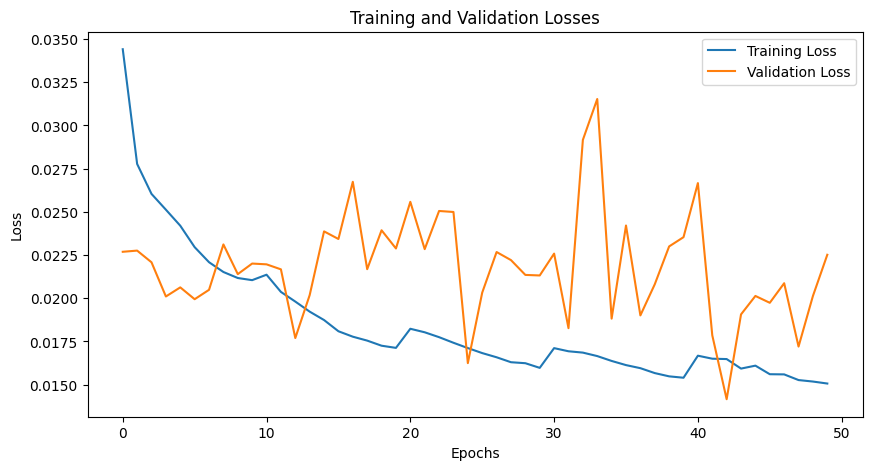

In [ ]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/AV Research/color_model.pt")

In [ ]:
from google.colab import runtime
runtime.unassign()